In [2]:
import gaps_online as go
import gaps_online.db as db
import re
from glob import glob
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path 

In [42]:
#load calibrations
calib = go.tof.calibrations.load_calibrations(Path('/data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/'))

if len(calib.keys()) != 40: print('Oh no! Some calibrations are missing :(')
else: print('Yay! All calibration files were loaded :)')

Loading calibration files:  34%|██████████████████████████████▍                                                          | 14/41 [00:01<00:01, 15.18it/s]

Failed to get RB ID from file /data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/Run122_1.2024_03_05-21_24_51.tof.gaps


Loading calibration files: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 12.70it/s]


Yay! All calibration files were loaded :)


In [ ]:
#testing if calib is loaded
print(sorted(calib.keys()))
print(len(calib.keys()))

In [52]:
#load paths and populate empty data structures for later use

max_pulse_dict = defaultdict(list)
max_pulses = []

tof_events = []
fixed_path = "/data1/nextcloud/cra_data/data/2023_nevis/tof/138/Run138"


files = glob(f'{fixed_path}_*.tof.gaps')
files = files [-5:]
print(len(files)) #checking to make sure files was populated

5


In [38]:
#pre-optimization

for fname in tqdm(files):
    data = go.tof.get_tofpackets(fname, filter=go.cxx_api.PacketType.TofEvent)
    evts = [go.cxx_api.TofEvent.from_tofpacket(k) for k in data]

    for ev in evts:
        rbids = ev.get_rbids()
        rbevents = [ev.get_rbevent(k) for k in rbids]

        for event_id in rbevents:
            if event_id.header.rb_id == 0: continue 
        
            key = event_id.header.rb_id
            if len(str(key)) > 2: continue #error where some ids are in the hundreds
            try:
                calibration = calib[key]
            except Exception as e:
                print(e)
                continue
            
            voltages = calibration.voltages(event_id)
    
            for channel in event_id.header.get_channels():
                if channel == 8: continue #exclude channel 9
                
                wv = np.array(voltages[channel]) #calibrating the voltages
                max_pulse = np.max(wv) 
                info = {'rbid' : key, 'channel' : channel, 'max_V' : max_pulse}
    
                max_pulses.append(info)

  0%|                                                                                                                            | 0/258 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [53]:
#trying to optimize for memory

from tqdm import tqdm

for fname in tqdm(files):
    data = go.tof.get_tofpackets(fname, filter=go.cxx_api.PacketType.TofEvent)
    
    for ev in (go.cxx_api.TofEvent.from_tofpacket(k) for k in data):
        rbids = ev.get_rbids()
        
        for event_id in (ev.get_rbevent(k) for k in rbids):
            if event_id.header.rb_id == 0:
                continue
            
            key = event_id.header.rb_id
            if len(str(key)) > 2:
                continue
            
            try:
                calibration = calib[key]
            except KeyError:
                continue
            
            voltages = calibration.voltages(event_id)
    
            for channel in event_id.header.get_channels():
                if channel == 8:
                    continue
                
                wv = np.array(voltages[channel]) #calibrating the voltages
                max_pulse = np.max(wv) 
                info = {'rbid' : key, 'channel' : channel, 'max_V' : max_pulse}
    
                max_pulses.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.31s/it]


In [45]:
#trying harder to optimize for memory
files = files[-200]
# Function to chunk the list into smaller sublists
def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Split files into chunks
chunk_size = len(files) // 4
file_chunks = chunk_list(files, chunk_size)

# Process each chunk
for chunk in tqdm(file_chunks):
    max_pulses_chunk = []  # Initialize max_pulses for this chunk
    for fname in tqdm(chunk):
        data = go.tof.get_tofpackets(fname, filter=go.cxx_api.PacketType.TofEvent)
        
        for ev in (go.cxx_api.TofEvent.from_tofpacket(k) for k in data):
            rbids = ev.get_rbids()
            
            for event_id in (ev.get_rbevent(k) for k in rbids):
                if event_id.header.rb_id == 0:
                    continue
                
                key = event_id.header.rb_id
                if len(str(key)) > 2:
                    continue
                
                try:
                    calibration = calib[key]
                except KeyError:
                    continue
                
                voltages = calibration.voltages(event_id)
        
                for channel in event_id.header.get_channels():
                    if channel == 8:
                        continue
                    
                    wv = np.array(voltages[channel]) #calibrating the voltages
                    max_pulse = np.max(wv) 
                    info = {'rbid' : key, 'channel' : channel, 'max_V' : max_pulse}
        
                    max_pulses_chunk.append(info)  # Append to chunk-specific max_pulses
    
    max_pulses.extend(max_pulses_chunk)  # Append chunk-specific results to the main max_pulses list


0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.81s/it]
1it [00:16, 16.87s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.14s/it]
2it [00:33, 16.45s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.44s/it]
3it [00:48, 16.00s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.82s/it]
4it [01:04, 16.08s/it]


In [46]:
print(len(max_pulses))

1490384


In [54]:
for element in tqdm(max_pulses):
    r = element['rbid']
    channel1 = element['channel']
    max_V = element['max_V']

    max_pulse_dict[(r, channel1)].append(max_V)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1728640/1728640 [00:01<00:00, 1498801.17it/s]


In [48]:
print(len(max_pulse_dict.keys()))

320


  0%|                                                                                                                            | 0/320 [00:00<?, ?it/s]

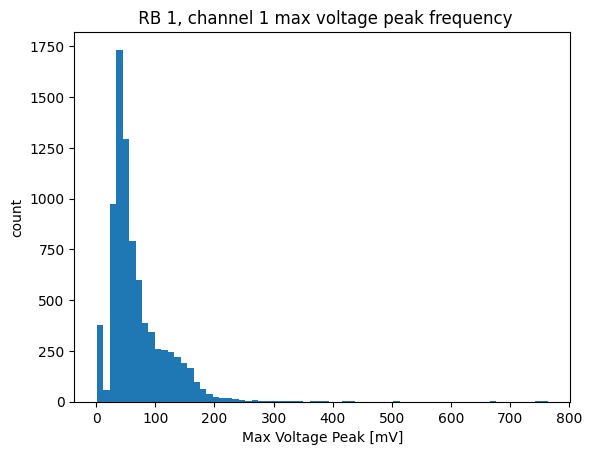

  0%|▎                                                                                                                   | 1/320 [00:00<02:04,  2.56it/s]

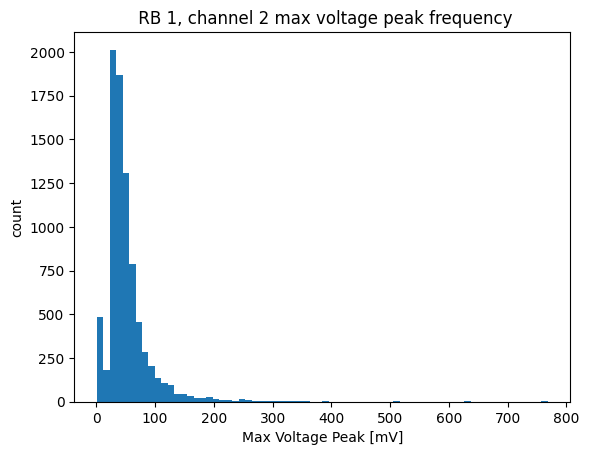

  1%|▋                                                                                                                   | 2/320 [00:00<01:44,  3.04it/s]

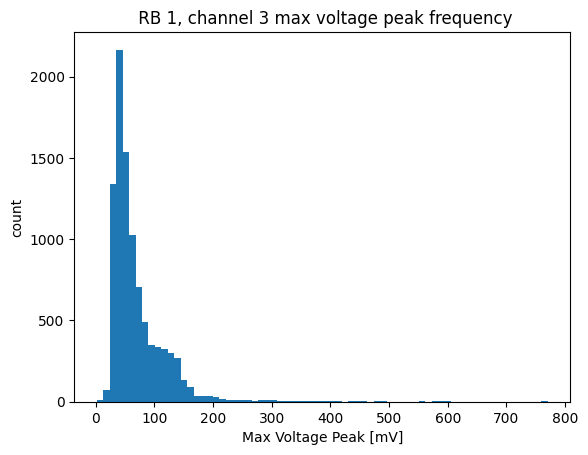

  1%|█                                                                                                                   | 3/320 [00:00<01:34,  3.34it/s]

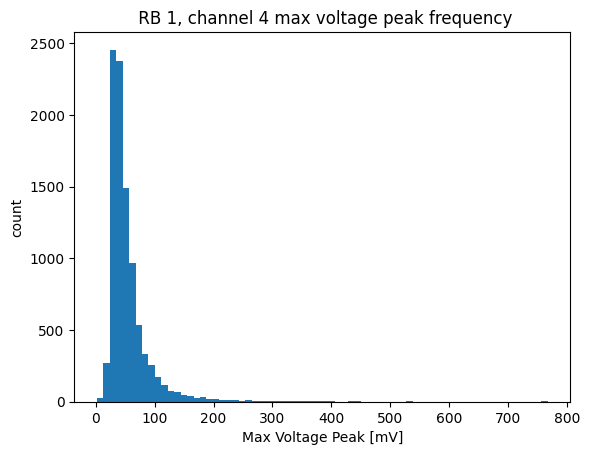

  1%|█▍                                                                                                                  | 4/320 [00:01<01:30,  3.51it/s]

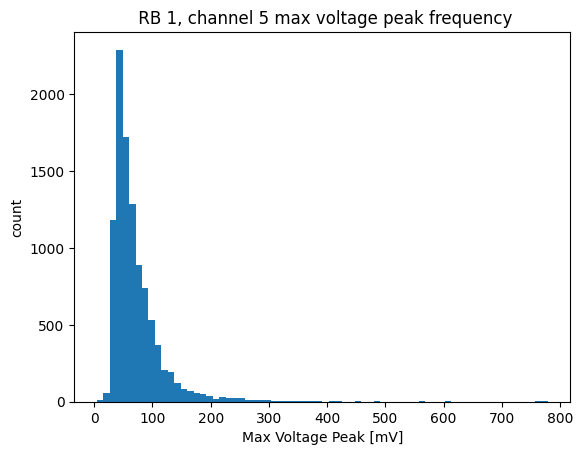

  2%|█▊                                                                                                                  | 5/320 [00:01<01:26,  3.65it/s]

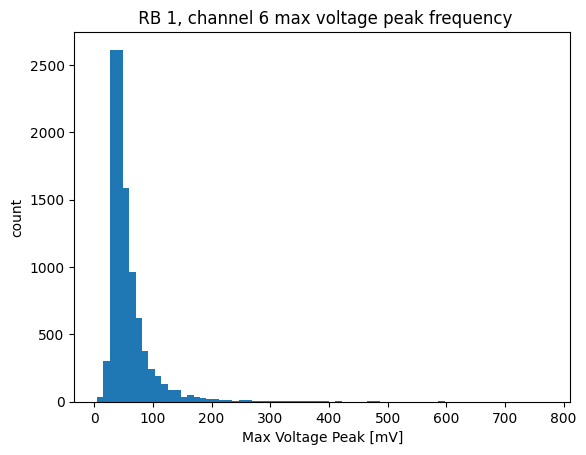

  2%|██▏                                                                                                                 | 6/320 [00:01<01:25,  3.69it/s]

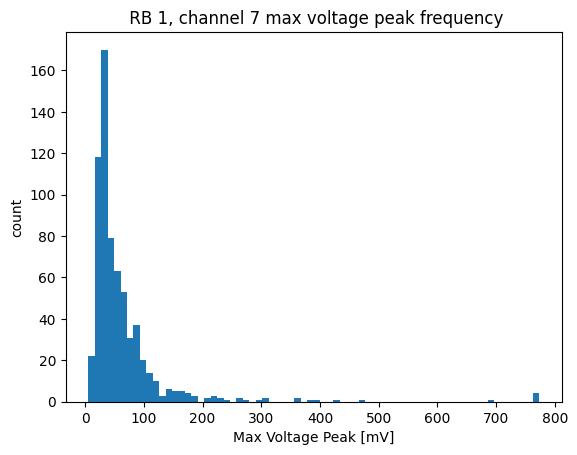

  2%|██▌                                                                                                                 | 7/320 [00:01<01:23,  3.74it/s]

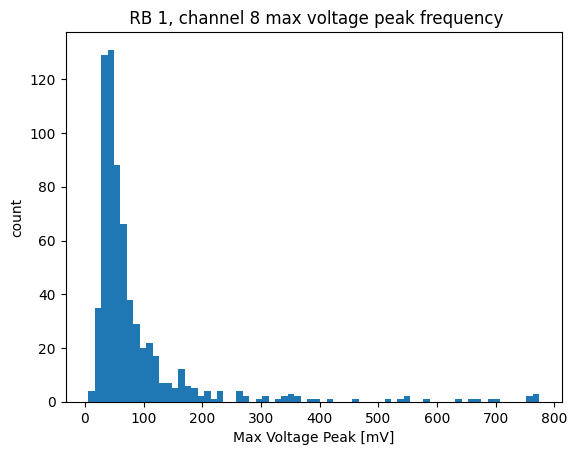

  2%|██▉                                                                                                                 | 8/320 [00:02<01:20,  3.87it/s]

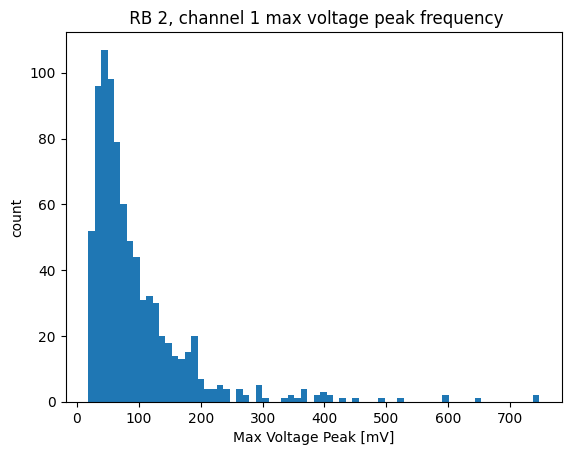

  3%|███▎                                                                                                                | 9/320 [00:02<01:17,  4.02it/s]

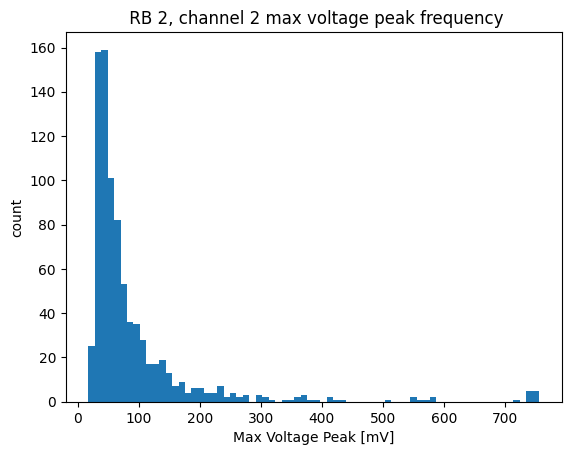

  3%|███▌                                                                                                               | 10/320 [00:03<02:01,  2.56it/s]

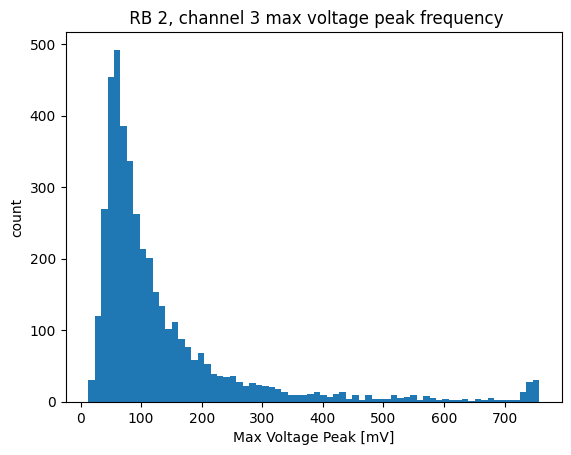

  3%|███▉                                                                                                               | 11/320 [00:03<01:46,  2.89it/s]

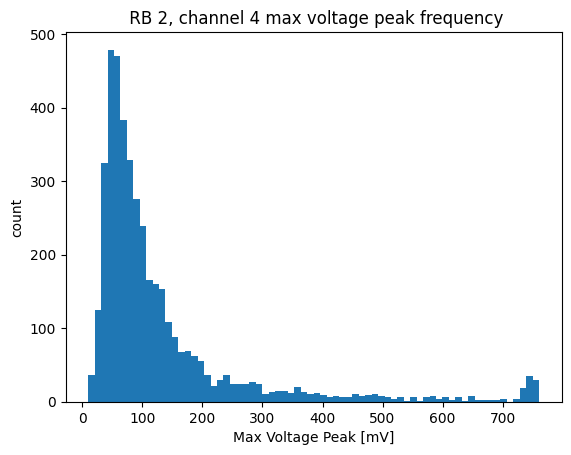

  4%|████▎                                                                                                              | 12/320 [00:03<01:36,  3.20it/s]

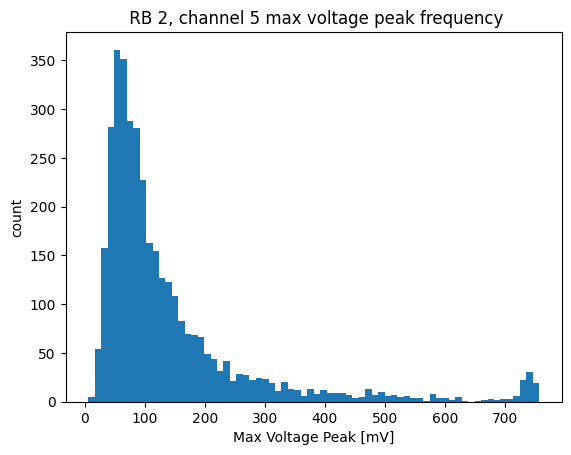

  4%|████▋                                                                                                              | 13/320 [00:03<01:29,  3.44it/s]

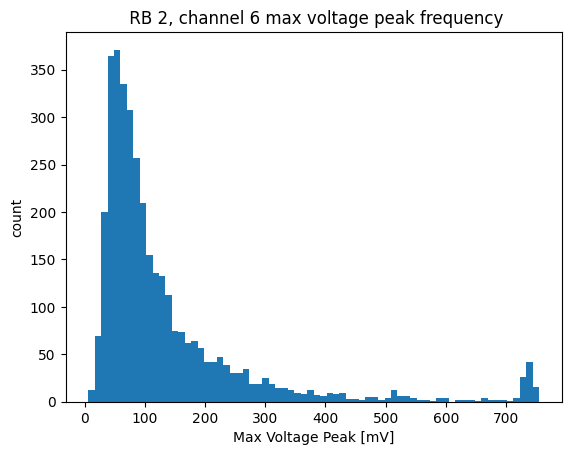

  4%|█████                                                                                                              | 14/320 [00:04<01:24,  3.62it/s]

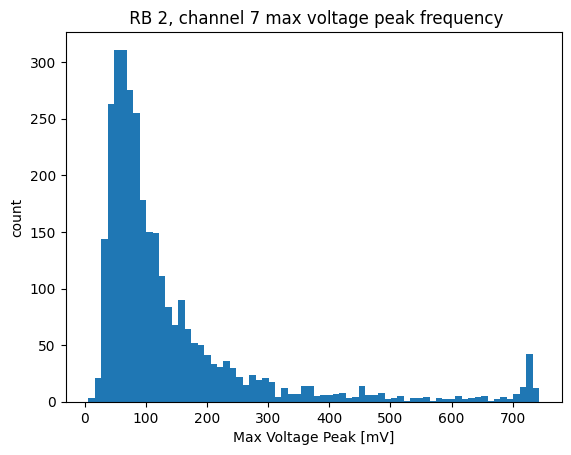

  5%|█████▍                                                                                                             | 15/320 [00:04<01:21,  3.75it/s]

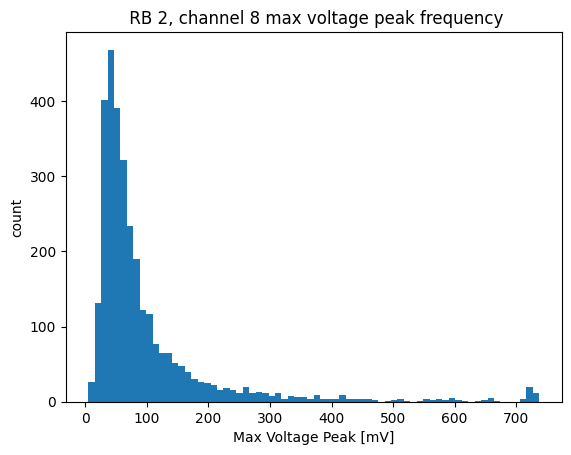

  5%|█████▊                                                                                                             | 16/320 [00:04<01:17,  3.93it/s]

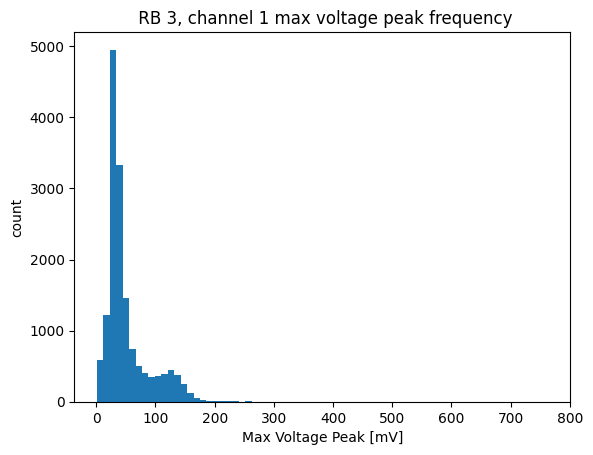

  5%|██████                                                                                                             | 17/320 [00:04<01:19,  3.83it/s]

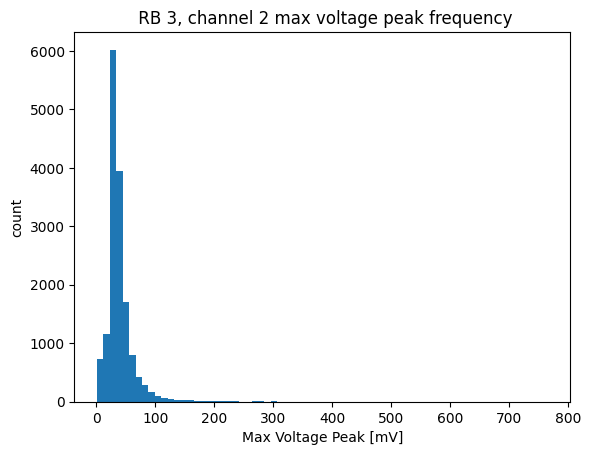

  6%|██████▍                                                                                                            | 18/320 [00:05<01:23,  3.62it/s]

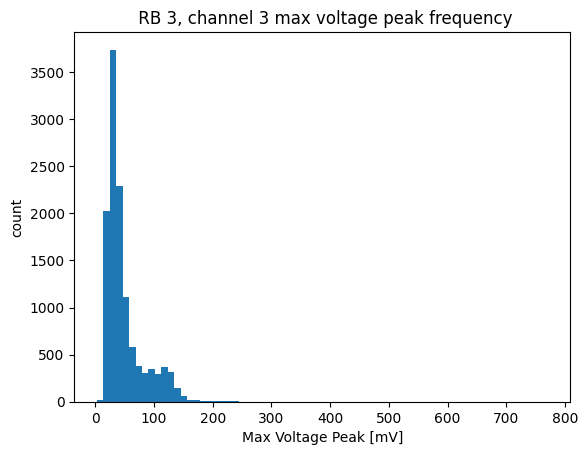

  6%|██████▊                                                                                                            | 19/320 [00:05<01:25,  3.52it/s]

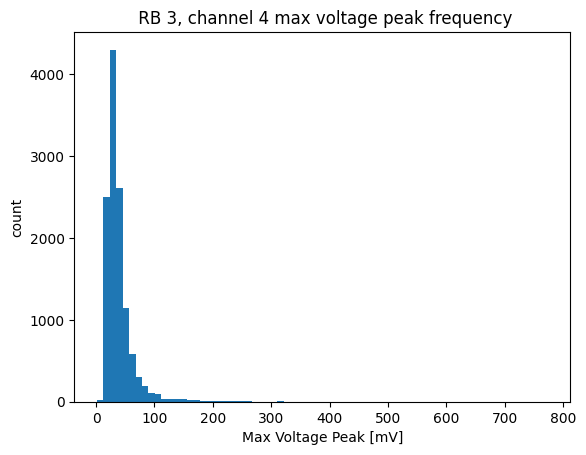

  6%|███████▏                                                                                                           | 20/320 [00:05<01:23,  3.59it/s]

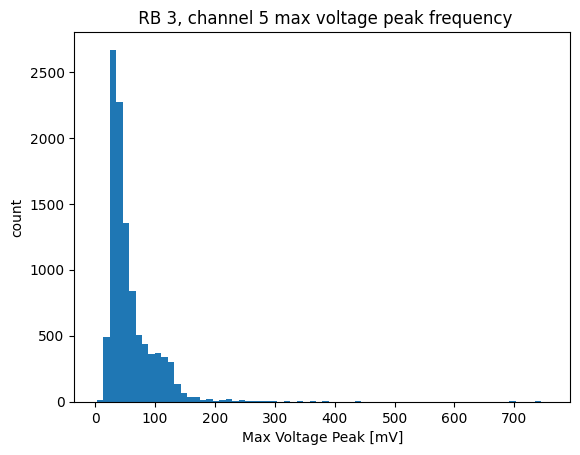

  7%|███████▌                                                                                                           | 21/320 [00:06<01:21,  3.69it/s]

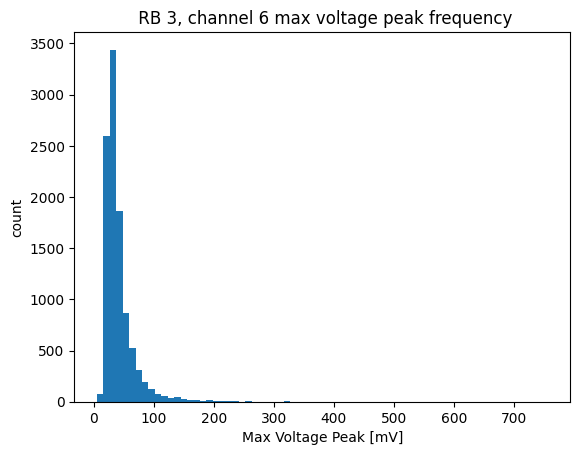

  7%|███████▉                                                                                                           | 22/320 [00:06<01:19,  3.74it/s]

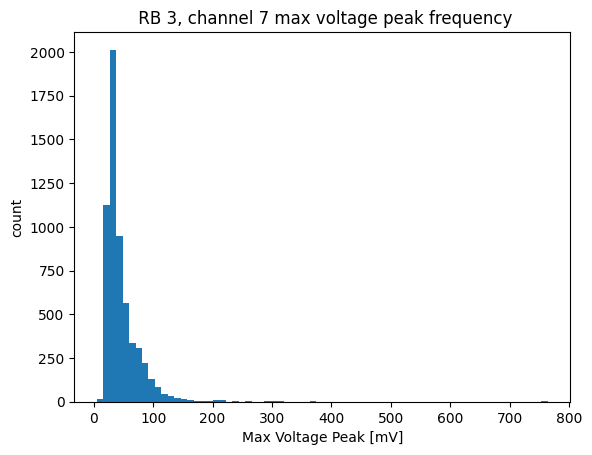

  7%|████████▎                                                                                                          | 23/320 [00:06<01:18,  3.77it/s]

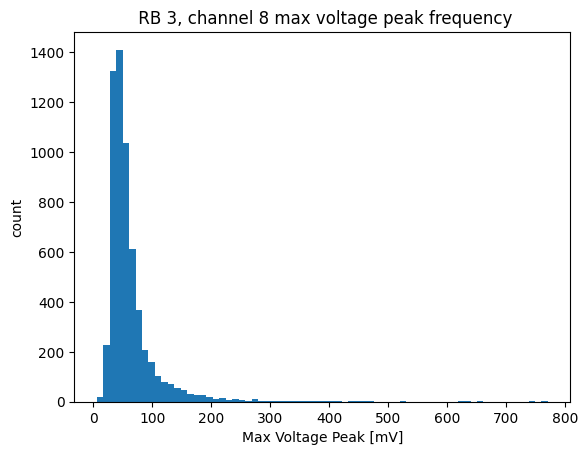

  8%|████████▋                                                                                                          | 24/320 [00:06<01:17,  3.83it/s]

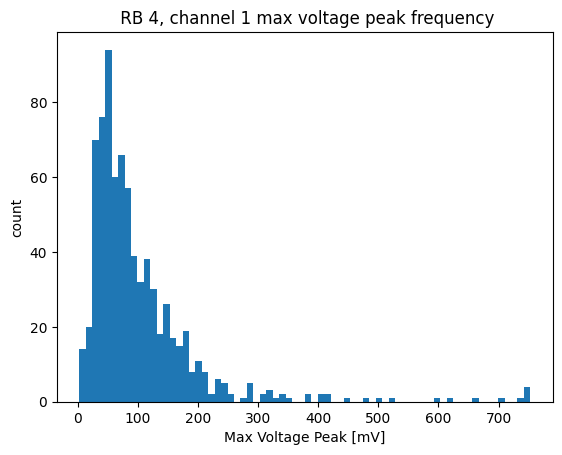

  8%|████████▉                                                                                                          | 25/320 [00:07<01:45,  2.81it/s]

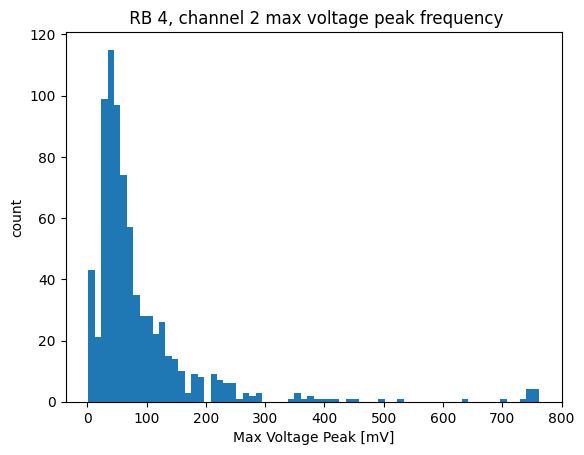

  8%|█████████▎                                                                                                         | 26/320 [00:07<01:33,  3.13it/s]

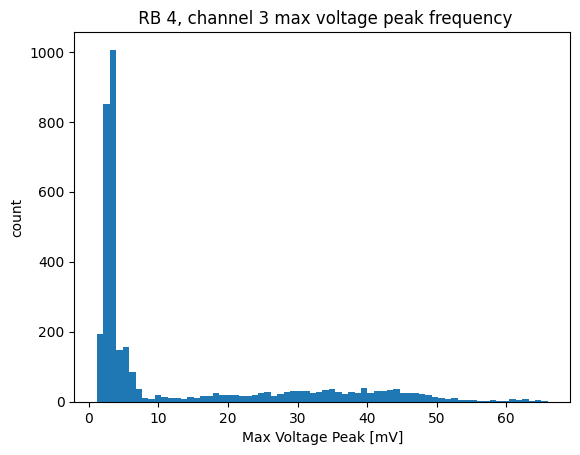

  8%|█████████▋                                                                                                         | 27/320 [00:07<01:25,  3.42it/s]

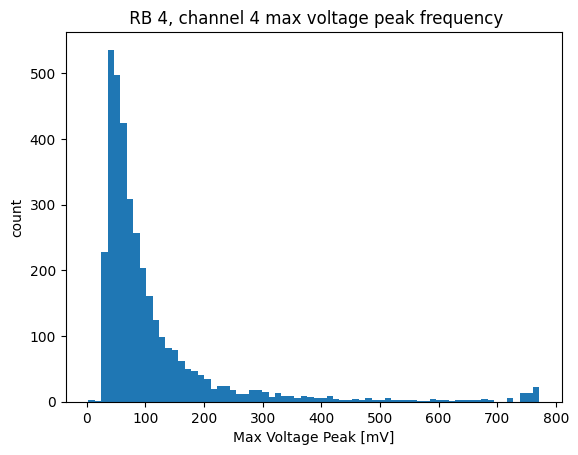

  9%|██████████                                                                                                         | 28/320 [00:08<01:19,  3.65it/s]

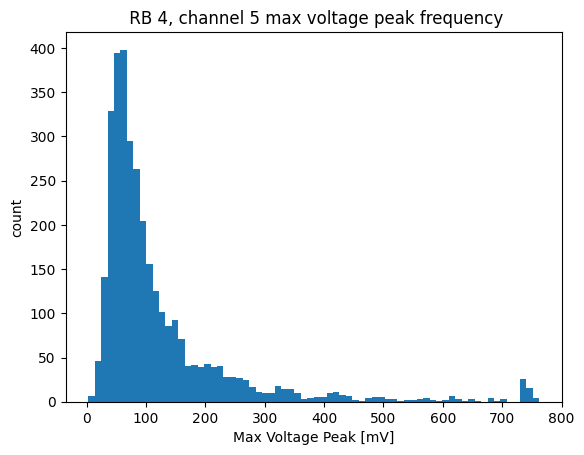

  9%|██████████▍                                                                                                        | 29/320 [00:08<01:17,  3.77it/s]

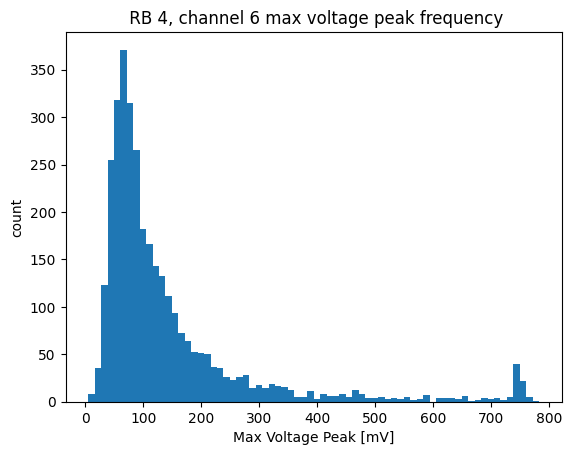

  9%|██████████▊                                                                                                        | 30/320 [00:08<01:14,  3.87it/s]

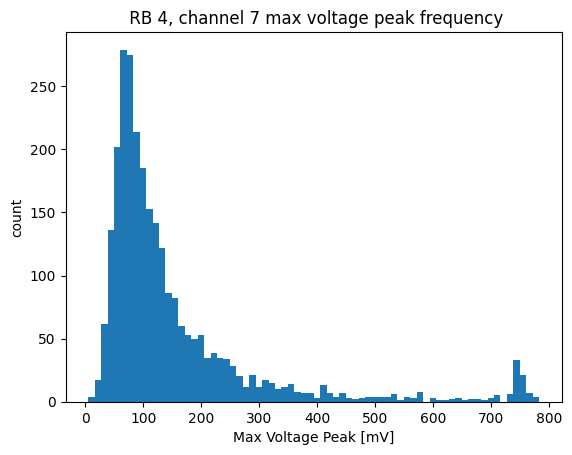

 10%|███████████▏                                                                                                       | 31/320 [00:08<01:12,  3.99it/s]

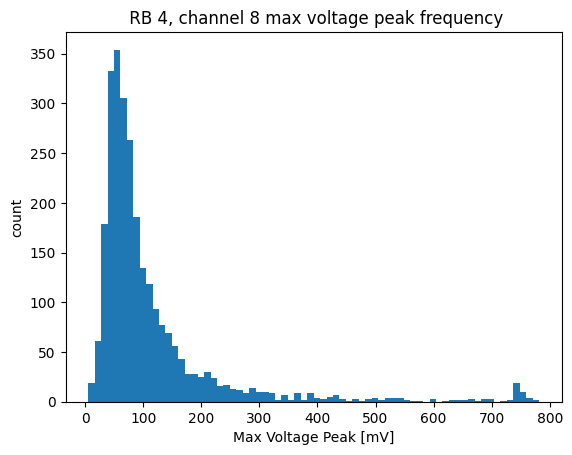

 10%|███████████▌                                                                                                       | 32/320 [00:09<01:11,  4.05it/s]

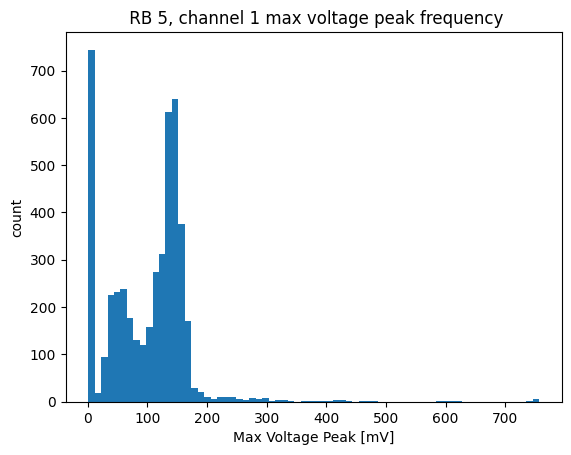

 10%|███████████▊                                                                                                       | 33/320 [00:09<01:09,  4.11it/s]

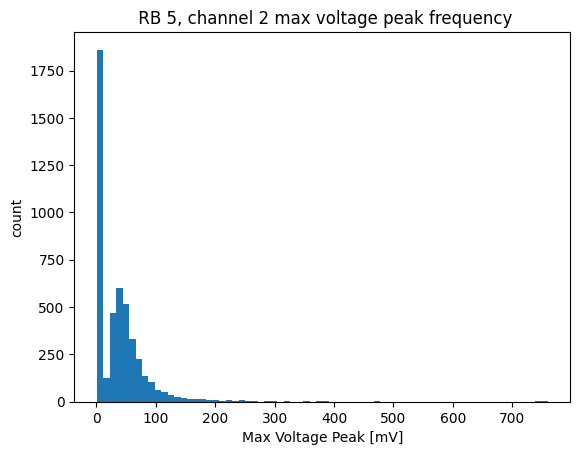

 11%|████████████▏                                                                                                      | 34/320 [00:09<01:09,  4.13it/s]

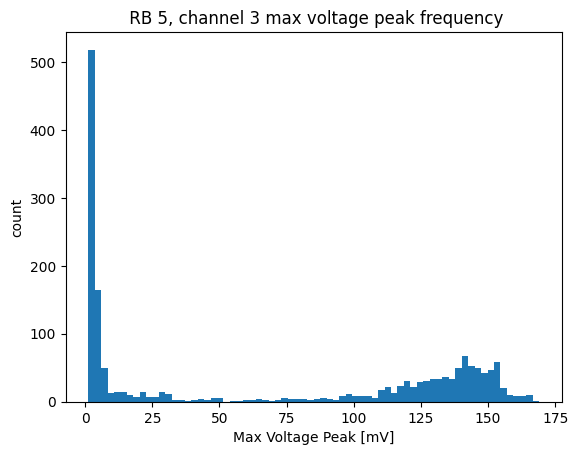

 11%|████████████▌                                                                                                      | 35/320 [00:09<01:06,  4.26it/s]

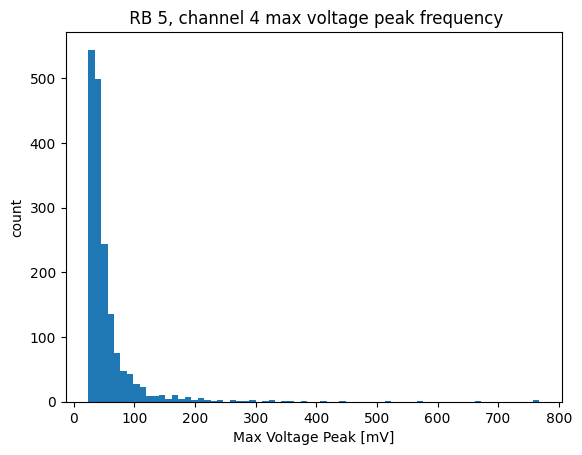

 11%|████████████▉                                                                                                      | 36/320 [00:09<01:05,  4.33it/s]

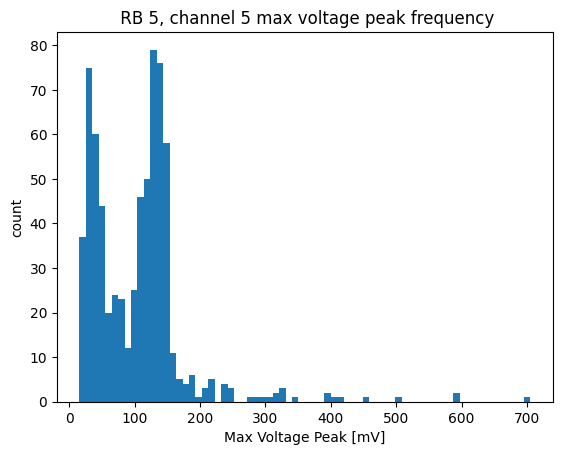

 12%|█████████████▎                                                                                                     | 37/320 [00:10<01:05,  4.30it/s]

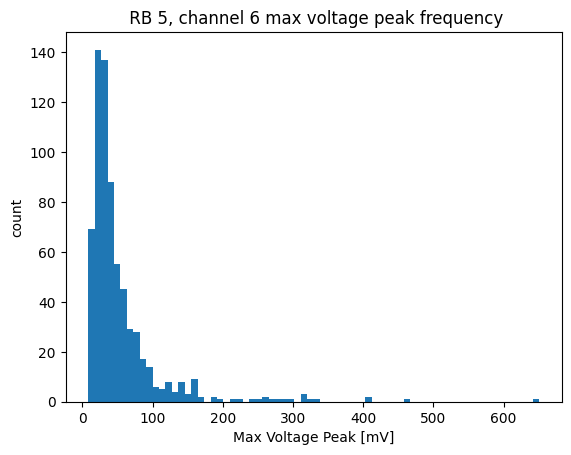

 12%|█████████████▋                                                                                                     | 38/320 [00:10<01:05,  4.33it/s]

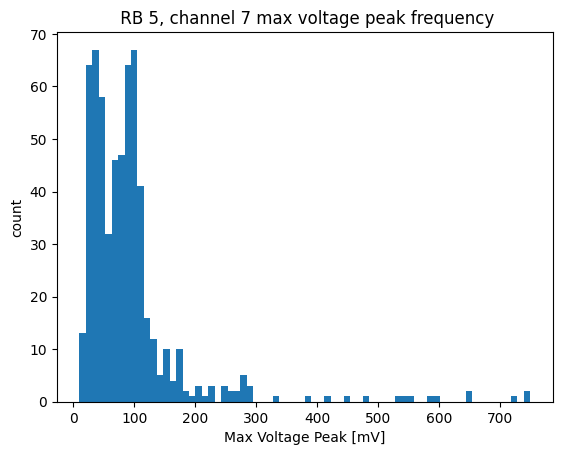

 12%|██████████████                                                                                                     | 39/320 [00:10<01:35,  2.94it/s]

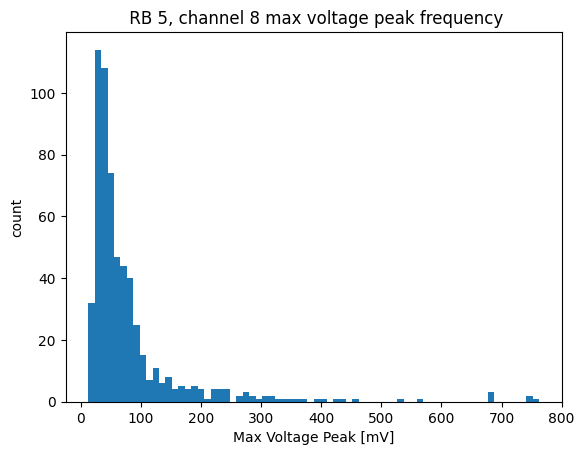

 12%|██████████████▍                                                                                                    | 40/320 [00:11<01:25,  3.27it/s]

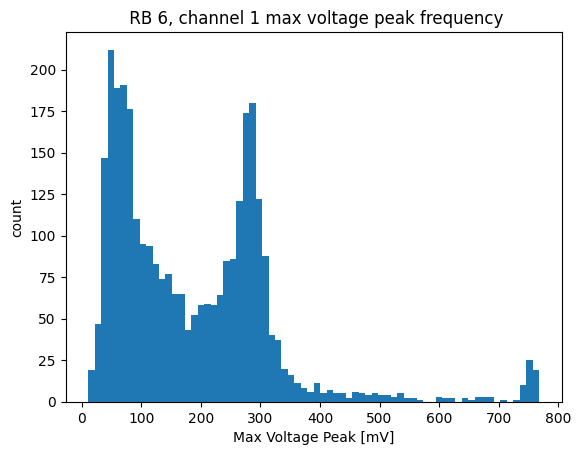

 13%|██████████████▋                                                                                                    | 41/320 [00:11<01:20,  3.45it/s]

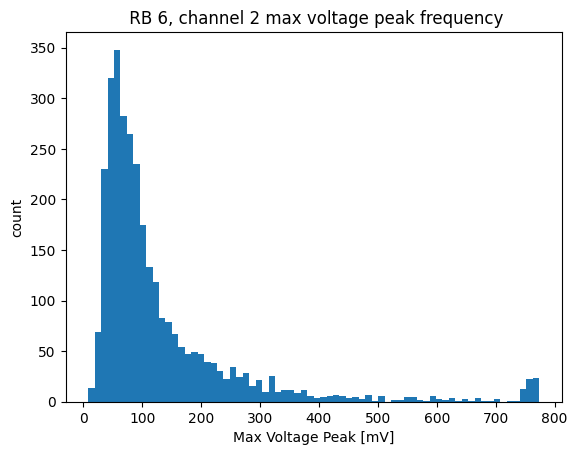

 13%|███████████████                                                                                                    | 42/320 [00:11<01:16,  3.61it/s]

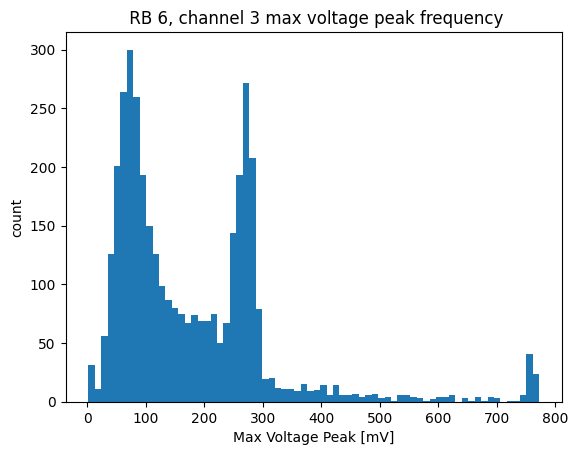

 13%|███████████████▍                                                                                                   | 43/320 [00:11<01:13,  3.74it/s]

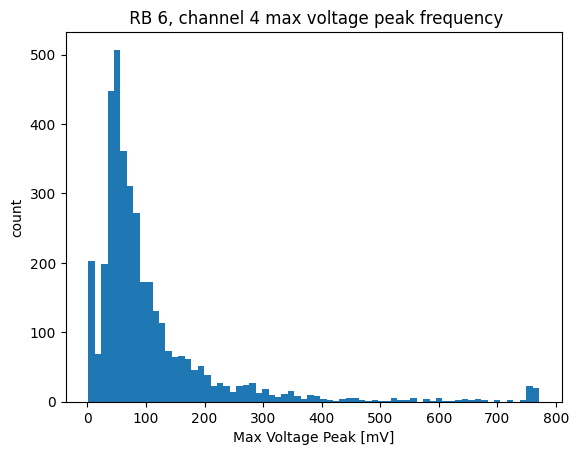

 14%|███████████████▊                                                                                                   | 44/320 [00:12<01:10,  3.90it/s]

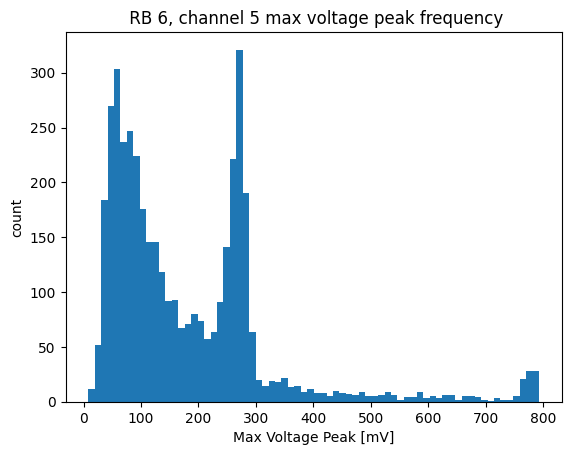

 14%|████████████████▏                                                                                                  | 45/320 [00:12<01:08,  3.99it/s]

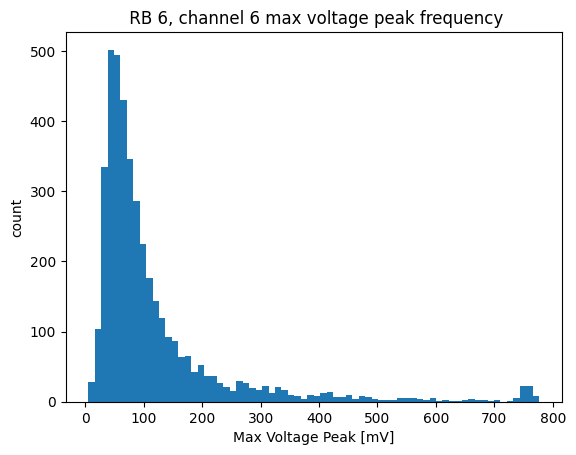

 14%|████████████████▌                                                                                                  | 46/320 [00:12<01:07,  4.08it/s]

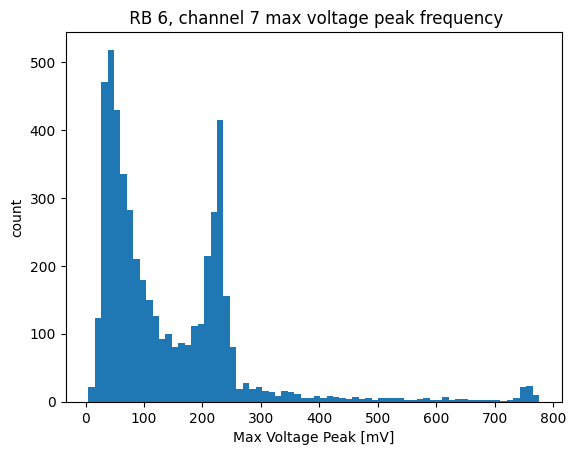

 15%|████████████████▉                                                                                                  | 47/320 [00:12<01:06,  4.14it/s]

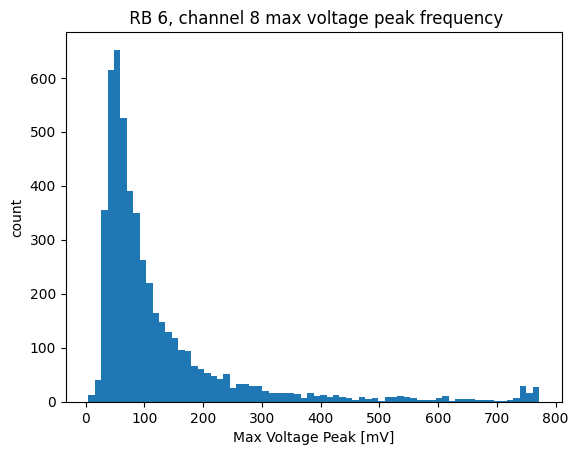

 15%|█████████████████▎                                                                                                 | 48/320 [00:13<01:06,  4.07it/s]

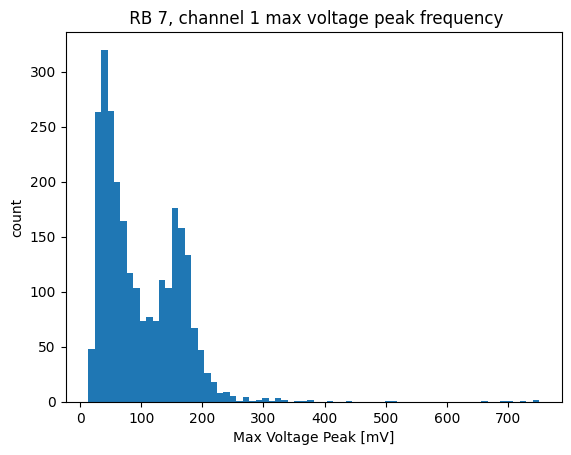

 15%|█████████████████▌                                                                                                 | 49/320 [00:13<01:05,  4.13it/s]

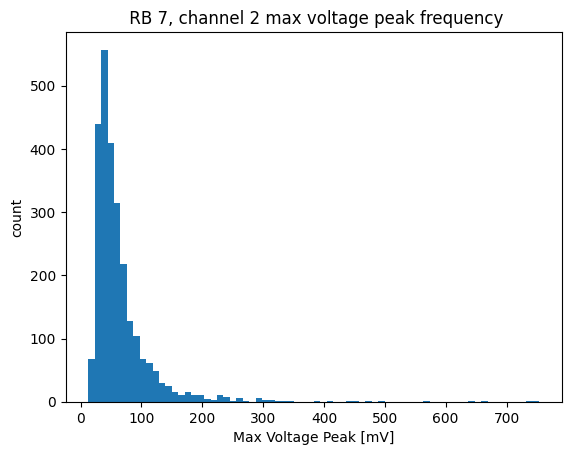

 16%|█████████████████▉                                                                                                 | 50/320 [00:13<01:04,  4.21it/s]

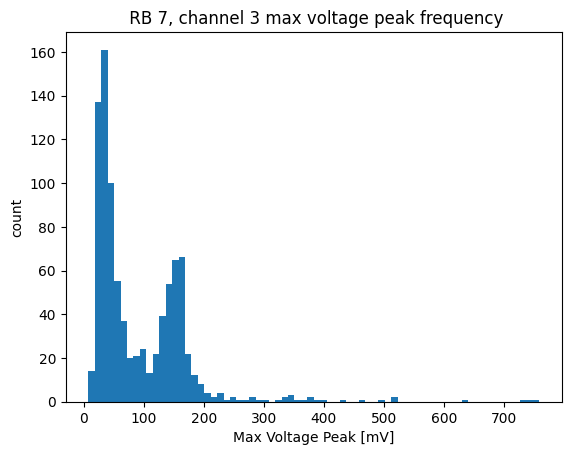

 16%|██████████████████▎                                                                                                | 51/320 [00:13<01:04,  4.19it/s]

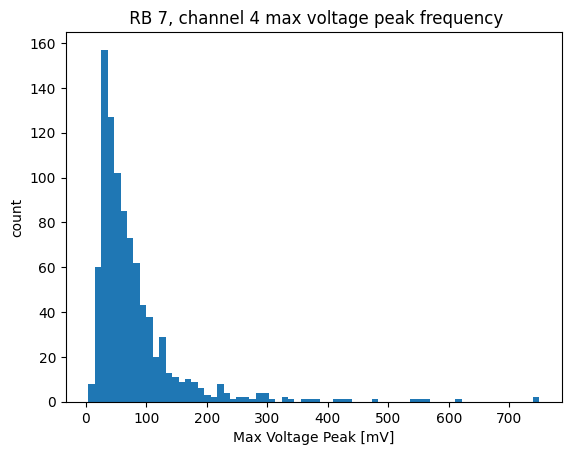

 16%|██████████████████▋                                                                                                | 52/320 [00:14<01:04,  4.16it/s]

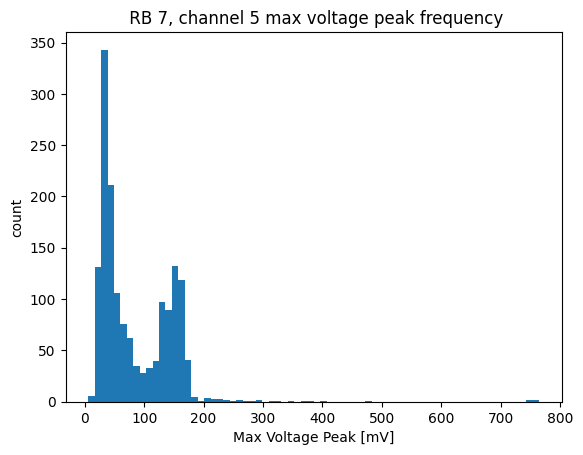

 17%|███████████████████                                                                                                | 53/320 [00:14<01:03,  4.19it/s]

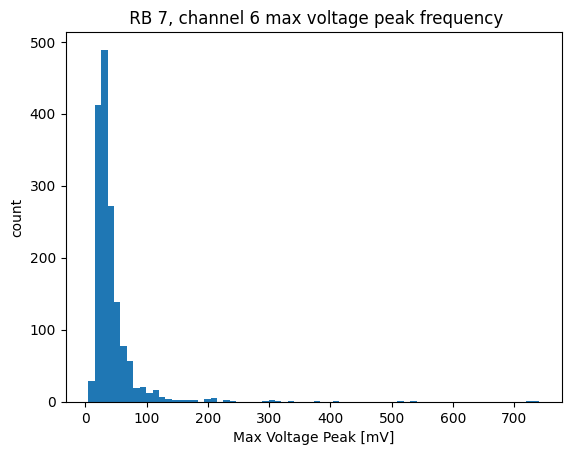

 17%|███████████████████▍                                                                                               | 54/320 [00:14<01:02,  4.28it/s]

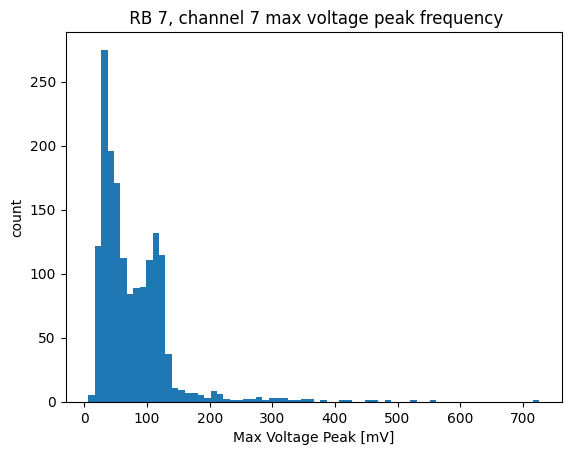

 17%|███████████████████▊                                                                                               | 55/320 [00:15<01:34,  2.81it/s]

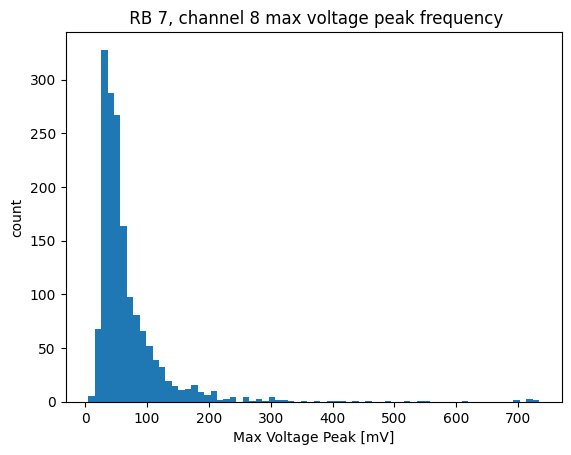

 18%|████████████████████▏                                                                                              | 56/320 [00:15<01:23,  3.16it/s]

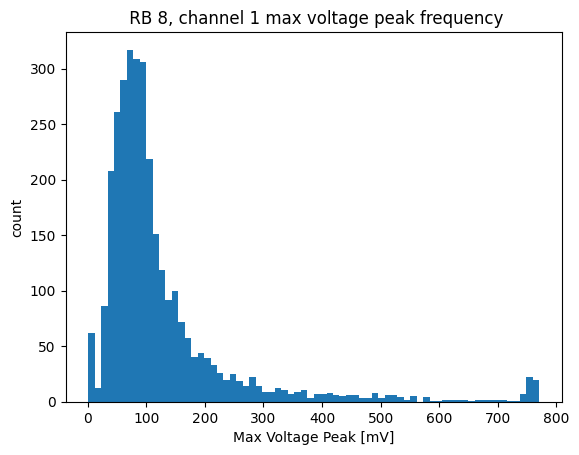

 18%|████████████████████▍                                                                                              | 57/320 [00:15<01:16,  3.42it/s]

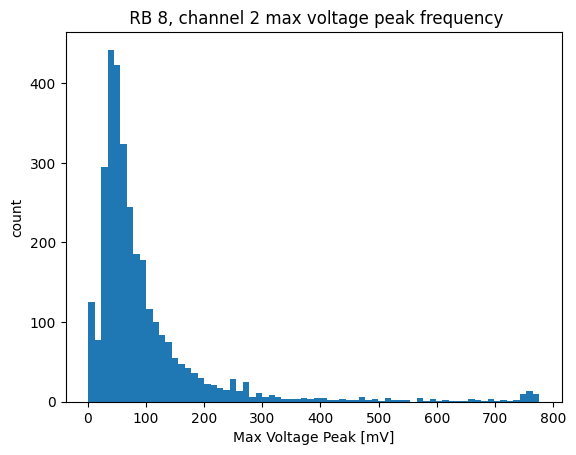

 18%|████████████████████▊                                                                                              | 58/320 [00:15<01:10,  3.70it/s]

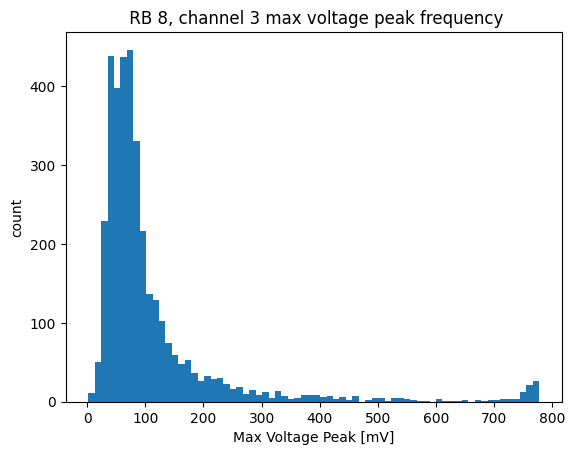

 18%|█████████████████████▏                                                                                             | 59/320 [00:16<01:06,  3.92it/s]

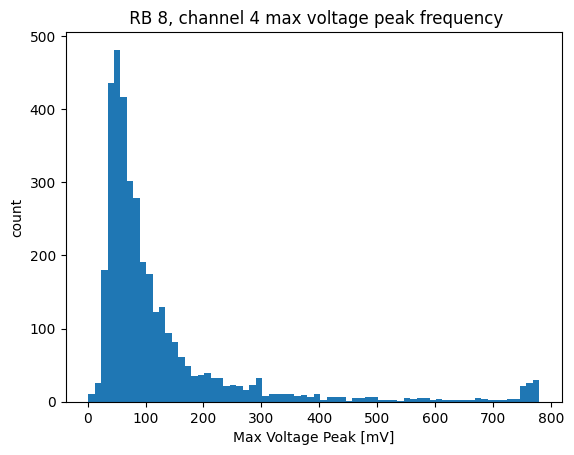

 19%|█████████████████████▌                                                                                             | 60/320 [00:16<01:05,  3.99it/s]

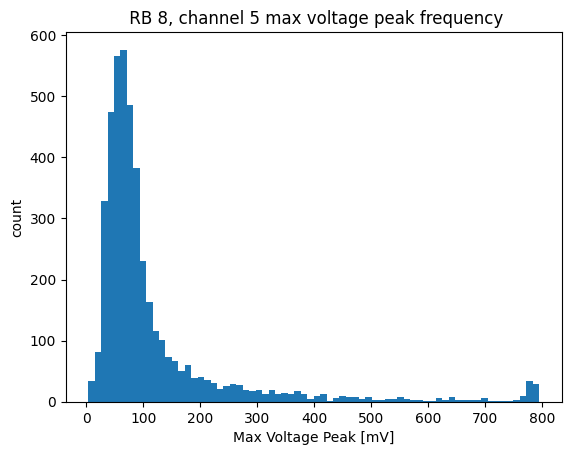

 19%|█████████████████████▉                                                                                             | 61/320 [00:16<01:03,  4.05it/s]

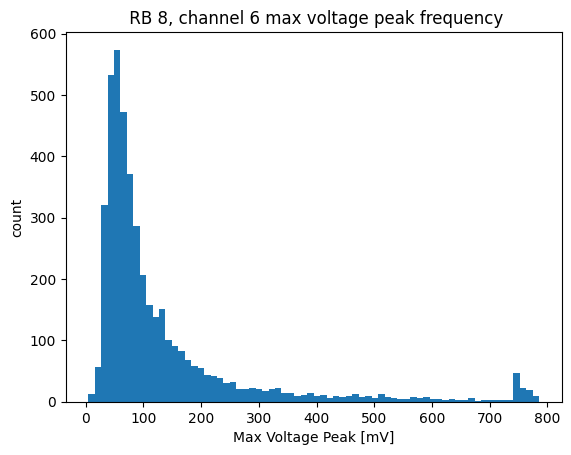

 19%|██████████████████████▎                                                                                            | 62/320 [00:16<01:02,  4.10it/s]

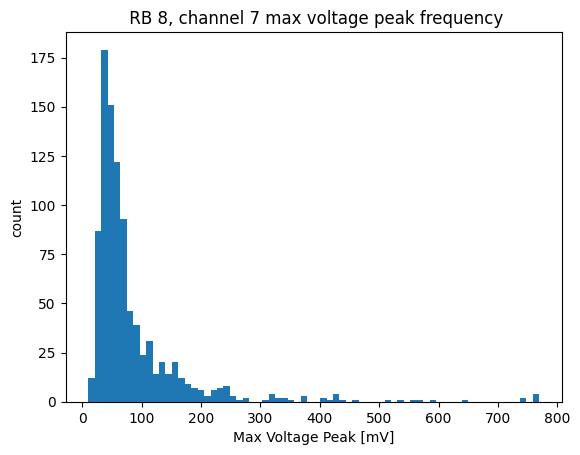

 20%|██████████████████████▋                                                                                            | 63/320 [00:17<01:02,  4.11it/s]

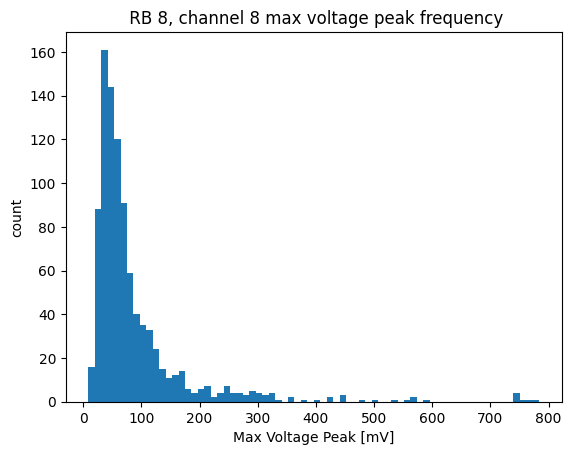

 20%|███████████████████████                                                                                            | 64/320 [00:17<01:01,  4.14it/s]

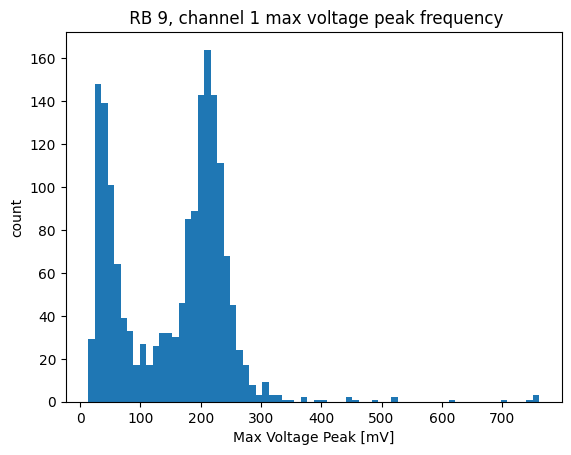

 20%|███████████████████████▎                                                                                           | 65/320 [00:17<01:00,  4.18it/s]

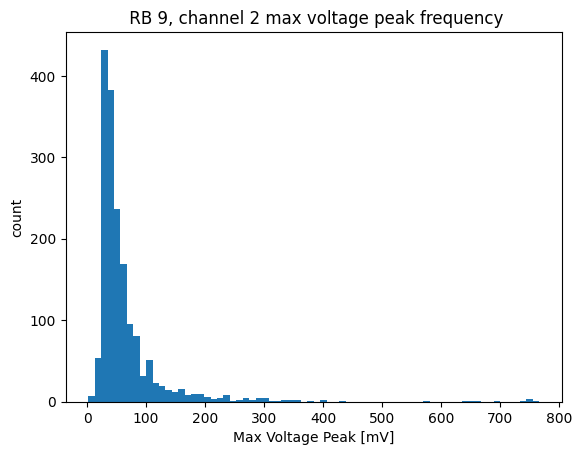

 21%|███████████████████████▋                                                                                           | 66/320 [00:17<00:59,  4.30it/s]

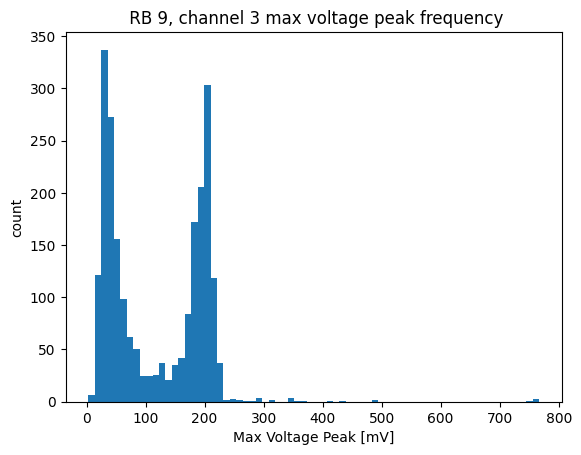

 21%|████████████████████████                                                                                           | 67/320 [00:17<00:59,  4.24it/s]

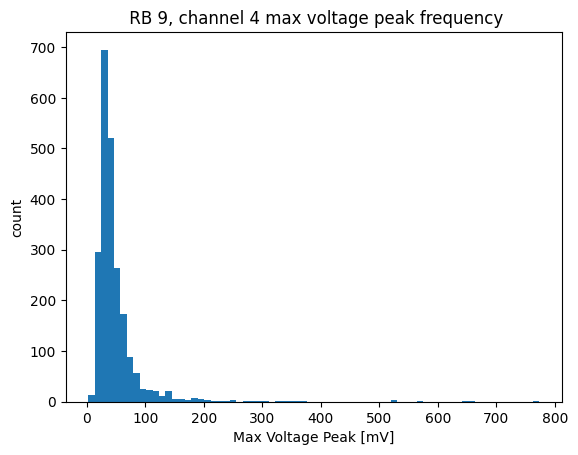

 21%|████████████████████████▍                                                                                          | 68/320 [00:18<00:59,  4.27it/s]

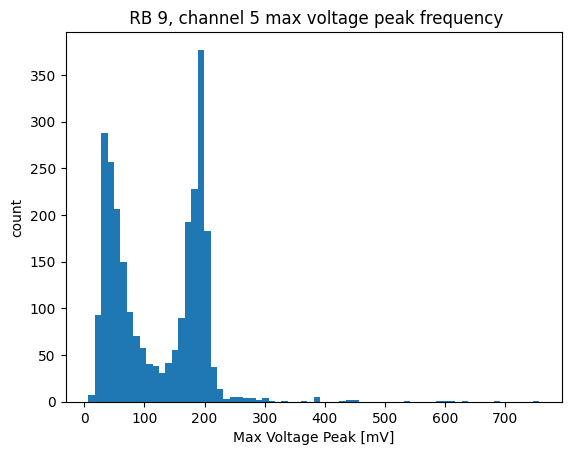

 22%|████████████████████████▊                                                                                          | 69/320 [00:18<01:26,  2.91it/s]

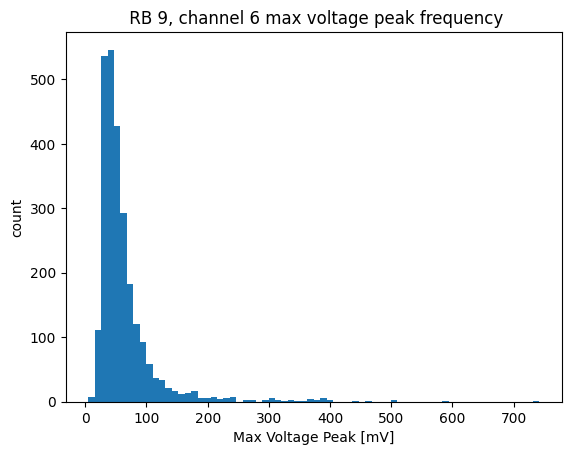

 22%|█████████████████████████▏                                                                                         | 70/320 [00:19<01:17,  3.23it/s]

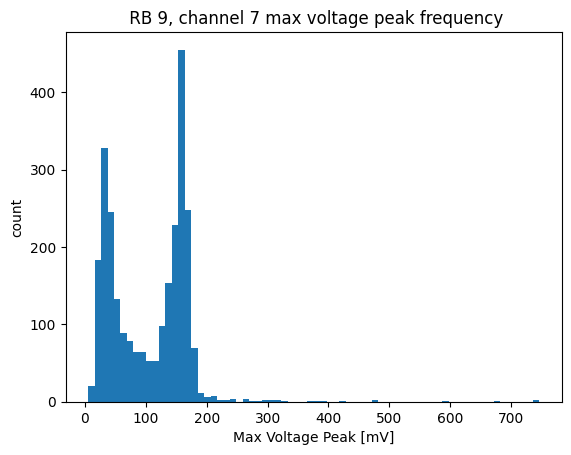

 22%|█████████████████████████▌                                                                                         | 71/320 [00:19<01:09,  3.56it/s]

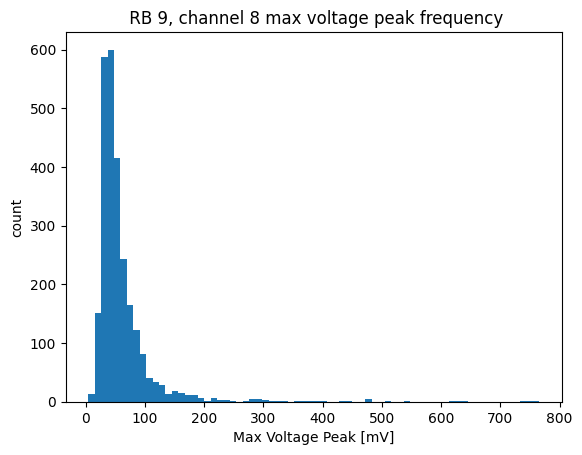

 22%|█████████████████████████▉                                                                                         | 72/320 [00:19<01:05,  3.77it/s]

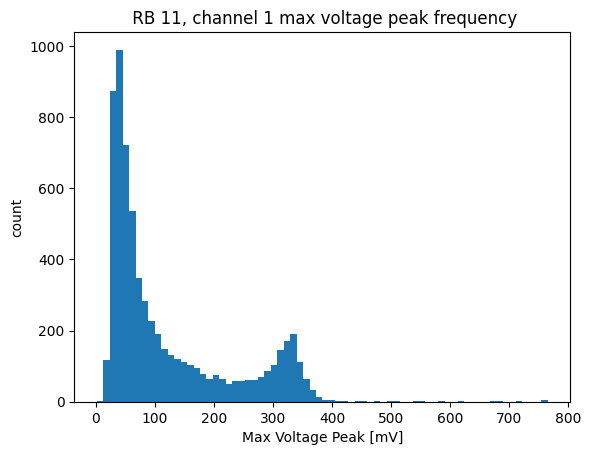

 23%|██████████████████████████▏                                                                                        | 73/320 [00:19<01:03,  3.91it/s]

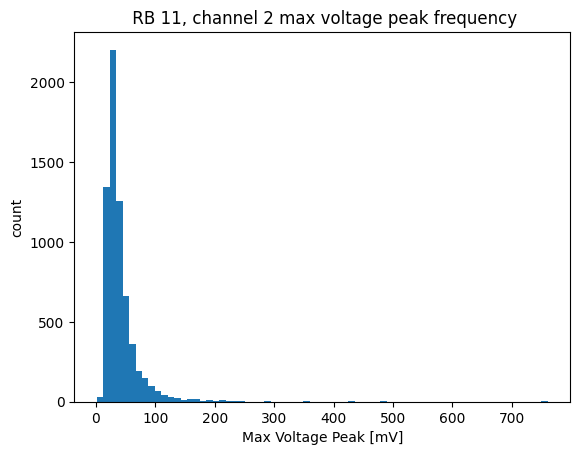

 23%|██████████████████████████▌                                                                                        | 74/320 [00:19<01:00,  4.06it/s]

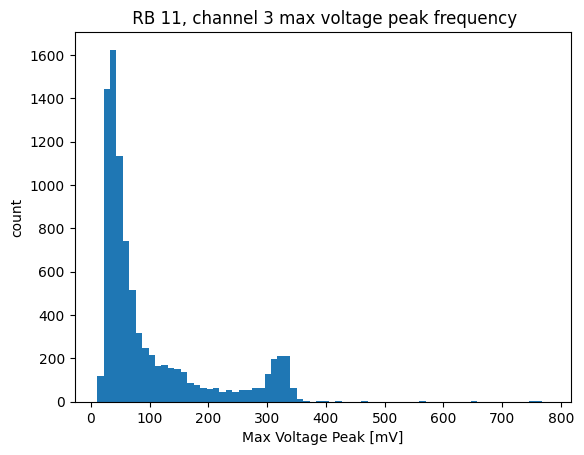

 23%|██████████████████████████▉                                                                                        | 75/320 [00:20<01:01,  4.00it/s]

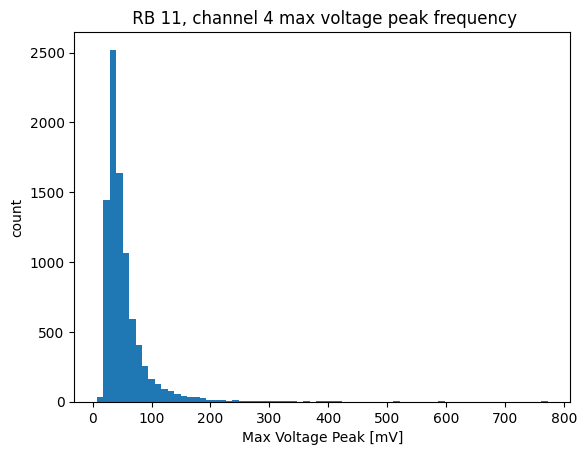

 24%|███████████████████████████▎                                                                                       | 76/320 [00:20<01:00,  4.05it/s]

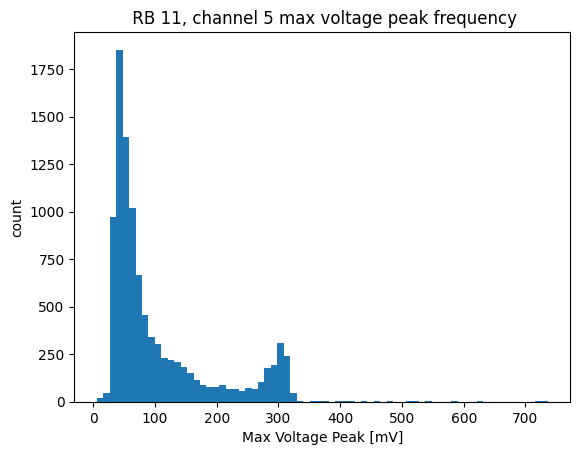

 24%|███████████████████████████▋                                                                                       | 77/320 [00:20<01:00,  4.03it/s]

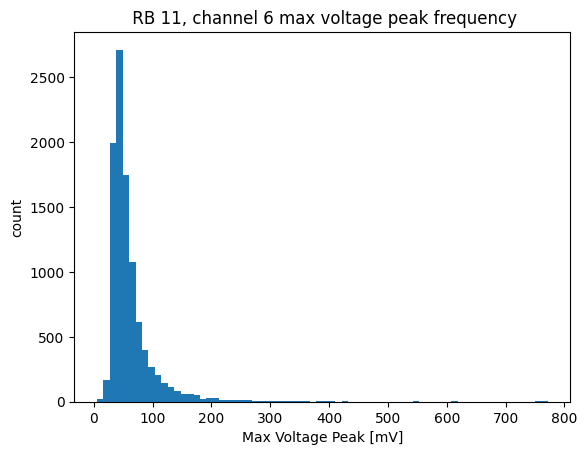

 24%|████████████████████████████                                                                                       | 78/320 [00:20<00:59,  4.07it/s]

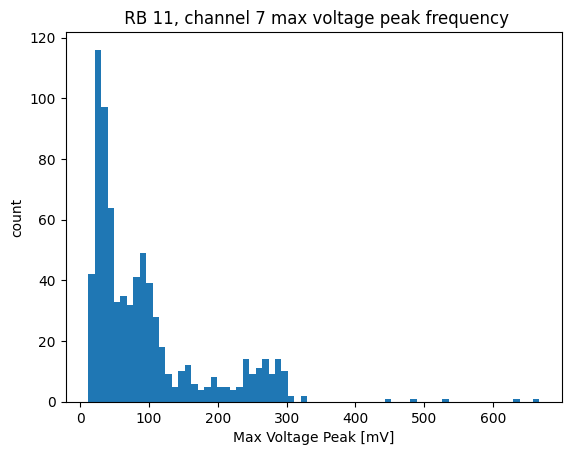

 25%|████████████████████████████▍                                                                                      | 79/320 [00:21<00:56,  4.23it/s]

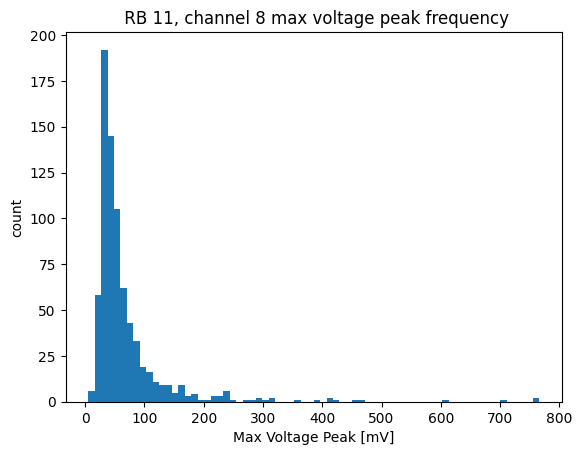

 25%|████████████████████████████▊                                                                                      | 80/320 [00:21<00:56,  4.25it/s]

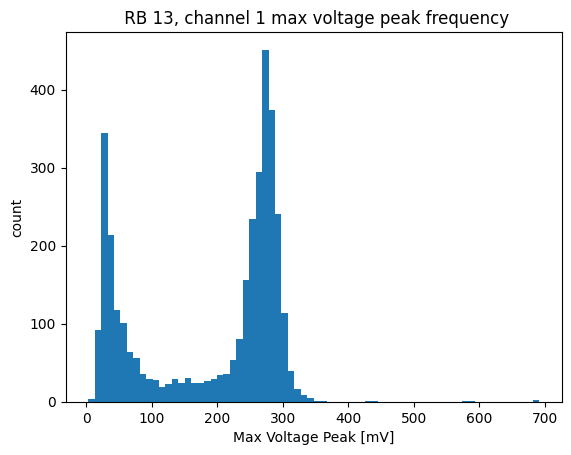

 25%|█████████████████████████████                                                                                      | 81/320 [00:21<00:54,  4.36it/s]

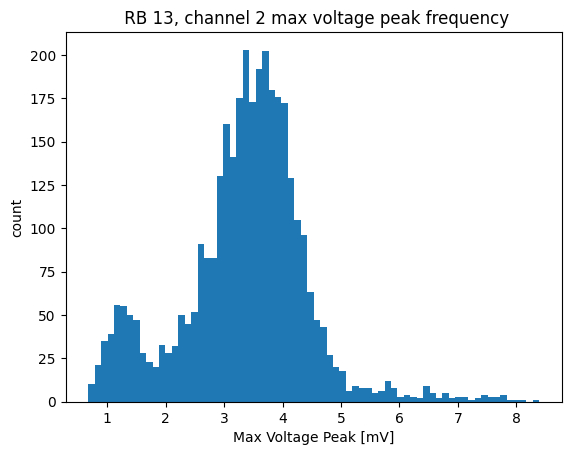

 26%|█████████████████████████████▍                                                                                     | 82/320 [00:21<00:55,  4.33it/s]

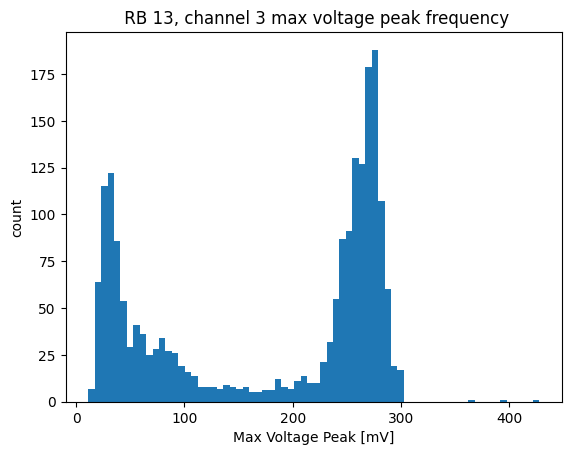

 26%|█████████████████████████████▊                                                                                     | 83/320 [00:22<01:18,  3.02it/s]

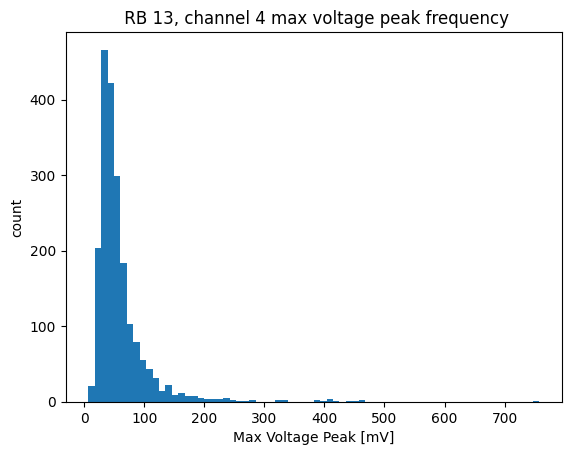

 26%|██████████████████████████████▏                                                                                    | 84/320 [00:22<01:09,  3.37it/s]

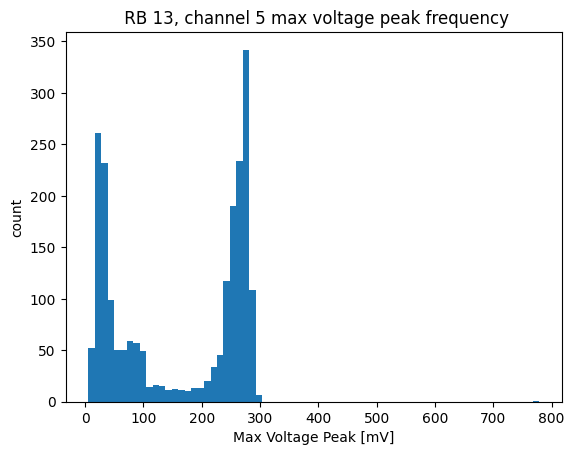

 27%|██████████████████████████████▌                                                                                    | 85/320 [00:22<01:05,  3.59it/s]

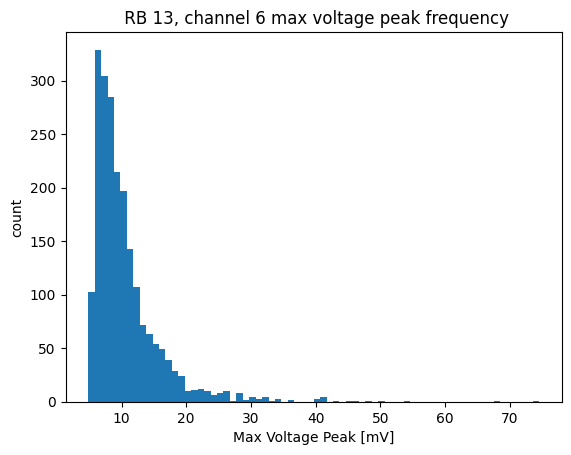

 27%|██████████████████████████████▉                                                                                    | 86/320 [00:23<01:01,  3.82it/s]

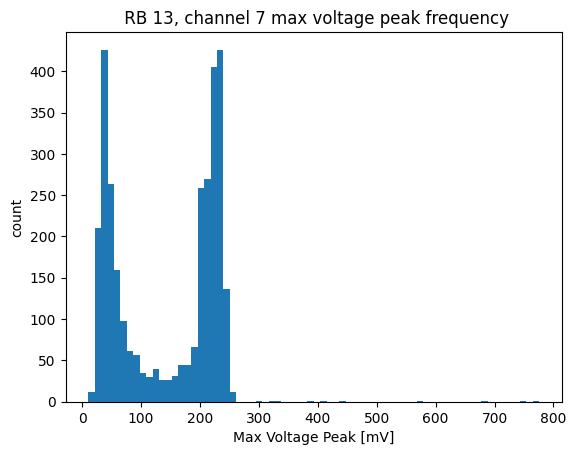

 27%|███████████████████████████████▎                                                                                   | 87/320 [00:23<00:59,  3.92it/s]

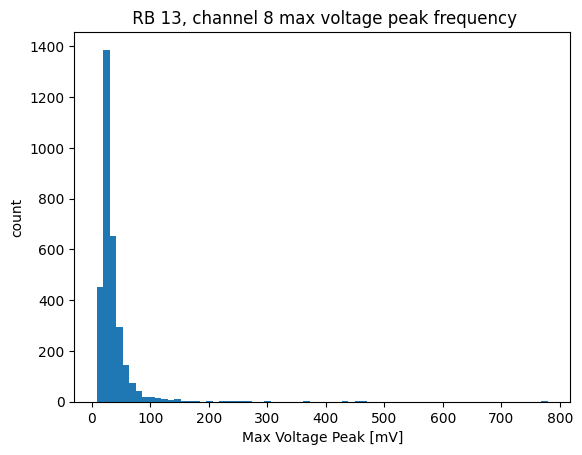

 28%|███████████████████████████████▋                                                                                   | 88/320 [00:23<00:57,  4.01it/s]

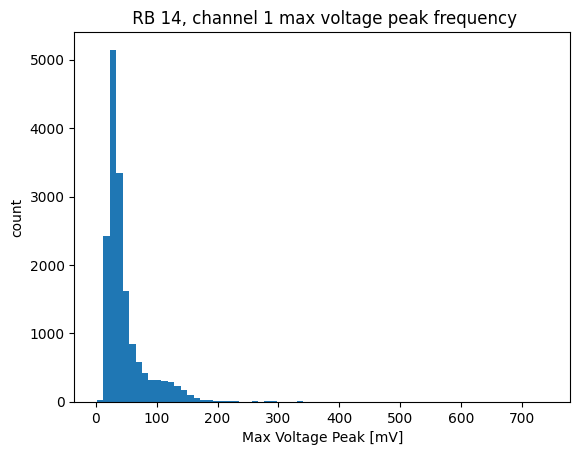

 28%|███████████████████████████████▉                                                                                   | 89/320 [00:23<00:58,  3.96it/s]

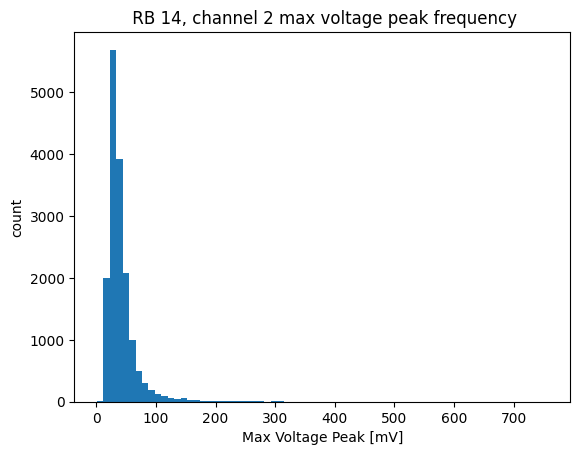

 28%|████████████████████████████████▎                                                                                  | 90/320 [00:24<00:58,  3.93it/s]

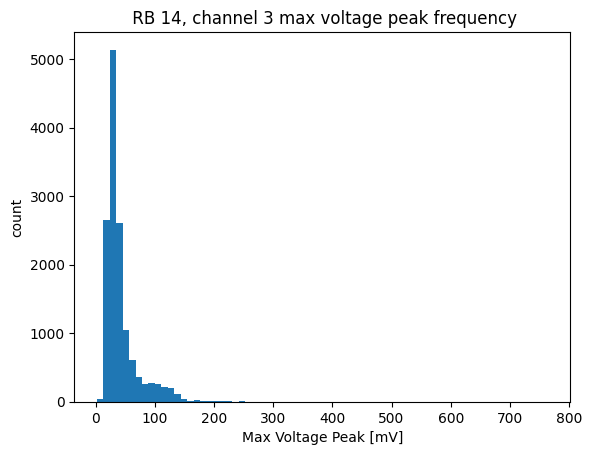

 28%|████████████████████████████████▋                                                                                  | 91/320 [00:24<00:58,  3.93it/s]

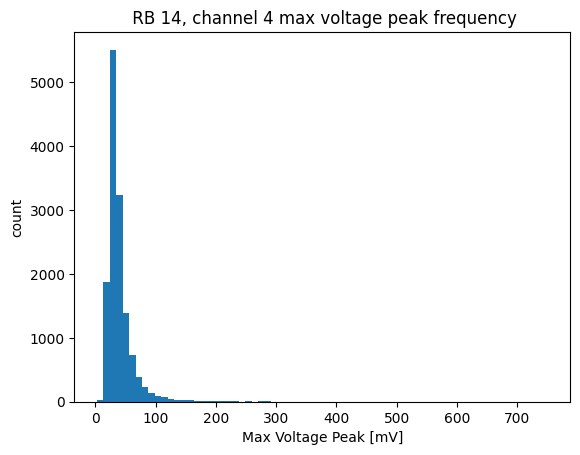

 29%|█████████████████████████████████                                                                                  | 92/320 [00:24<00:57,  3.94it/s]

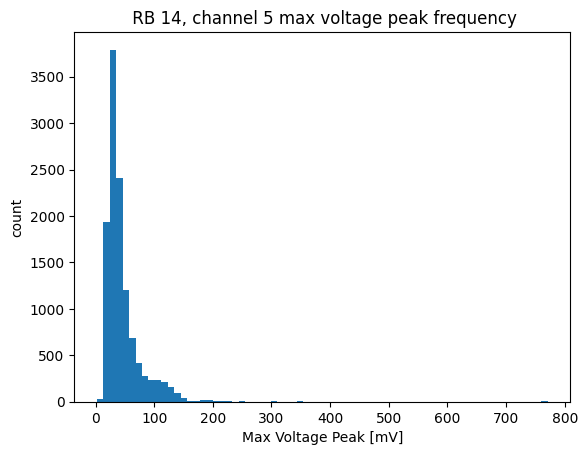

 29%|█████████████████████████████████▍                                                                                 | 93/320 [00:24<00:58,  3.87it/s]

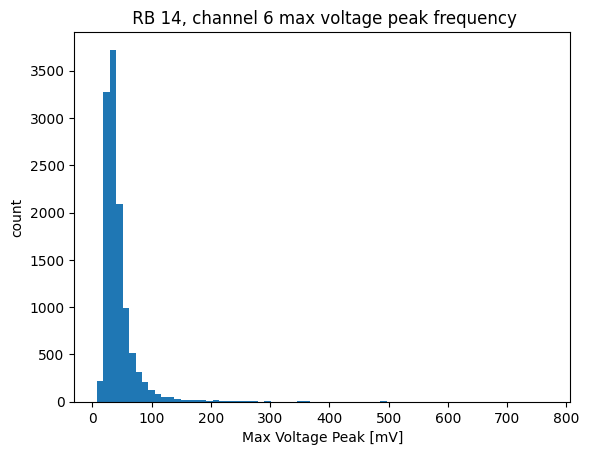

 29%|█████████████████████████████████▊                                                                                 | 94/320 [00:25<00:58,  3.84it/s]

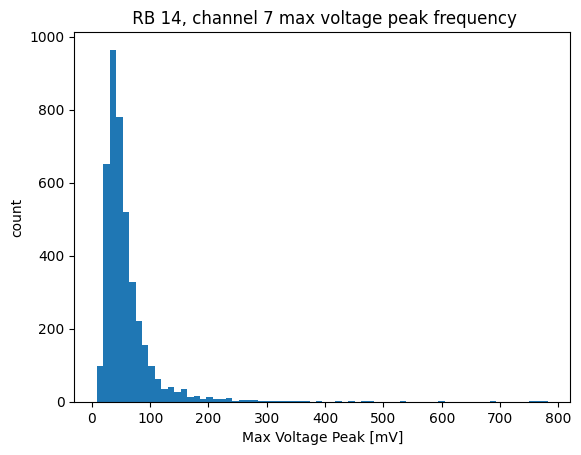

 30%|██████████████████████████████████▏                                                                                | 95/320 [00:25<00:56,  3.99it/s]

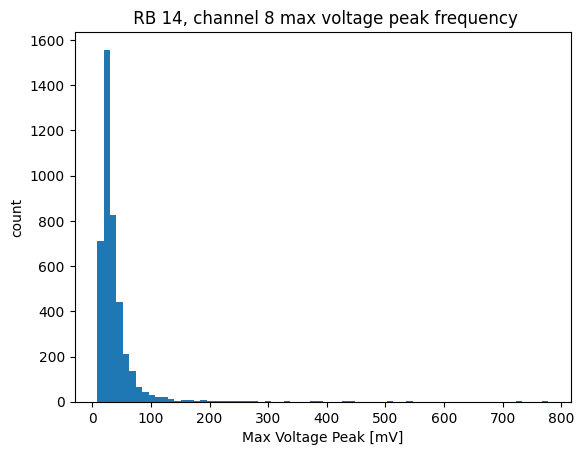

 30%|██████████████████████████████████▌                                                                                | 96/320 [00:25<00:55,  4.02it/s]

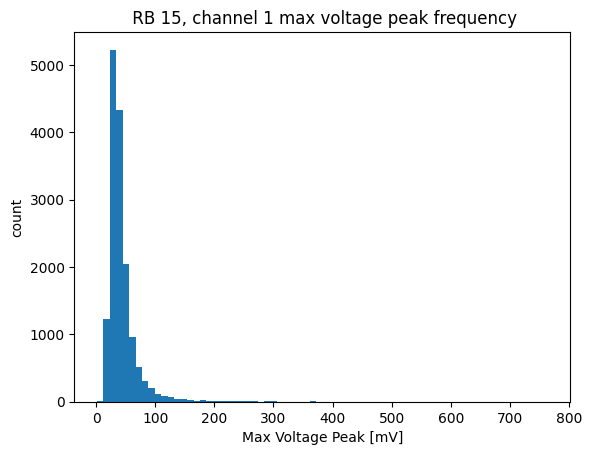

 30%|██████████████████████████████████▊                                                                                | 97/320 [00:25<00:56,  3.97it/s]

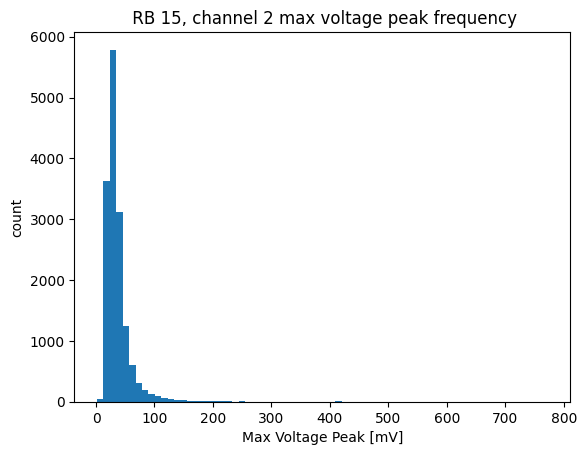

 31%|███████████████████████████████████▏                                                                               | 98/320 [00:26<01:20,  2.77it/s]

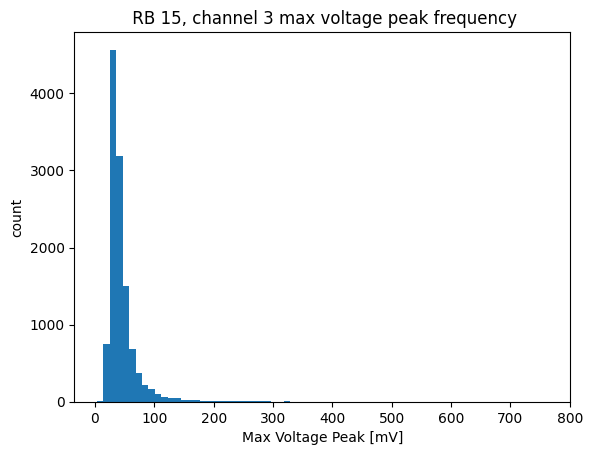

 31%|███████████████████████████████████▌                                                                               | 99/320 [00:26<01:12,  3.05it/s]

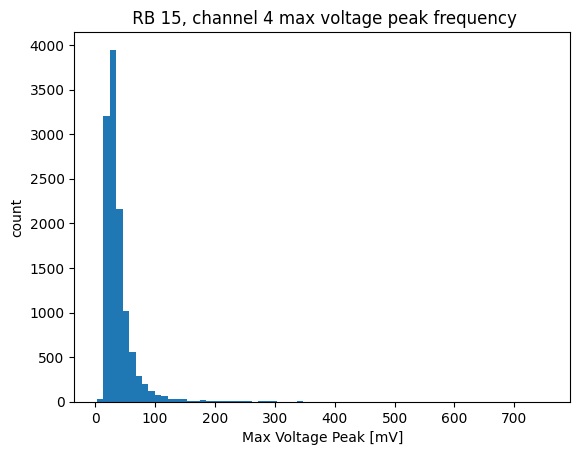

 31%|███████████████████████████████████▋                                                                              | 100/320 [00:26<01:08,  3.22it/s]

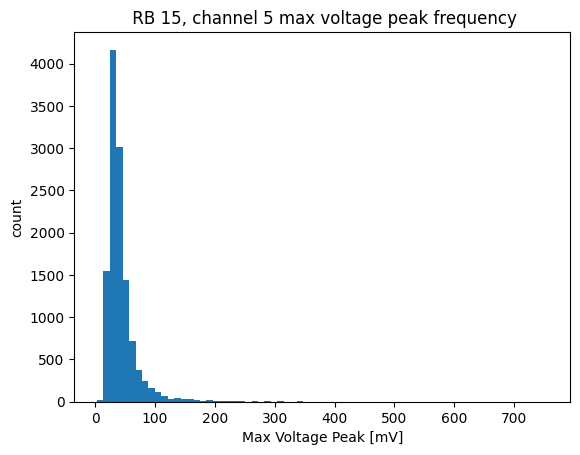

 32%|███████████████████████████████████▉                                                                              | 101/320 [00:27<01:04,  3.37it/s]

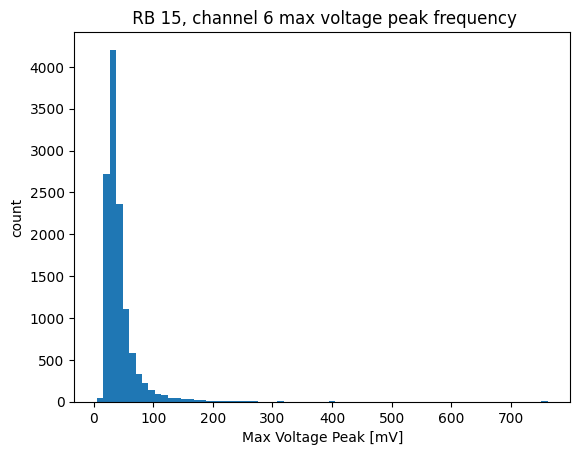

 32%|████████████████████████████████████▎                                                                             | 102/320 [00:27<01:02,  3.49it/s]

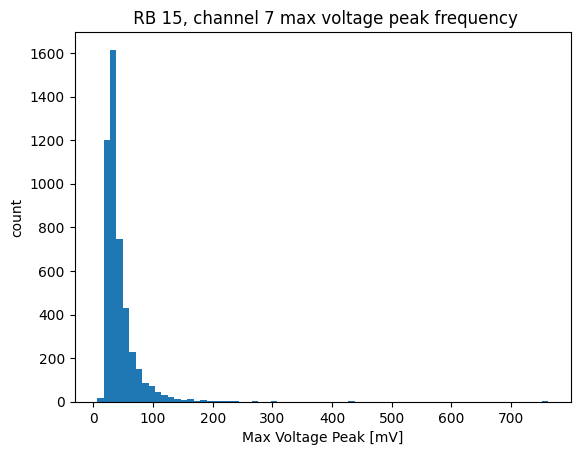

 32%|████████████████████████████████████▋                                                                             | 103/320 [00:27<00:59,  3.66it/s]

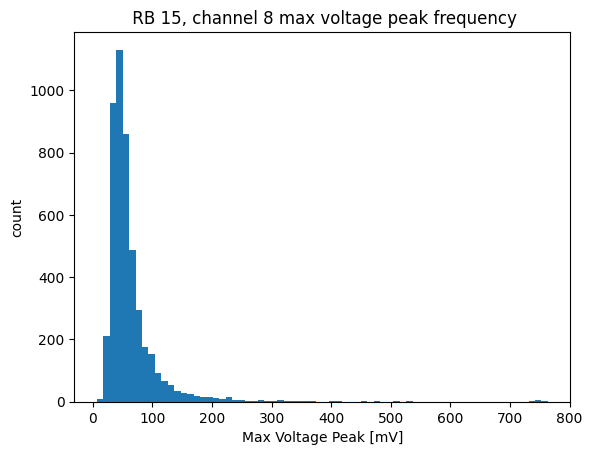

 32%|█████████████████████████████████████                                                                             | 104/320 [00:27<00:56,  3.85it/s]

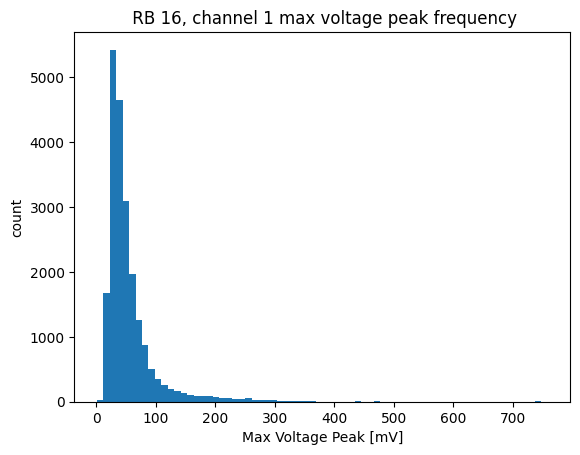

 33%|█████████████████████████████████████▍                                                                            | 105/320 [00:28<00:56,  3.80it/s]

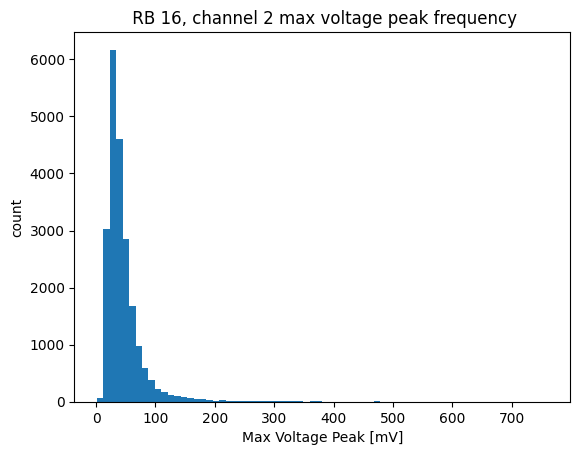

 33%|█████████████████████████████████████▊                                                                            | 106/320 [00:28<00:57,  3.74it/s]

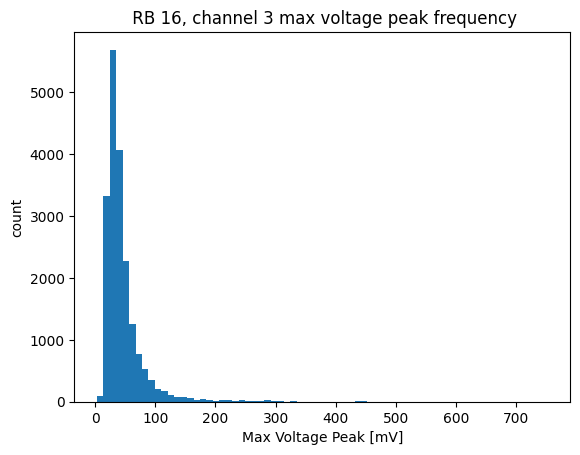

 33%|██████████████████████████████████████                                                                            | 107/320 [00:28<00:56,  3.75it/s]

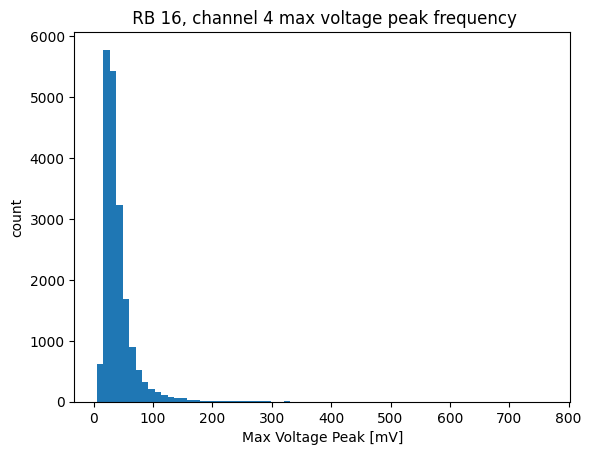

 34%|██████████████████████████████████████▍                                                                           | 108/320 [00:29<00:57,  3.70it/s]

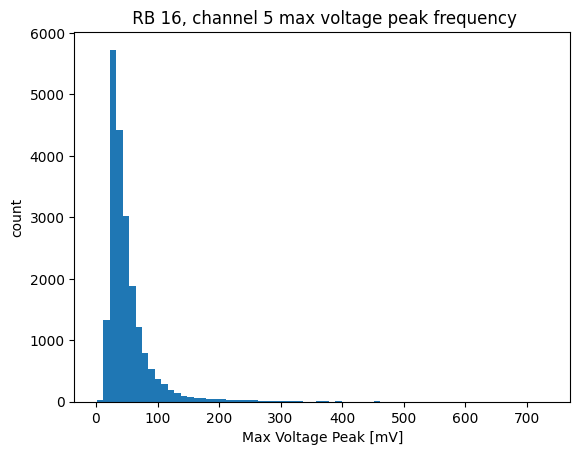

 34%|██████████████████████████████████████▊                                                                           | 109/320 [00:29<00:57,  3.67it/s]

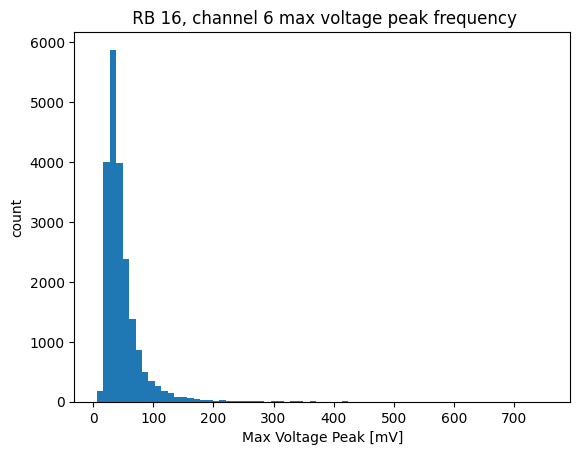

 34%|███████████████████████████████████████▏                                                                          | 110/320 [00:29<00:57,  3.65it/s]

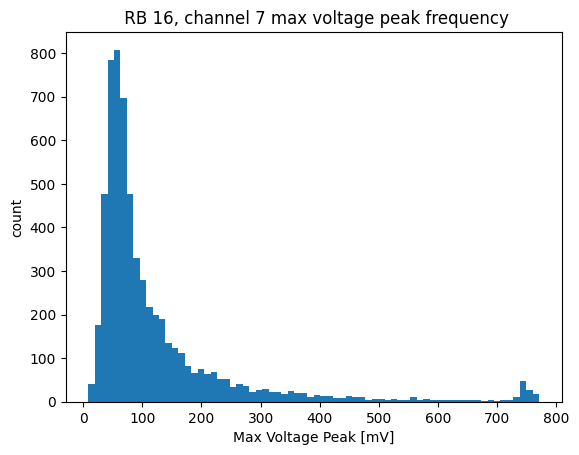

 35%|███████████████████████████████████████▌                                                                          | 111/320 [00:29<00:55,  3.74it/s]

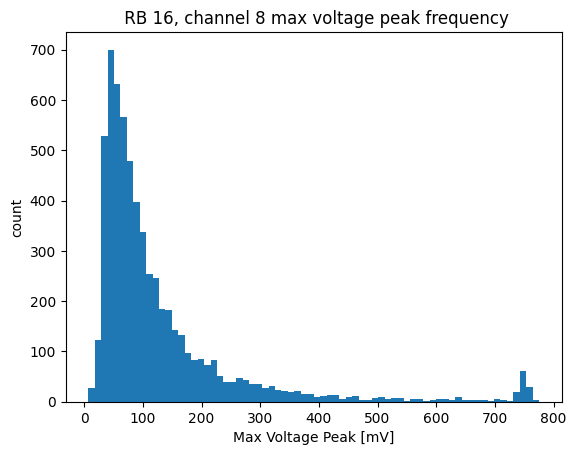

 35%|███████████████████████████████████████▉                                                                          | 112/320 [00:30<01:15,  2.75it/s]

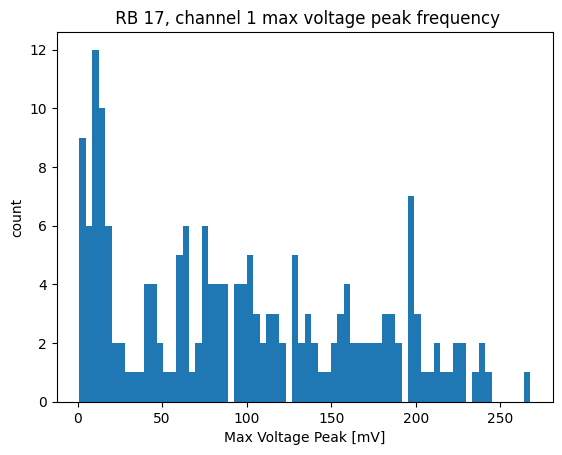

 35%|████████████████████████████████████████▎                                                                         | 113/320 [00:30<01:05,  3.15it/s]

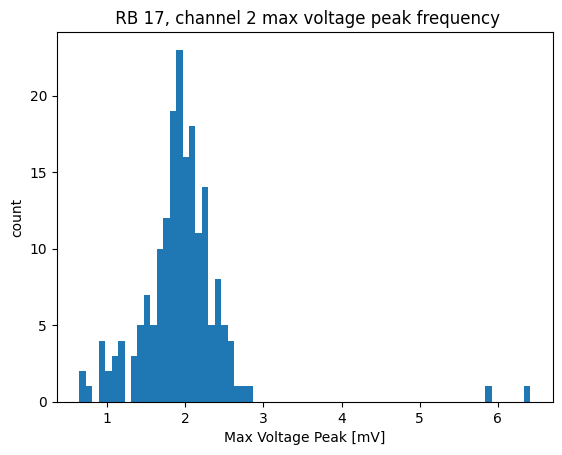

 36%|████████████████████████████████████████▌                                                                         | 114/320 [00:30<00:58,  3.55it/s]

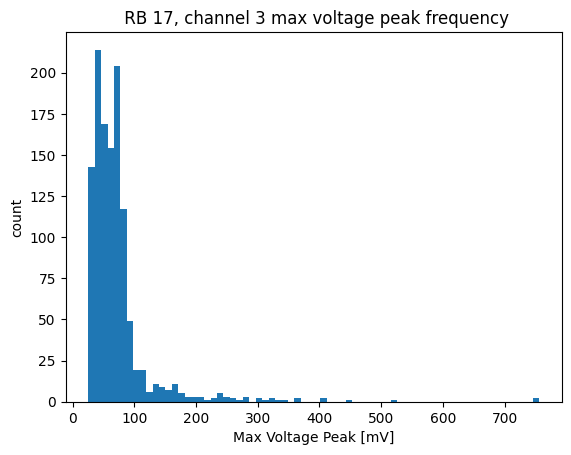

 36%|████████████████████████████████████████▉                                                                         | 115/320 [00:31<00:54,  3.78it/s]

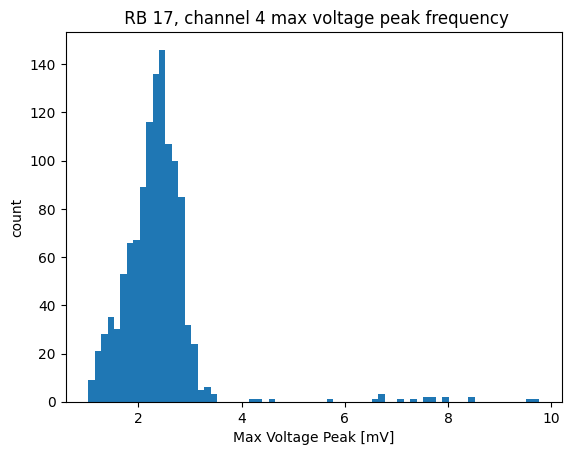

 36%|█████████████████████████████████████████▎                                                                        | 116/320 [00:31<00:50,  4.01it/s]

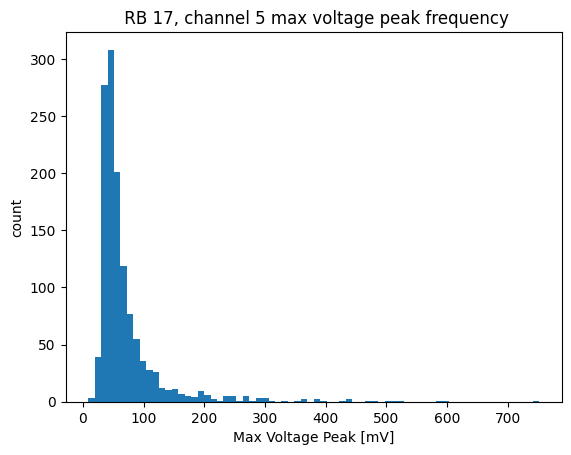

 37%|█████████████████████████████████████████▋                                                                        | 117/320 [00:31<00:48,  4.17it/s]

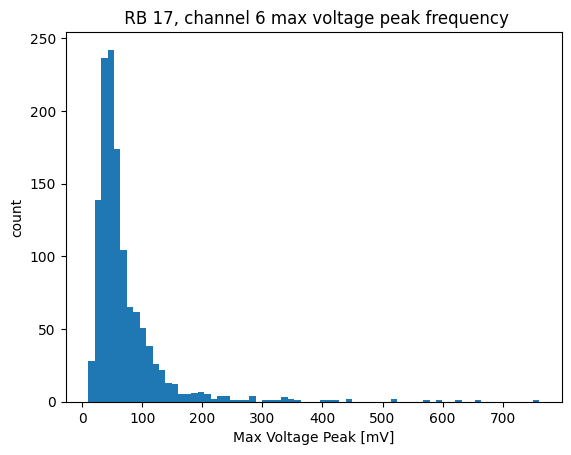

 37%|██████████████████████████████████████████                                                                        | 118/320 [00:31<00:47,  4.28it/s]

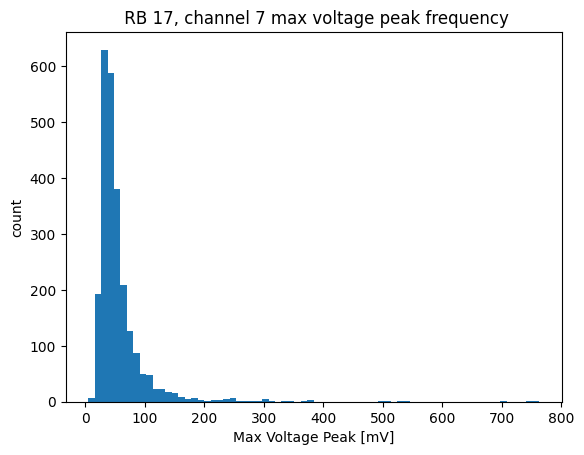

 37%|██████████████████████████████████████████▍                                                                       | 119/320 [00:31<00:46,  4.31it/s]

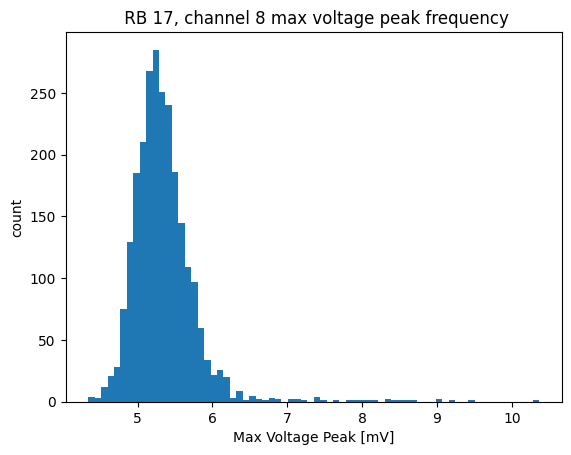

 38%|██████████████████████████████████████████▊                                                                       | 120/320 [00:32<00:45,  4.44it/s]

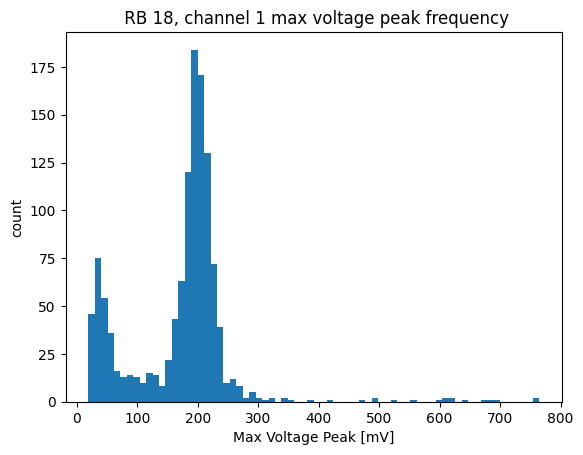

 38%|███████████████████████████████████████████                                                                       | 121/320 [00:32<00:45,  4.41it/s]

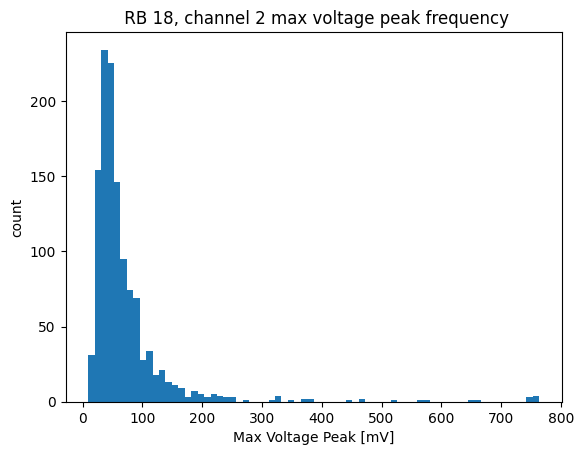

 38%|███████████████████████████████████████████▍                                                                      | 122/320 [00:32<00:44,  4.49it/s]

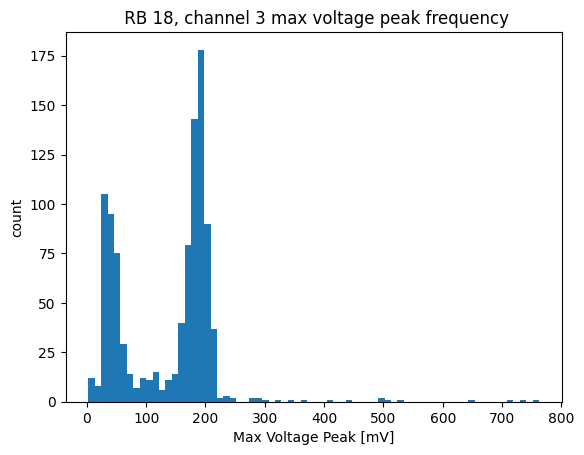

 38%|███████████████████████████████████████████▊                                                                      | 123/320 [00:32<00:44,  4.41it/s]

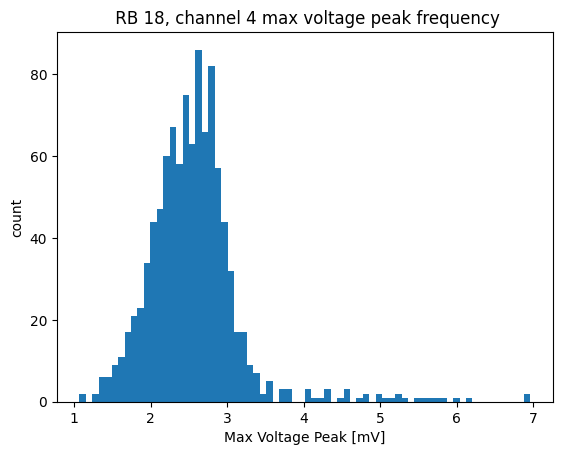

 39%|████████████████████████████████████████████▏                                                                     | 124/320 [00:33<00:43,  4.54it/s]

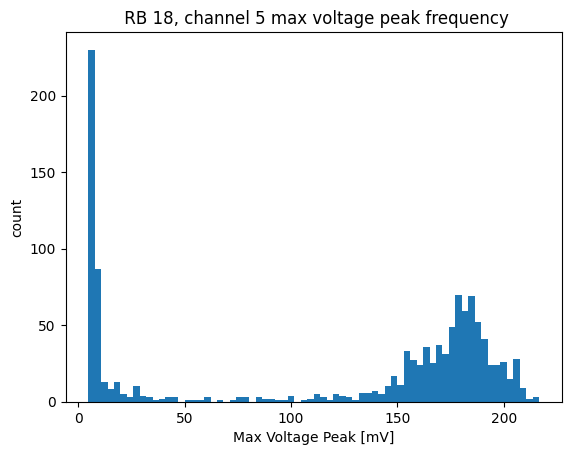

 39%|████████████████████████████████████████████▌                                                                     | 125/320 [00:33<00:41,  4.66it/s]

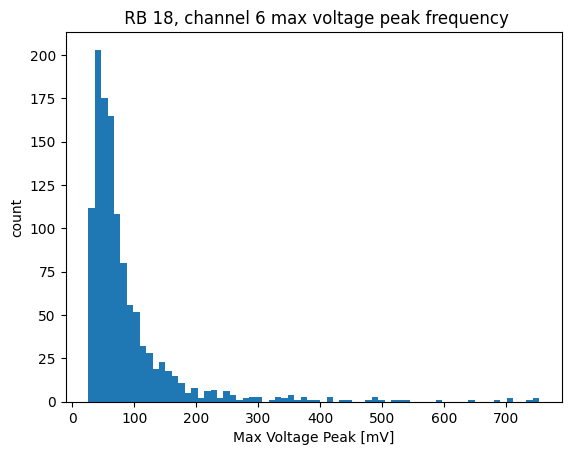

 39%|████████████████████████████████████████████▉                                                                     | 126/320 [00:33<00:42,  4.56it/s]

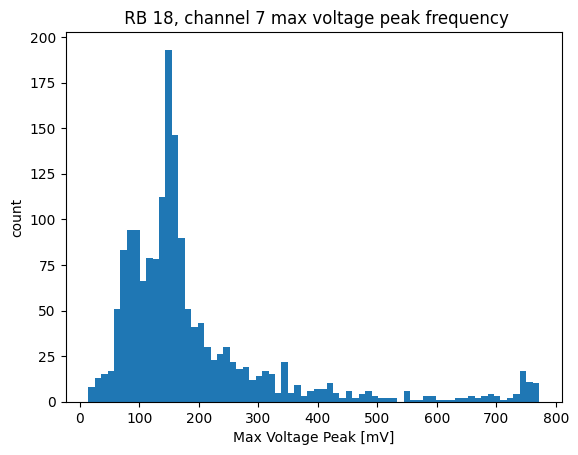

 40%|█████████████████████████████████████████████▏                                                                    | 127/320 [00:34<01:03,  3.04it/s]

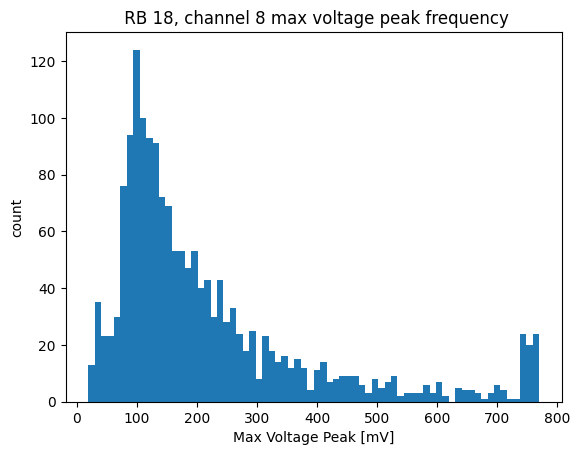

 40%|█████████████████████████████████████████████▌                                                                    | 128/320 [00:34<00:57,  3.35it/s]

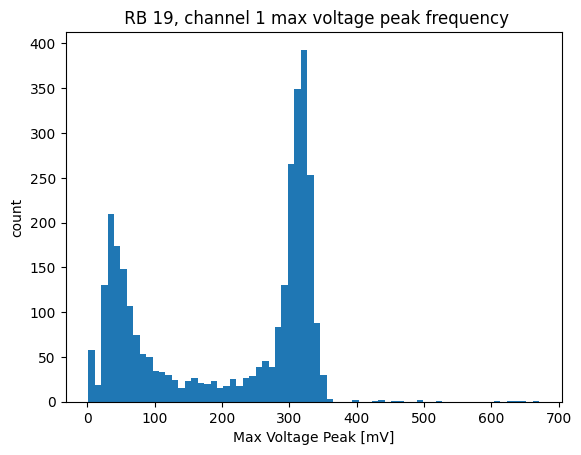

 40%|█████████████████████████████████████████████▉                                                                    | 129/320 [00:34<00:53,  3.54it/s]

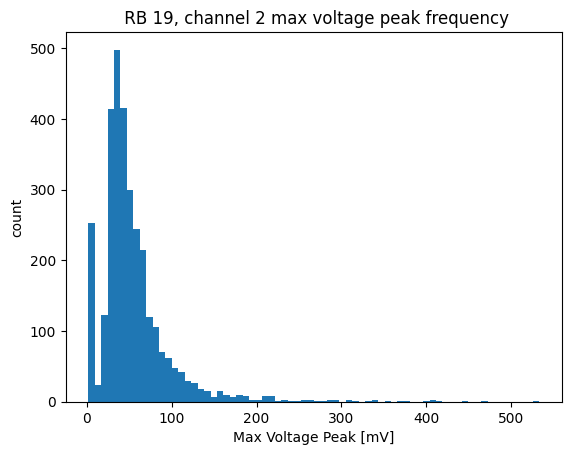

 41%|██████████████████████████████████████████████▎                                                                   | 130/320 [00:34<00:50,  3.80it/s]

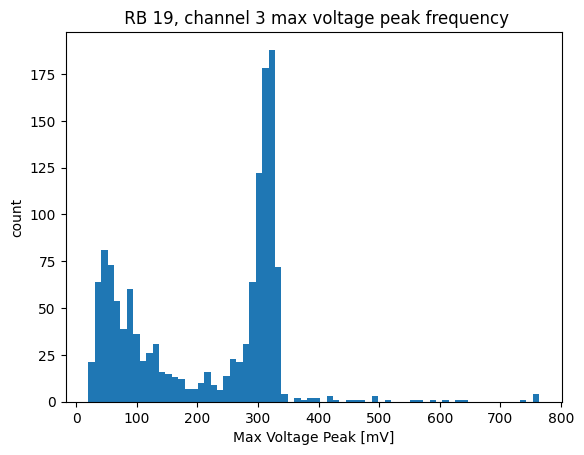

 41%|██████████████████████████████████████████████▋                                                                   | 131/320 [00:34<00:47,  3.94it/s]

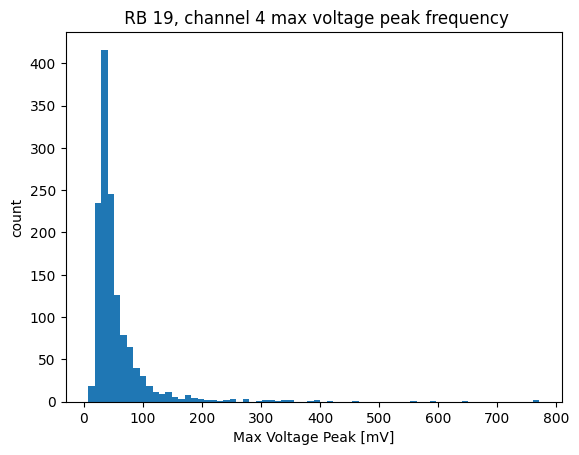

 41%|███████████████████████████████████████████████                                                                   | 132/320 [00:35<00:46,  4.02it/s]

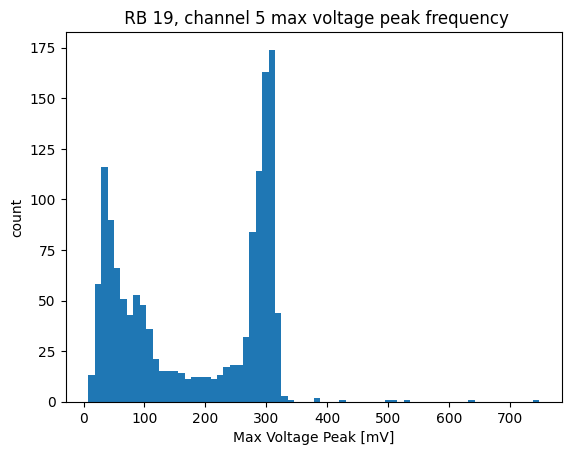

 42%|███████████████████████████████████████████████▍                                                                  | 133/320 [00:35<00:45,  4.11it/s]

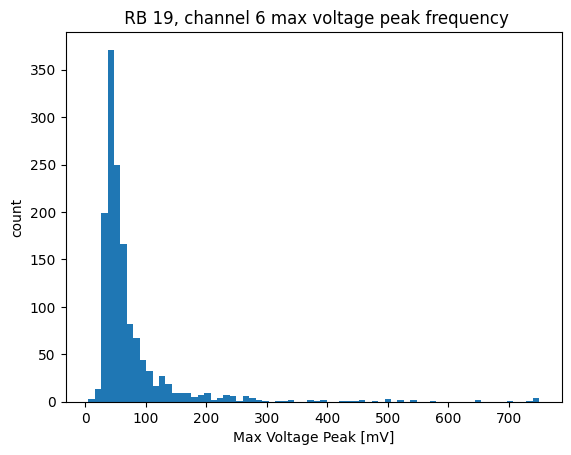

 42%|███████████████████████████████████████████████▋                                                                  | 134/320 [00:35<00:44,  4.18it/s]

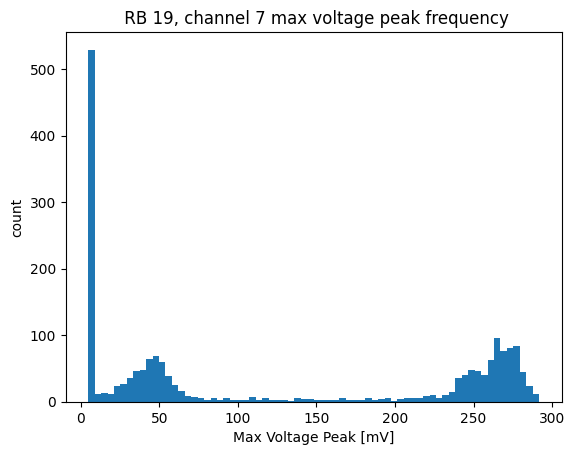

 42%|████████████████████████████████████████████████                                                                  | 135/320 [00:35<00:42,  4.31it/s]

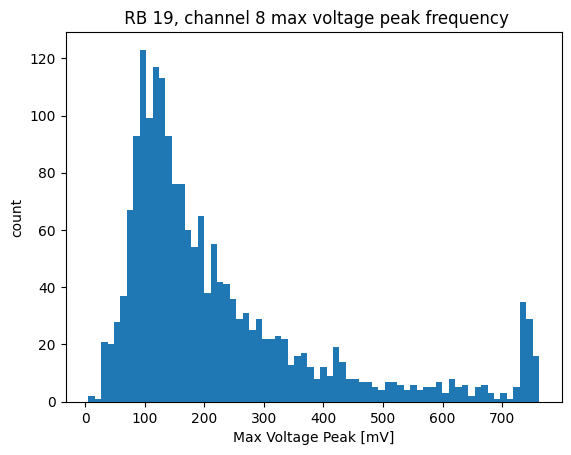

 42%|████████████████████████████████████████████████▍                                                                 | 136/320 [00:36<00:42,  4.36it/s]

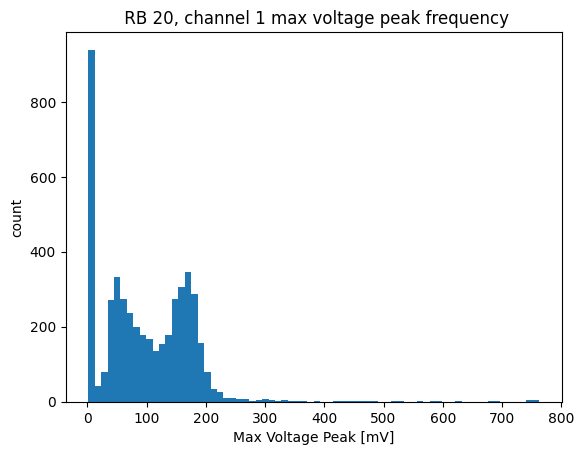

 43%|████████████████████████████████████████████████▊                                                                 | 137/320 [00:36<00:41,  4.40it/s]

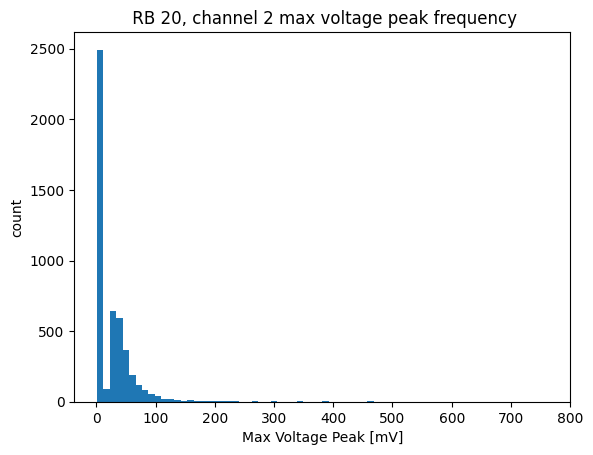

 43%|█████████████████████████████████████████████████▏                                                                | 138/320 [00:36<00:41,  4.36it/s]

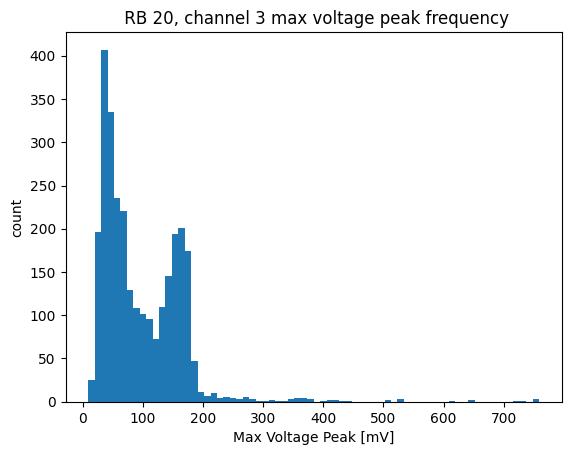

 43%|█████████████████████████████████████████████████▌                                                                | 139/320 [00:36<00:41,  4.32it/s]

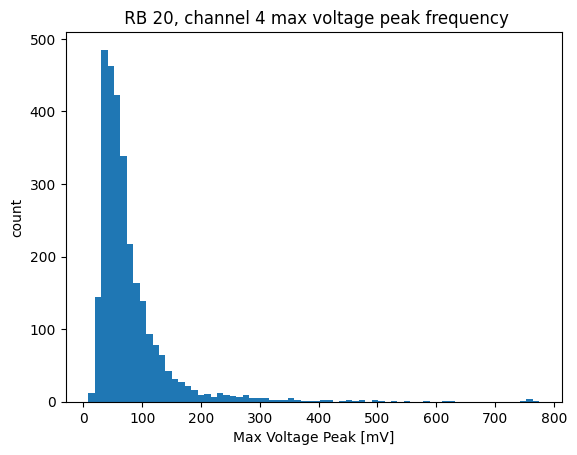

 44%|█████████████████████████████████████████████████▉                                                                | 140/320 [00:37<00:41,  4.34it/s]

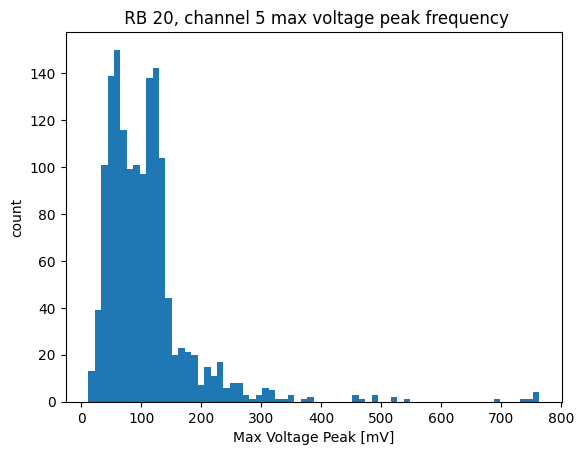

 44%|██████████████████████████████████████████████████▏                                                               | 141/320 [00:37<00:59,  3.00it/s]

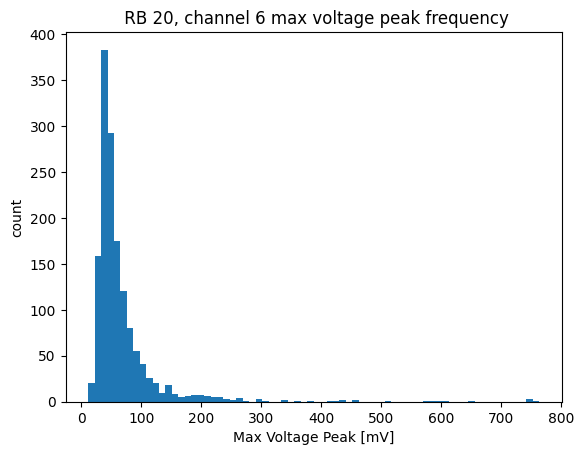

 44%|██████████████████████████████████████████████████▌                                                               | 142/320 [00:37<00:54,  3.28it/s]

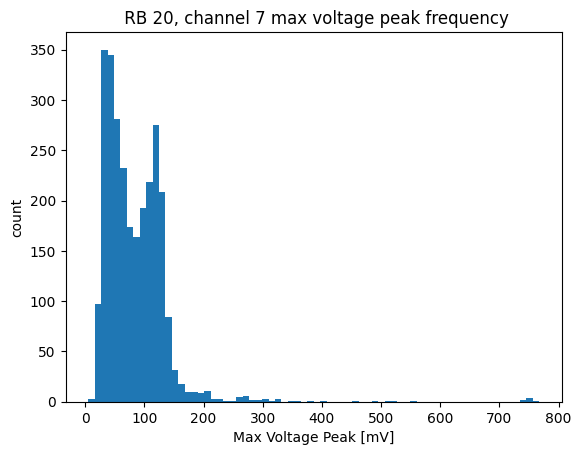

 45%|██████████████████████████████████████████████████▉                                                               | 143/320 [00:38<00:51,  3.47it/s]

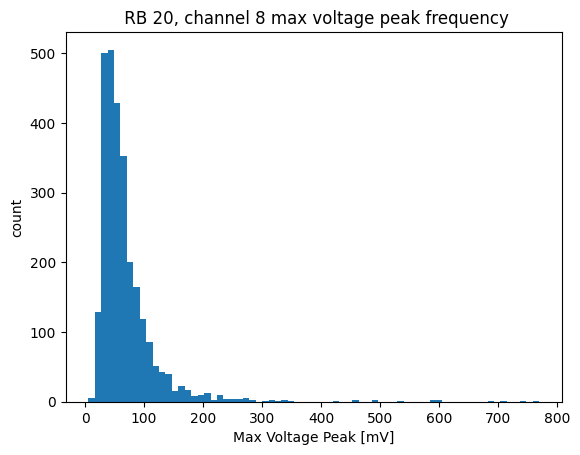

 45%|███████████████████████████████████████████████████▎                                                              | 144/320 [00:38<00:47,  3.70it/s]

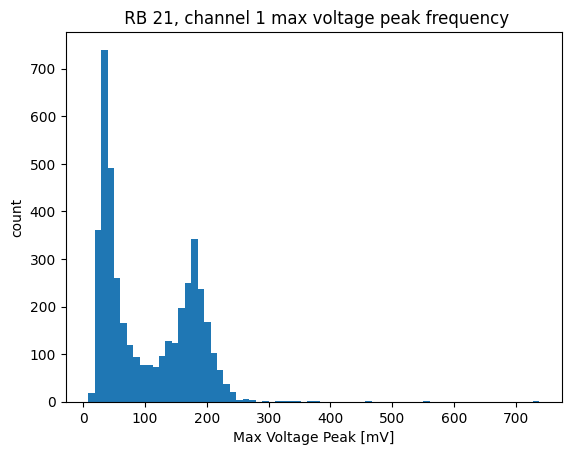

 45%|███████████████████████████████████████████████████▋                                                              | 145/320 [00:38<00:45,  3.85it/s]

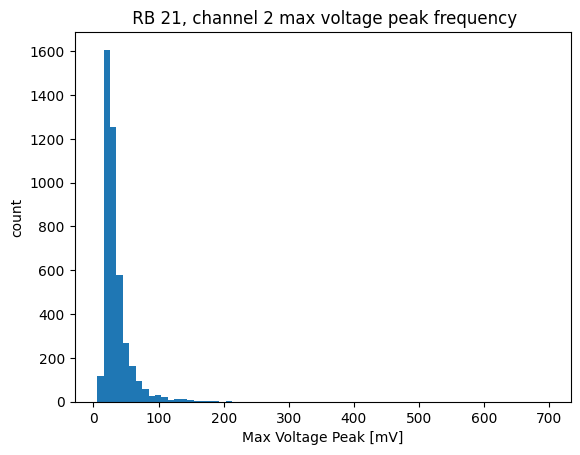

 46%|████████████████████████████████████████████████████                                                              | 146/320 [00:38<00:44,  3.92it/s]

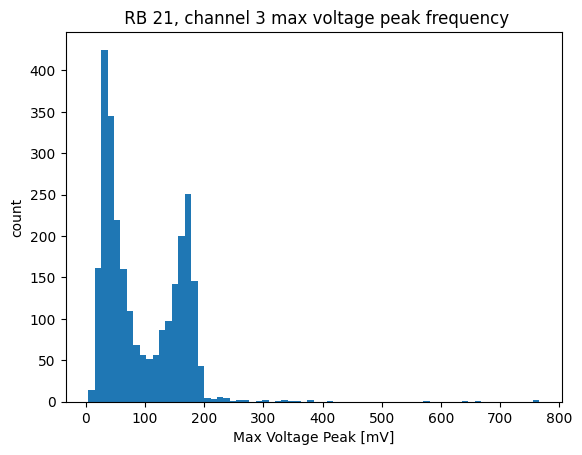

 46%|████████████████████████████████████████████████████▎                                                             | 147/320 [00:39<00:43,  3.93it/s]

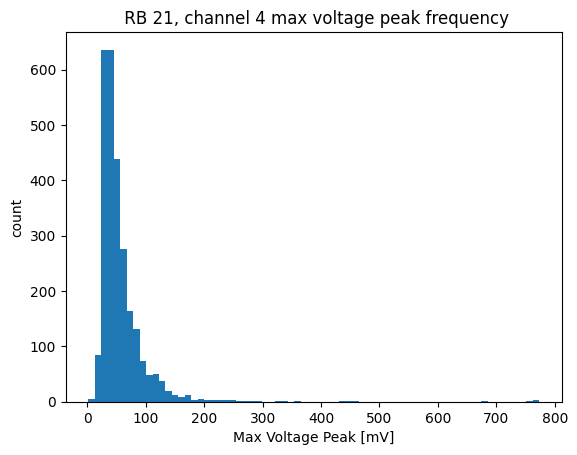

 46%|████████████████████████████████████████████████████▋                                                             | 148/320 [00:39<00:42,  4.06it/s]

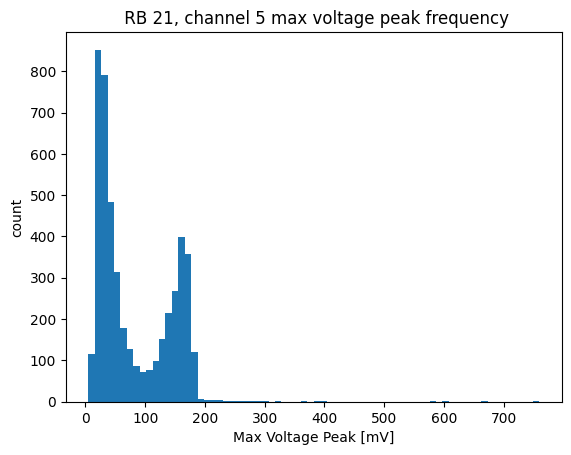

 47%|█████████████████████████████████████████████████████                                                             | 149/320 [00:39<00:41,  4.09it/s]

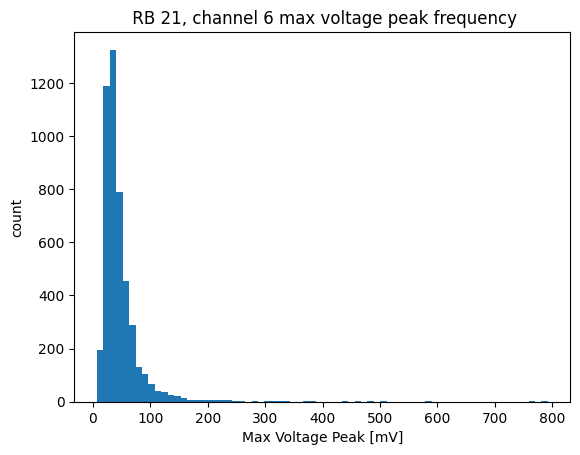

 47%|█████████████████████████████████████████████████████▍                                                            | 150/320 [00:39<00:41,  4.14it/s]

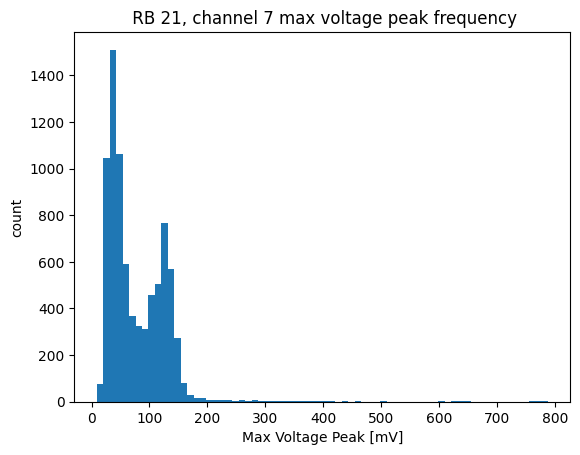

 47%|█████████████████████████████████████████████████████▊                                                            | 151/320 [00:40<00:41,  4.09it/s]

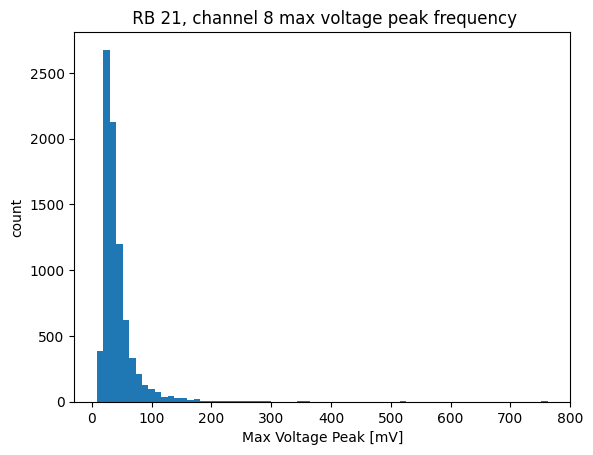

 48%|██████████████████████████████████████████████████████▏                                                           | 152/320 [00:40<00:40,  4.11it/s]

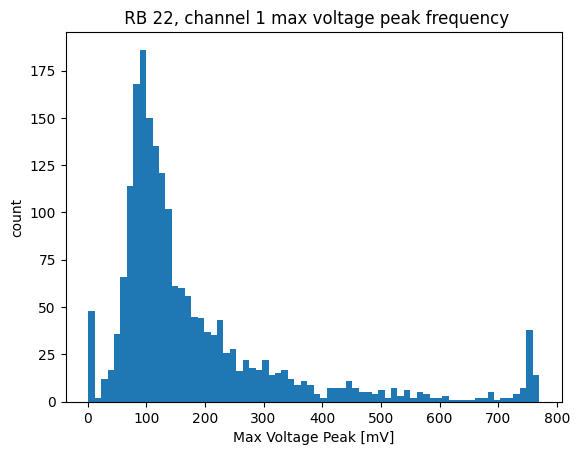

 48%|██████████████████████████████████████████████████████▌                                                           | 153/320 [00:40<00:40,  4.17it/s]

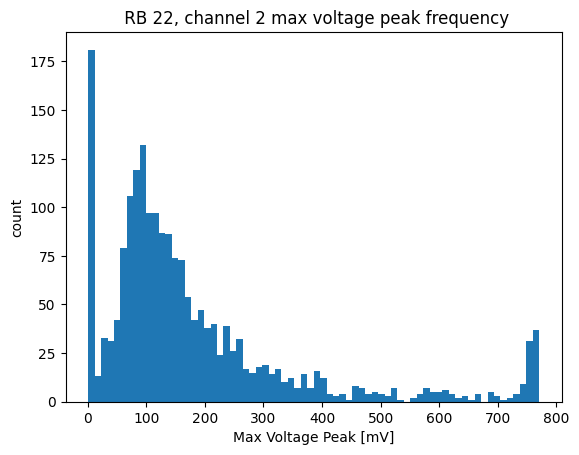

 48%|██████████████████████████████████████████████████████▊                                                           | 154/320 [00:40<00:39,  4.21it/s]

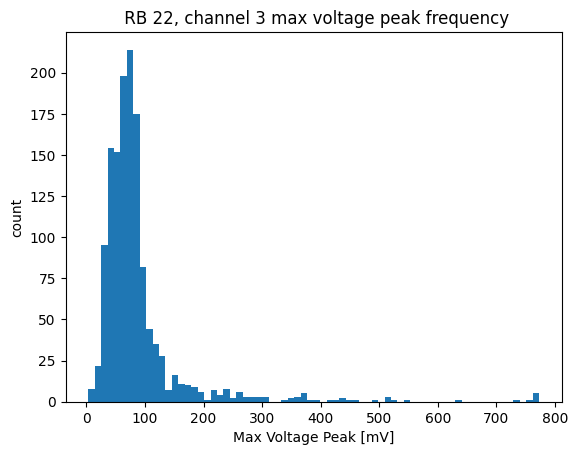

 48%|███████████████████████████████████████████████████████▏                                                          | 155/320 [00:40<00:39,  4.21it/s]

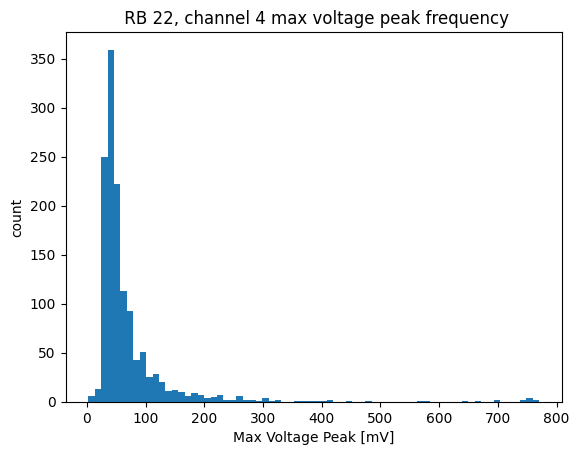

 49%|███████████████████████████████████████████████████████▌                                                          | 156/320 [00:41<00:56,  2.92it/s]

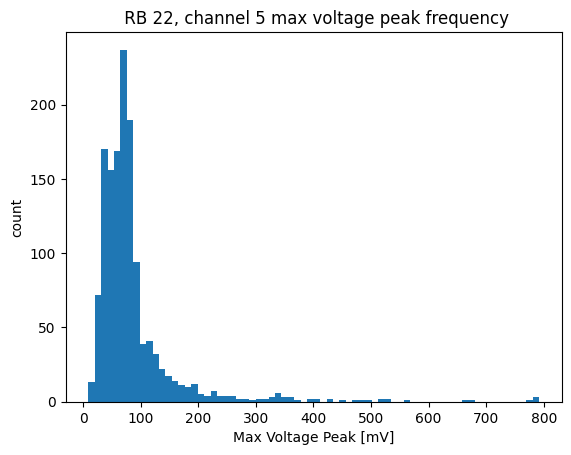

 49%|███████████████████████████████████████████████████████▉                                                          | 157/320 [00:41<00:49,  3.28it/s]

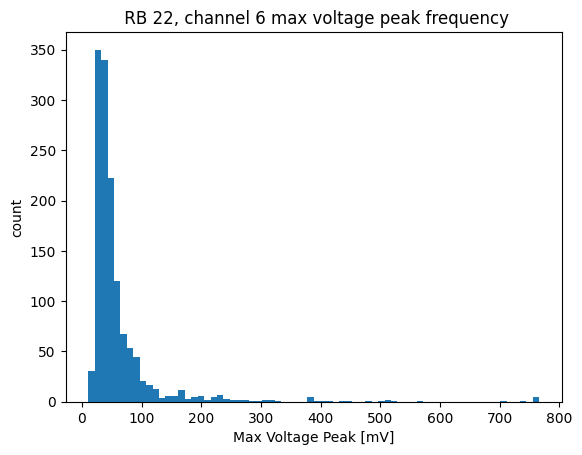

 49%|████████████████████████████████████████████████████████▎                                                         | 158/320 [00:41<00:45,  3.54it/s]

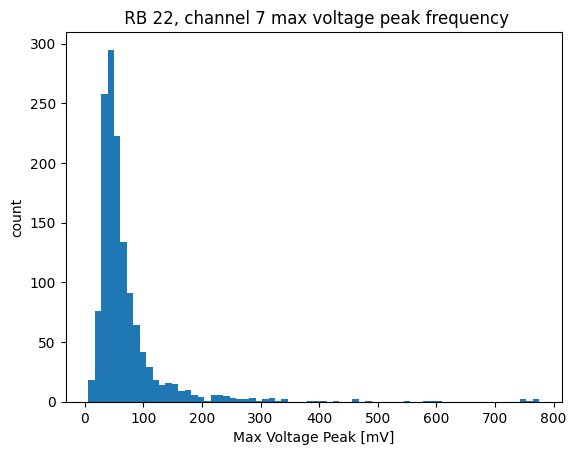

 50%|████████████████████████████████████████████████████████▋                                                         | 159/320 [00:42<00:42,  3.76it/s]

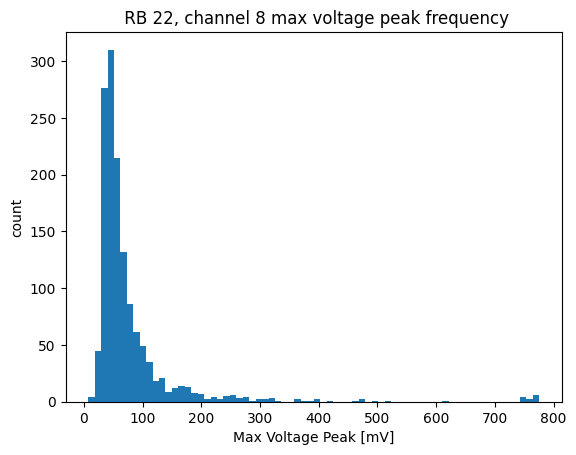

 50%|█████████████████████████████████████████████████████████                                                         | 160/320 [00:42<00:40,  3.94it/s]

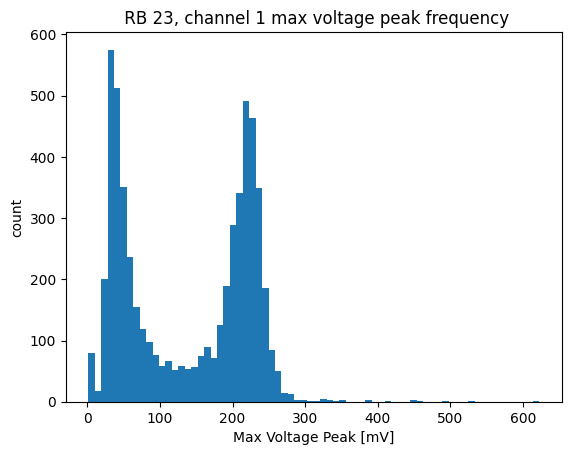

 50%|█████████████████████████████████████████████████████████▎                                                        | 161/320 [00:42<00:39,  4.04it/s]

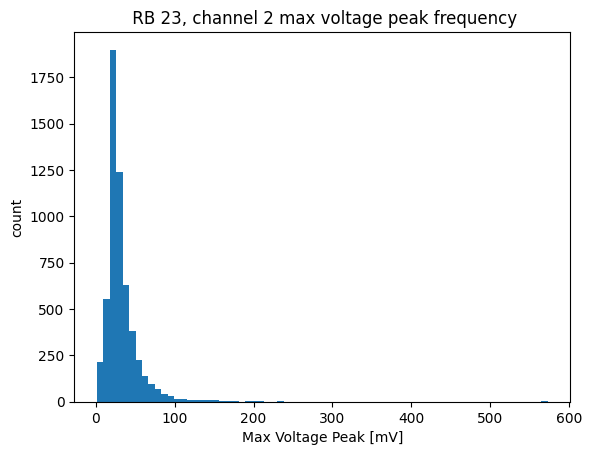

 51%|█████████████████████████████████████████████████████████▋                                                        | 162/320 [00:42<00:38,  4.09it/s]

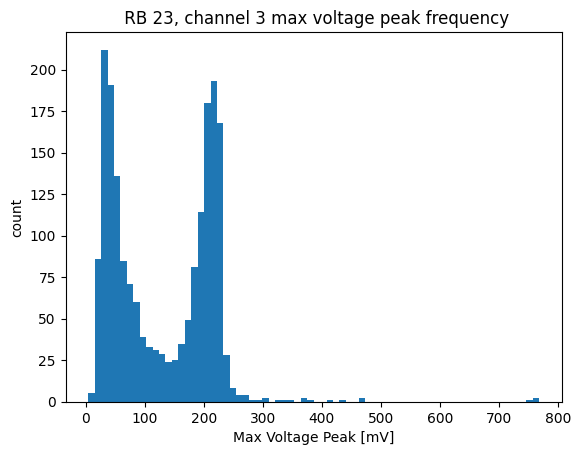

 51%|██████████████████████████████████████████████████████████                                                        | 163/320 [00:43<00:38,  4.11it/s]

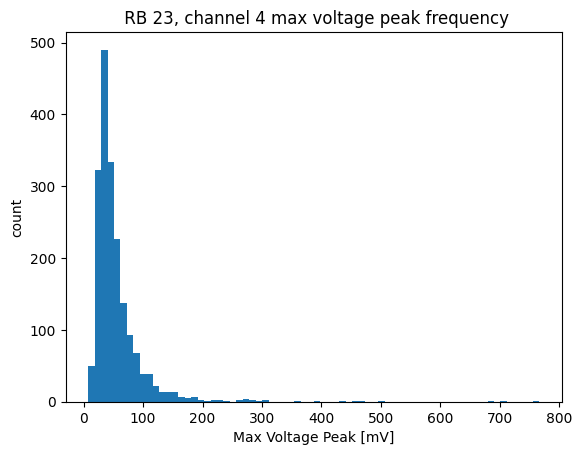

 51%|██████████████████████████████████████████████████████████▍                                                       | 164/320 [00:43<00:36,  4.22it/s]

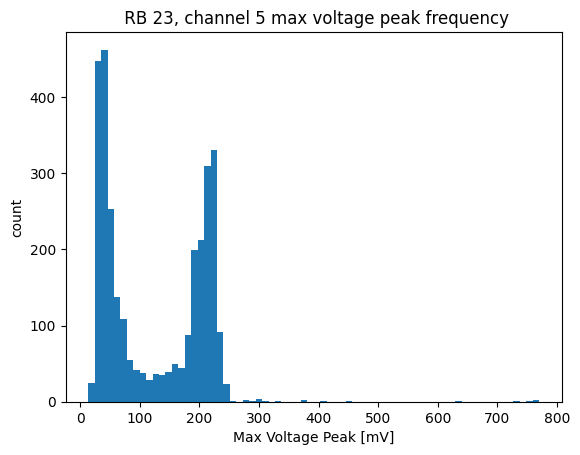

 52%|██████████████████████████████████████████████████████████▊                                                       | 165/320 [00:43<00:35,  4.32it/s]

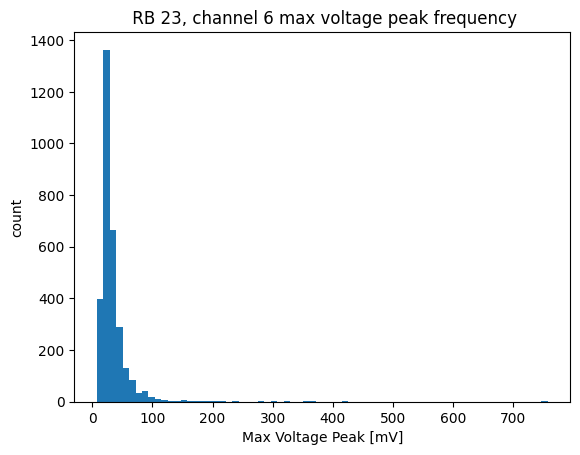

 52%|███████████████████████████████████████████████████████████▏                                                      | 166/320 [00:43<00:35,  4.32it/s]

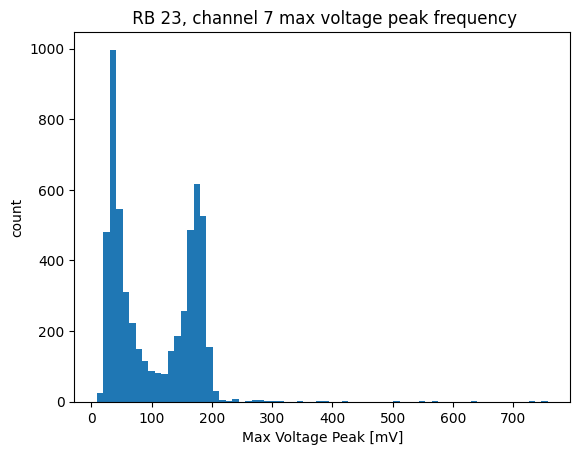

 52%|███████████████████████████████████████████████████████████▍                                                      | 167/320 [00:44<00:35,  4.34it/s]

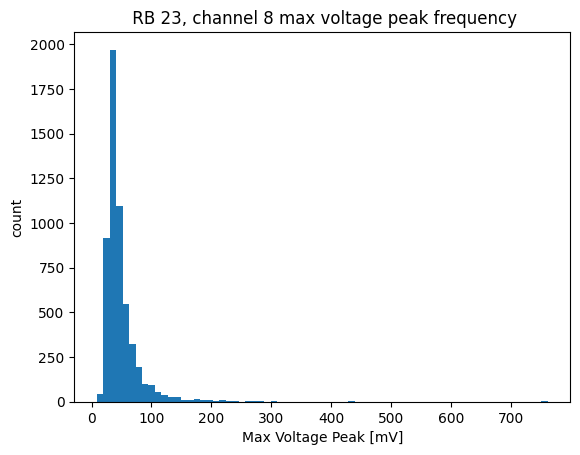

 52%|███████████████████████████████████████████████████████████▊                                                      | 168/320 [00:44<00:35,  4.25it/s]

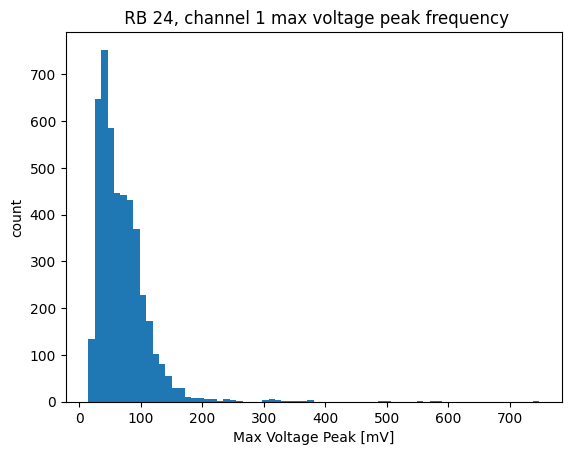

 53%|████████████████████████████████████████████████████████████▏                                                     | 169/320 [00:44<00:35,  4.26it/s]

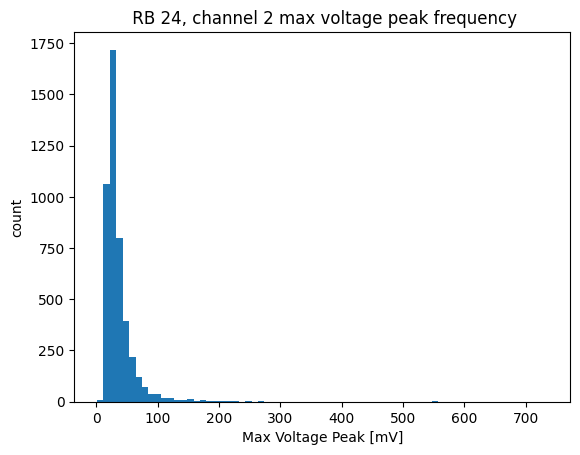

 53%|████████████████████████████████████████████████████████████▌                                                     | 170/320 [00:44<00:35,  4.24it/s]

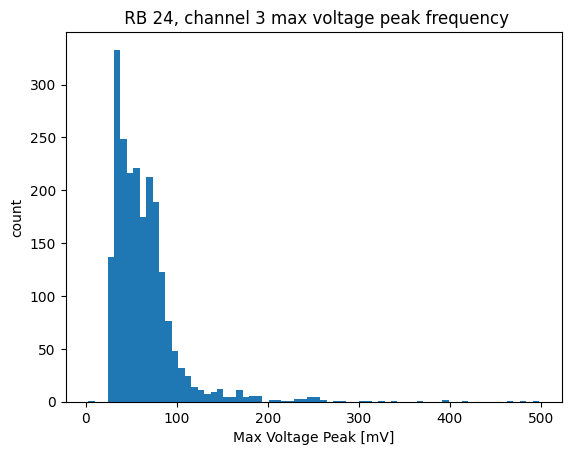

 53%|████████████████████████████████████████████████████████████▉                                                     | 171/320 [00:45<00:51,  2.88it/s]

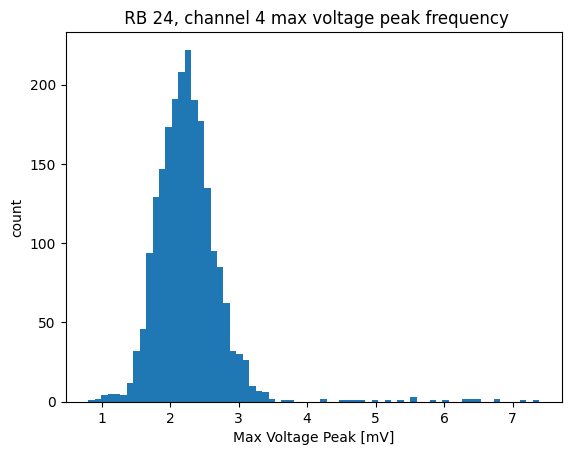

 54%|█████████████████████████████████████████████████████████████▎                                                    | 172/320 [00:45<00:45,  3.27it/s]

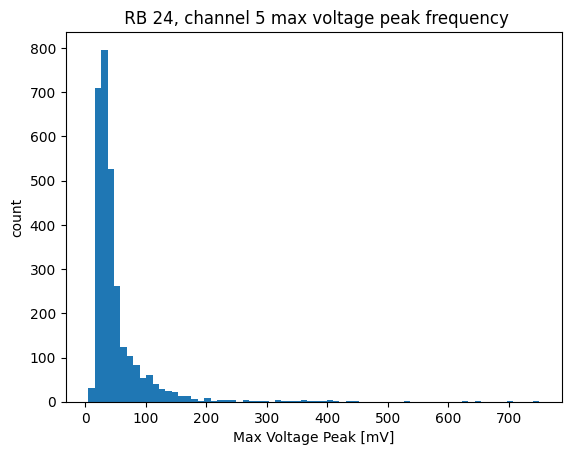

 54%|█████████████████████████████████████████████████████████████▋                                                    | 173/320 [00:45<00:41,  3.51it/s]

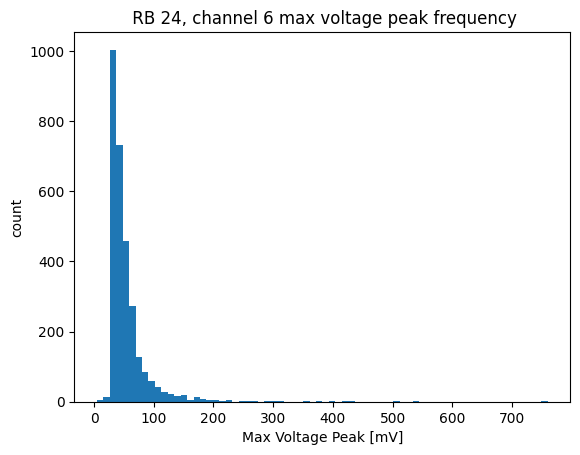

 54%|█████████████████████████████████████████████████████████████▉                                                    | 174/320 [00:46<00:38,  3.75it/s]

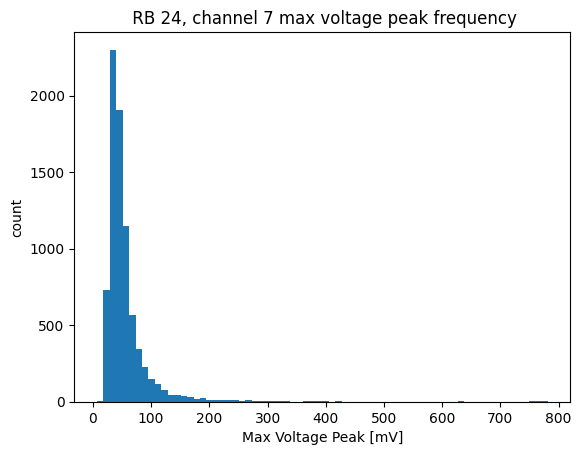

 55%|██████████████████████████████████████████████████████████████▎                                                   | 175/320 [00:46<00:37,  3.87it/s]

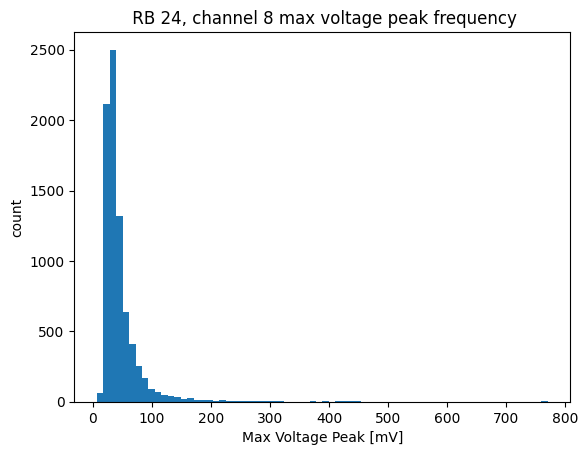

 55%|██████████████████████████████████████████████████████████████▋                                                   | 176/320 [00:46<00:36,  3.95it/s]

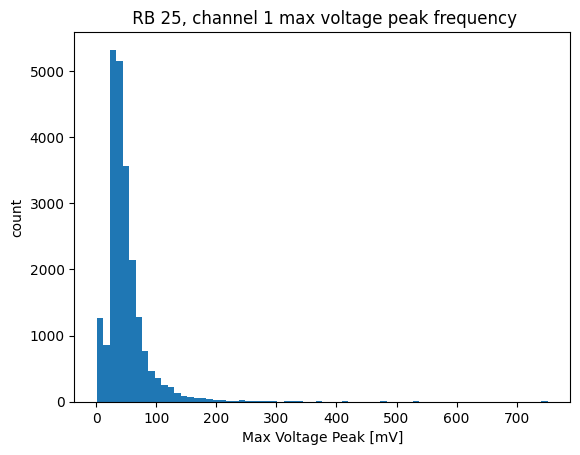

 55%|███████████████████████████████████████████████████████████████                                                   | 177/320 [00:46<00:37,  3.82it/s]

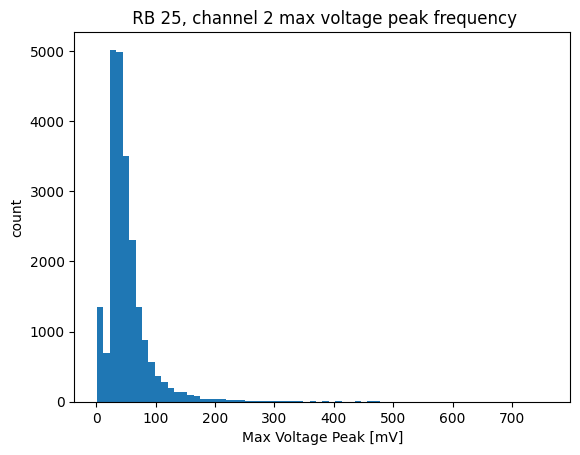

 56%|███████████████████████████████████████████████████████████████▍                                                  | 178/320 [00:47<00:37,  3.77it/s]

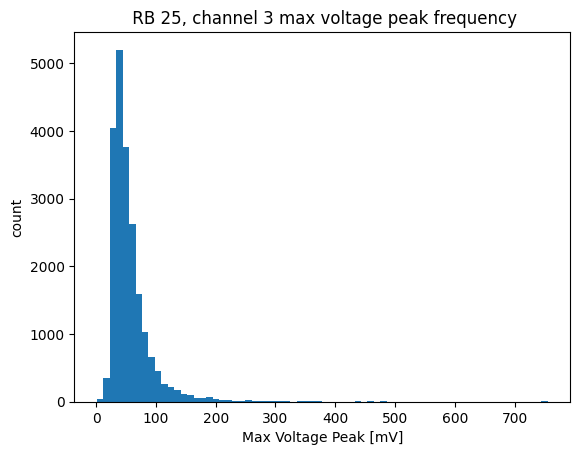

 56%|███████████████████████████████████████████████████████████████▊                                                  | 179/320 [00:47<00:37,  3.73it/s]

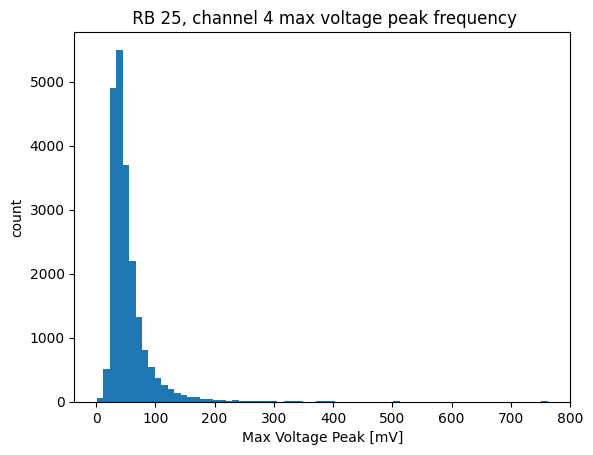

 56%|████████████████████████████████████████████████████████████████▏                                                 | 180/320 [00:47<00:38,  3.68it/s]

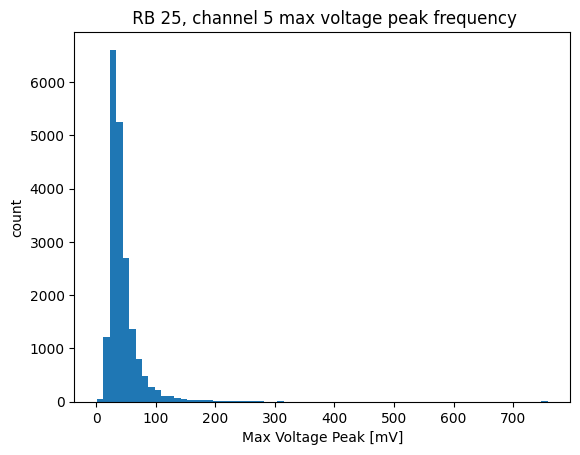

 57%|████████████████████████████████████████████████████████████████▍                                                 | 181/320 [00:47<00:37,  3.68it/s]

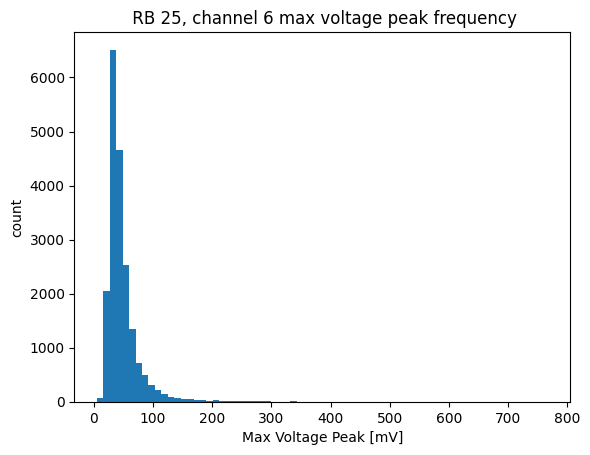

 57%|████████████████████████████████████████████████████████████████▊                                                 | 182/320 [00:48<00:37,  3.65it/s]

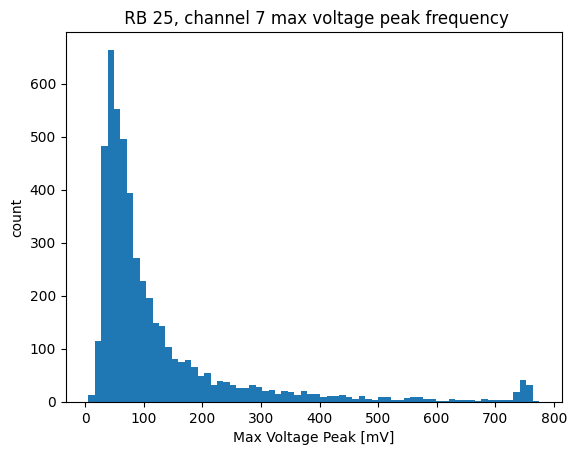

 57%|█████████████████████████████████████████████████████████████████▏                                                | 183/320 [00:48<00:35,  3.81it/s]

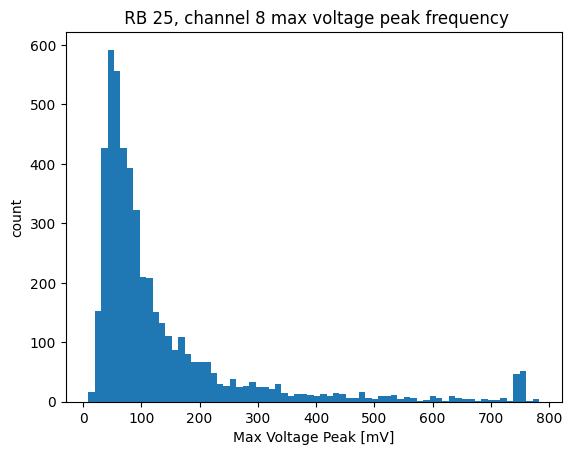

 57%|█████████████████████████████████████████████████████████████████▌                                                | 184/320 [00:48<00:34,  3.93it/s]

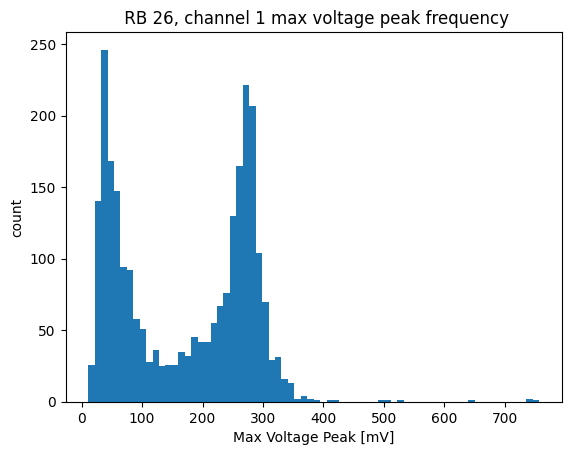

 58%|█████████████████████████████████████████████████████████████████▉                                                | 185/320 [00:49<00:47,  2.87it/s]

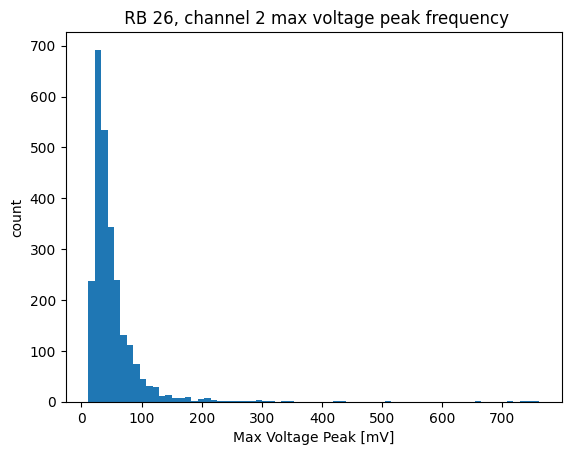

 58%|██████████████████████████████████████████████████████████████████▎                                               | 186/320 [00:49<00:41,  3.19it/s]

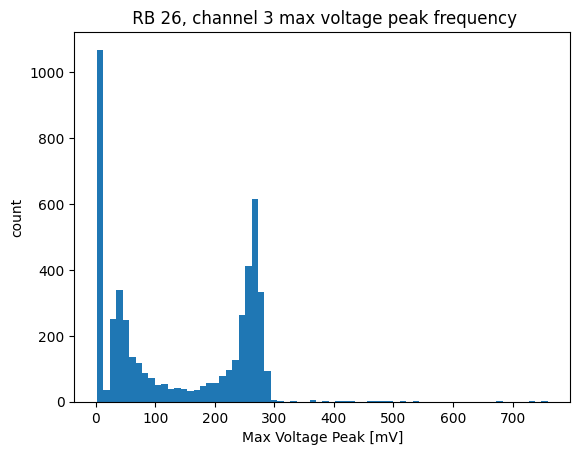

 58%|██████████████████████████████████████████████████████████████████▌                                               | 187/320 [00:49<00:38,  3.48it/s]

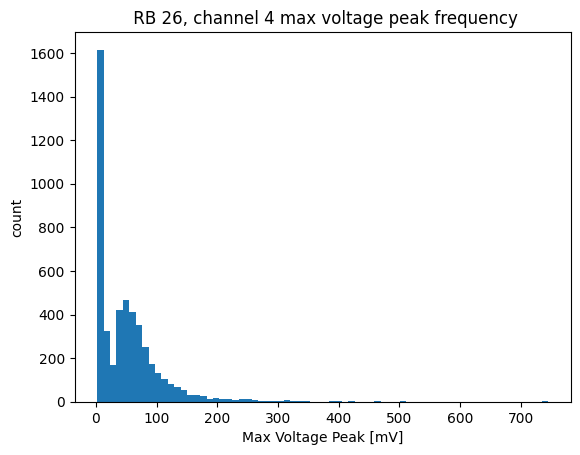

 59%|██████████████████████████████████████████████████████████████████▉                                               | 188/320 [00:49<00:36,  3.64it/s]

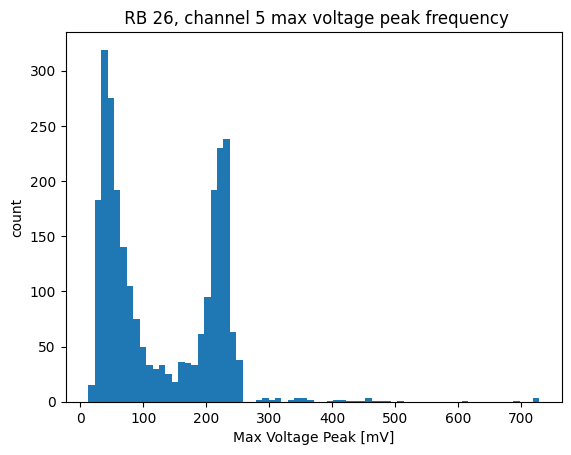

 59%|███████████████████████████████████████████████████████████████████▎                                              | 189/320 [00:50<00:34,  3.84it/s]

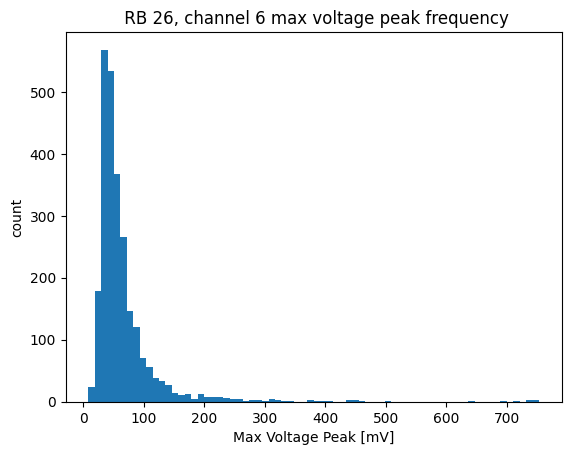

 59%|███████████████████████████████████████████████████████████████████▋                                              | 190/320 [00:50<00:32,  4.02it/s]

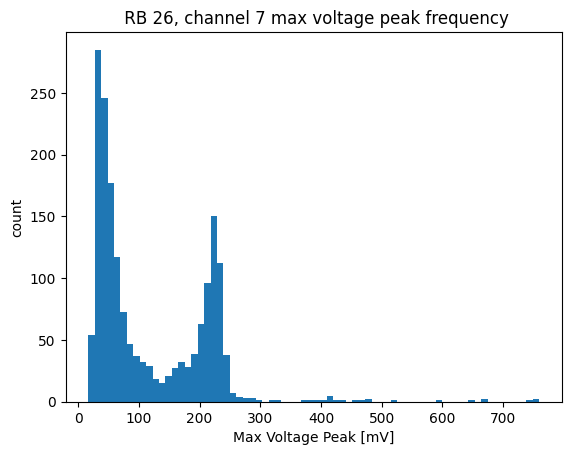

 60%|████████████████████████████████████████████████████████████████████                                              | 191/320 [00:50<00:31,  4.16it/s]

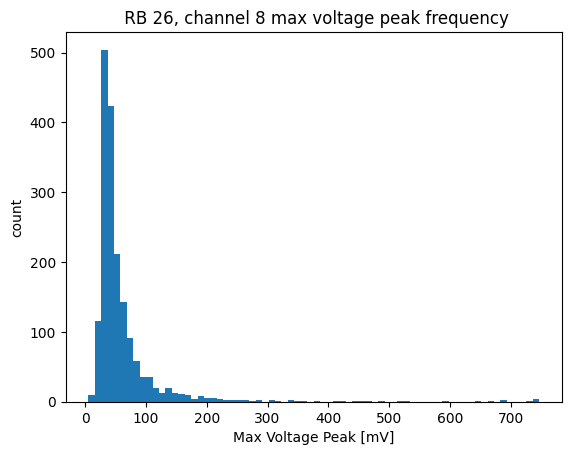

 60%|████████████████████████████████████████████████████████████████████▍                                             | 192/320 [00:50<00:30,  4.27it/s]

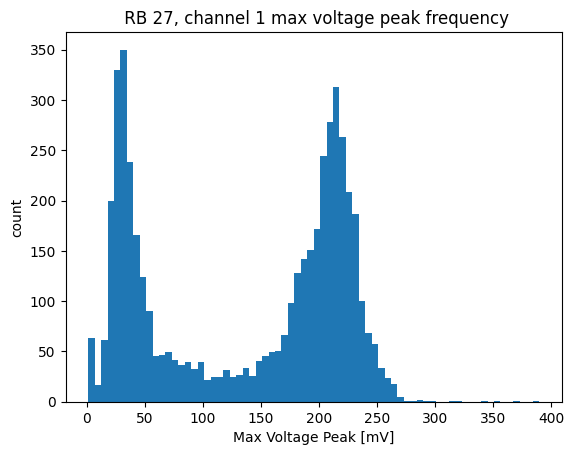

 60%|████████████████████████████████████████████████████████████████████▊                                             | 193/320 [00:51<00:29,  4.24it/s]

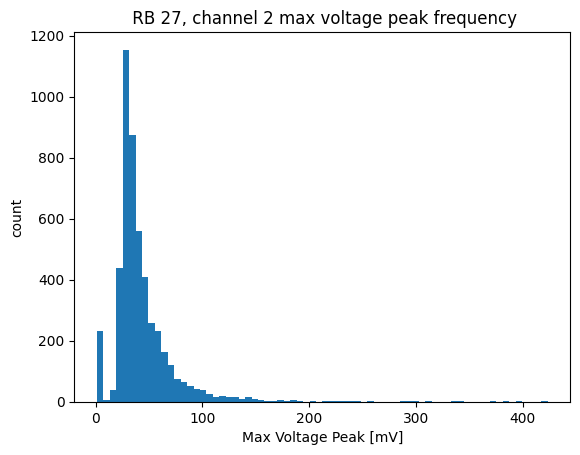

 61%|█████████████████████████████████████████████████████████████████████                                             | 194/320 [00:51<00:29,  4.28it/s]

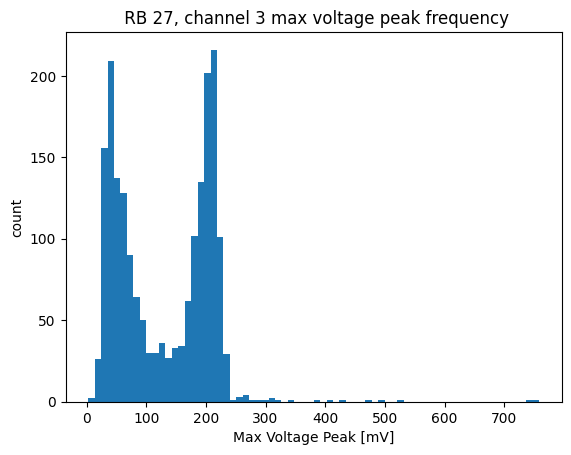

 61%|█████████████████████████████████████████████████████████████████████▍                                            | 195/320 [00:51<00:28,  4.37it/s]

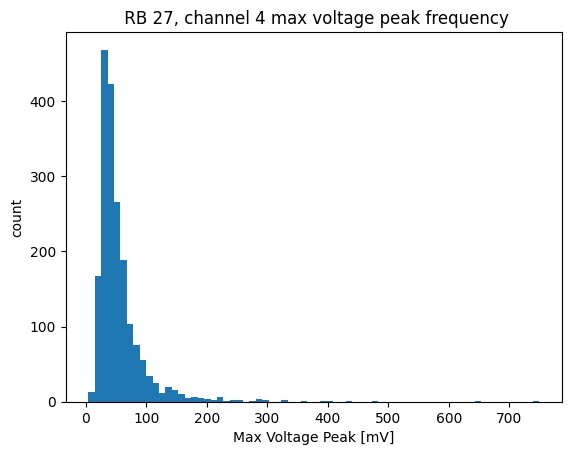

 61%|█████████████████████████████████████████████████████████████████████▊                                            | 196/320 [00:51<00:27,  4.48it/s]

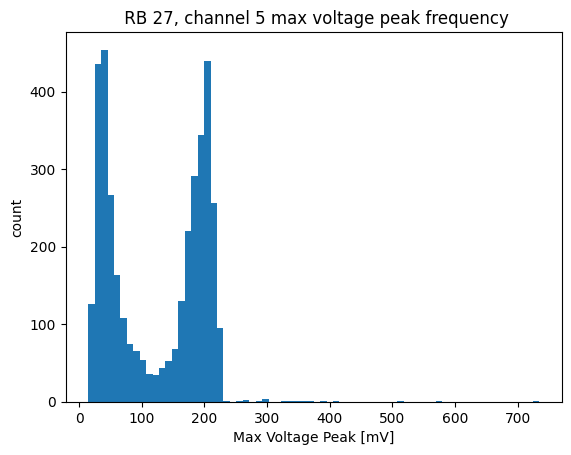

 62%|██████████████████████████████████████████████████████████████████████▏                                           | 197/320 [00:51<00:27,  4.51it/s]

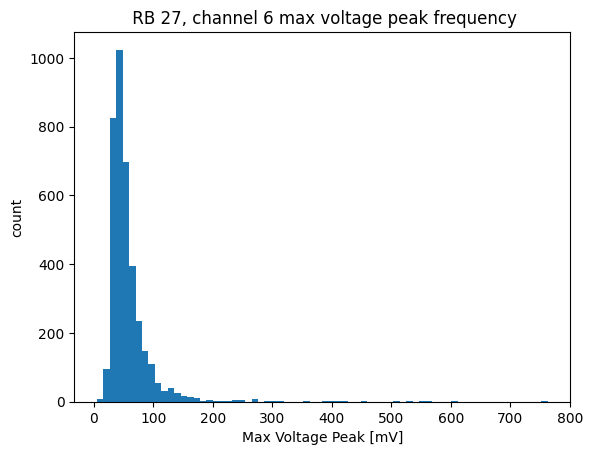

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 198/320 [00:52<00:27,  4.48it/s]

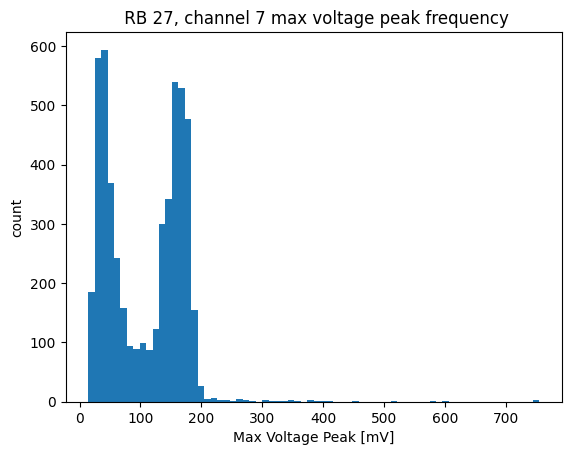

 62%|██████████████████████████████████████████████████████████████████████▉                                           | 199/320 [00:52<00:27,  4.43it/s]

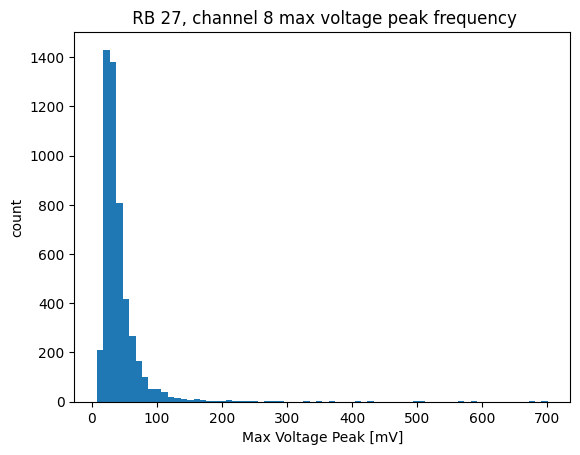

 62%|███████████████████████████████████████████████████████████████████████▎                                          | 200/320 [00:52<00:40,  2.97it/s]

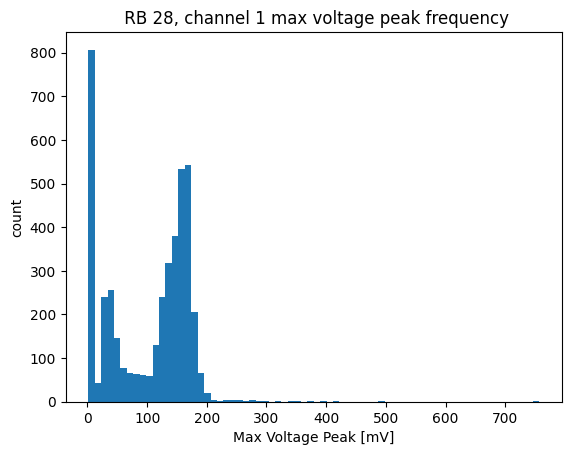

 63%|███████████████████████████████████████████████████████████████████████▌                                          | 201/320 [00:53<00:36,  3.23it/s]

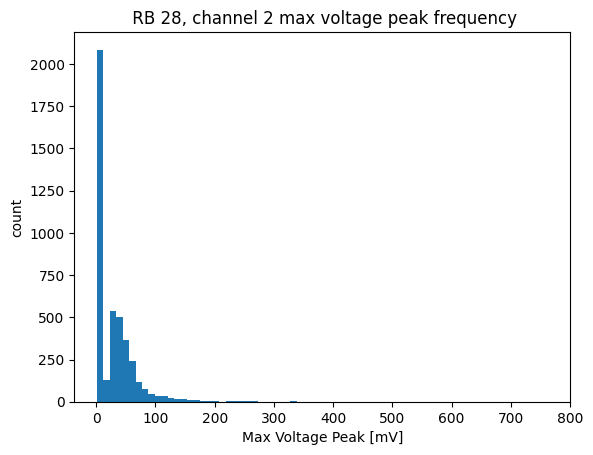

 63%|███████████████████████████████████████████████████████████████████████▉                                          | 202/320 [00:53<00:34,  3.43it/s]

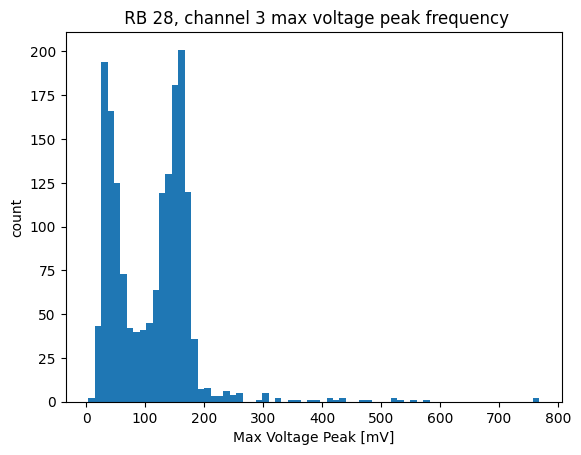

 63%|████████████████████████████████████████████████████████████████████████▎                                         | 203/320 [00:53<00:32,  3.61it/s]

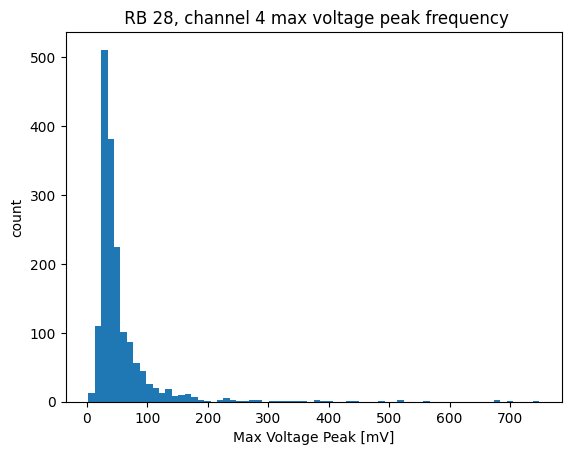

 64%|████████████████████████████████████████████████████████████████████████▋                                         | 204/320 [00:53<00:30,  3.84it/s]

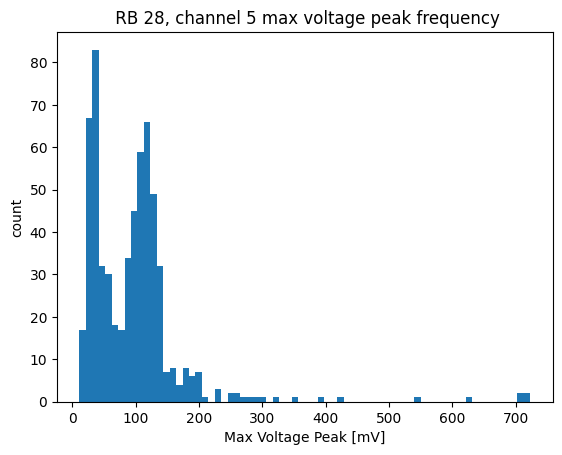

 64%|█████████████████████████████████████████████████████████████████████████                                         | 205/320 [00:54<00:29,  3.93it/s]

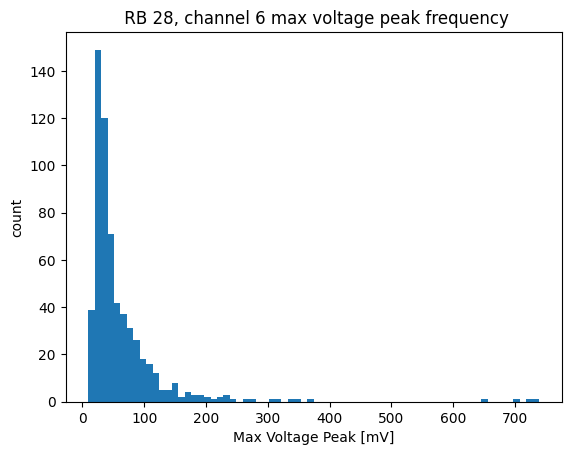

 64%|█████████████████████████████████████████████████████████████████████████▍                                        | 206/320 [00:54<00:28,  4.04it/s]

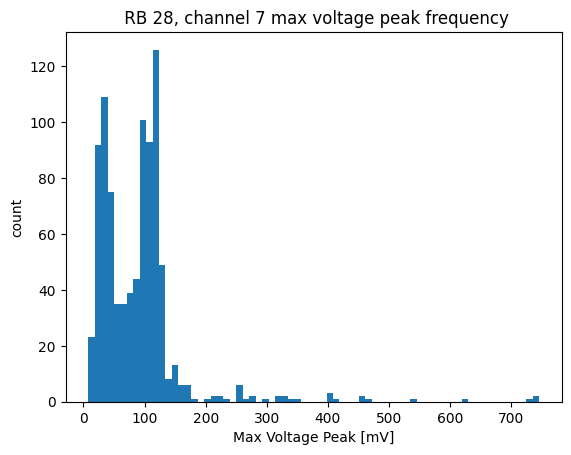

 65%|█████████████████████████████████████████████████████████████████████████▋                                        | 207/320 [00:54<00:27,  4.14it/s]

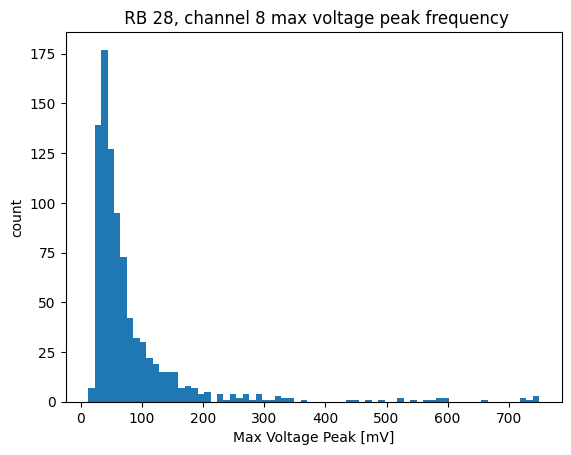

 65%|██████████████████████████████████████████████████████████████████████████                                        | 208/320 [00:54<00:26,  4.23it/s]

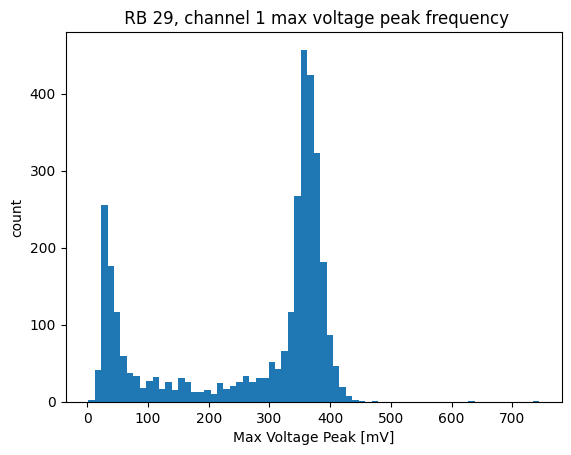

 65%|██████████████████████████████████████████████████████████████████████████▍                                       | 209/320 [00:55<00:25,  4.36it/s]

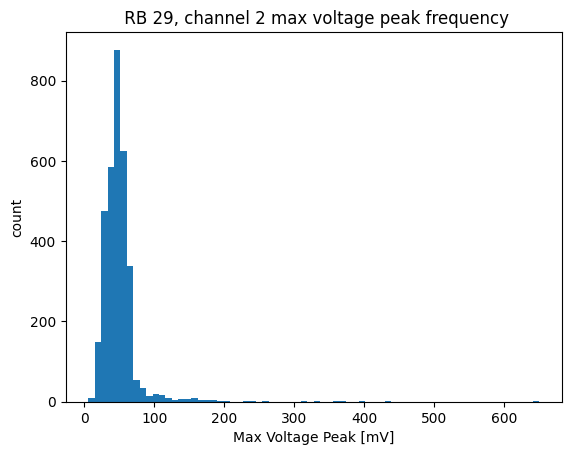

 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 210/320 [00:55<00:24,  4.45it/s]

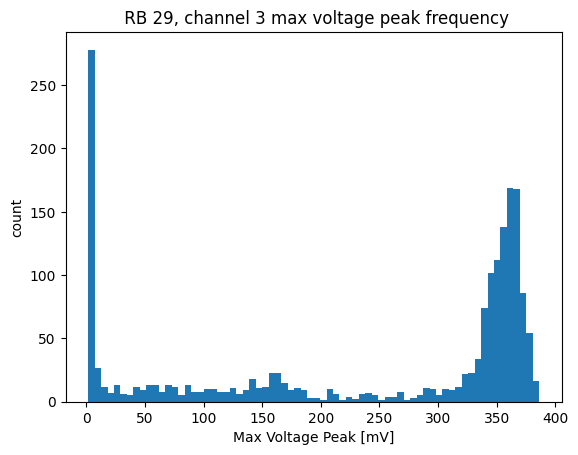

 66%|███████████████████████████████████████████████████████████████████████████▏                                      | 211/320 [00:55<00:24,  4.48it/s]

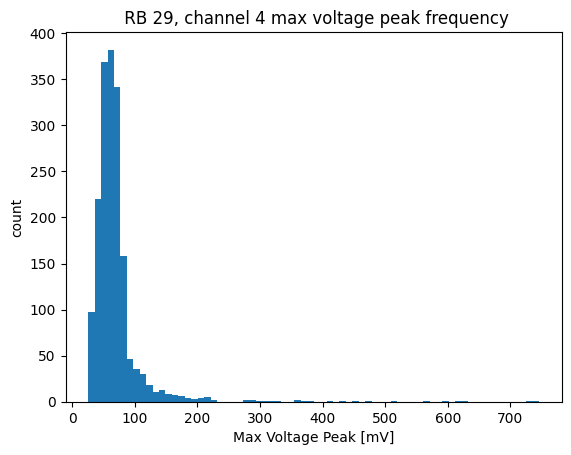

 66%|███████████████████████████████████████████████████████████████████████████▌                                      | 212/320 [00:55<00:24,  4.44it/s]

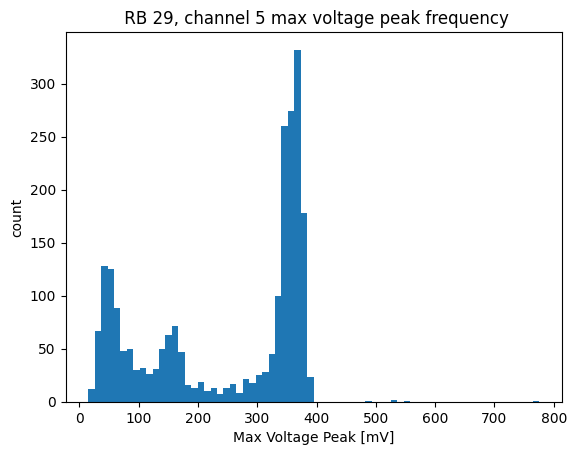

 67%|███████████████████████████████████████████████████████████████████████████▉                                      | 213/320 [00:55<00:24,  4.45it/s]

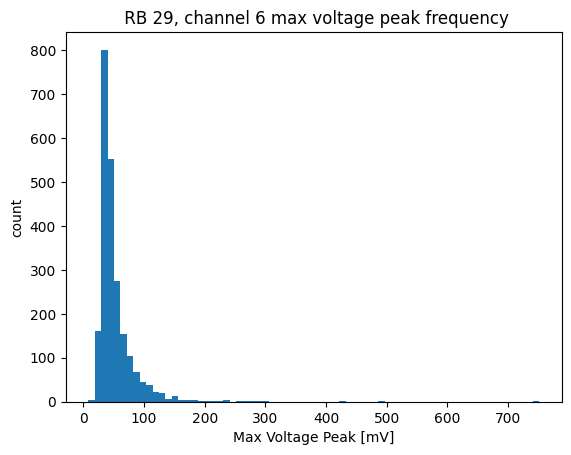

 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 214/320 [00:56<00:24,  4.41it/s]

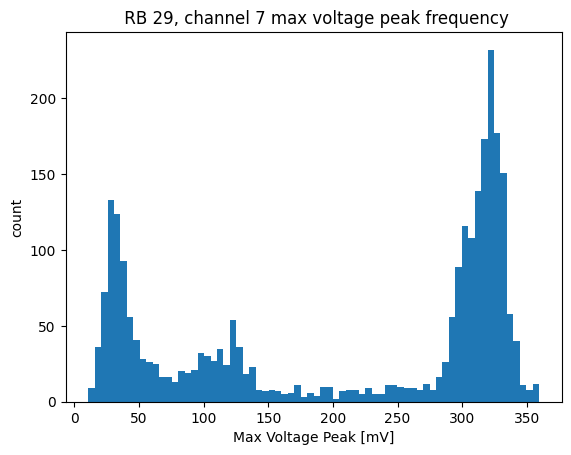

 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 215/320 [00:56<00:34,  3.02it/s]

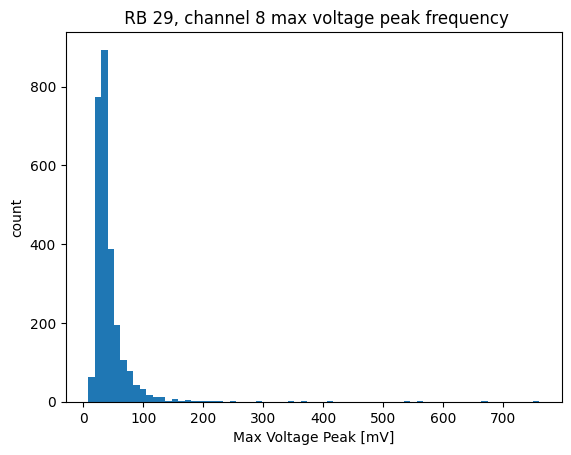

 68%|████████████████████████████████████████████████████████████████████████████▉                                     | 216/320 [00:57<00:30,  3.37it/s]

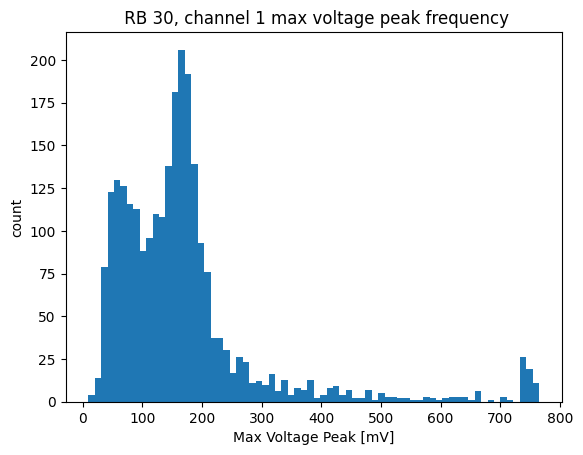

 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 217/320 [00:57<00:28,  3.56it/s]

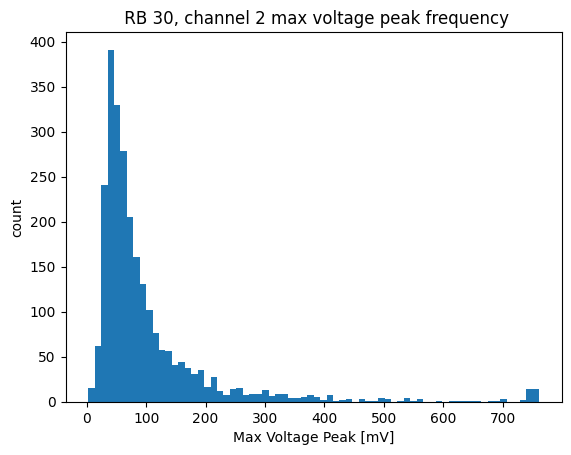

 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 218/320 [00:57<00:27,  3.74it/s]

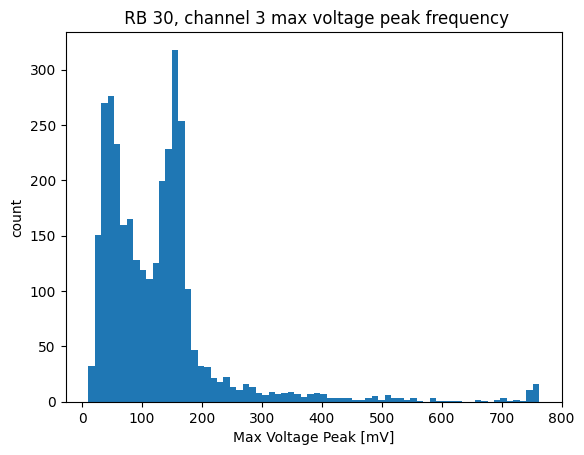

 68%|██████████████████████████████████████████████████████████████████████████████                                    | 219/320 [00:57<00:26,  3.88it/s]

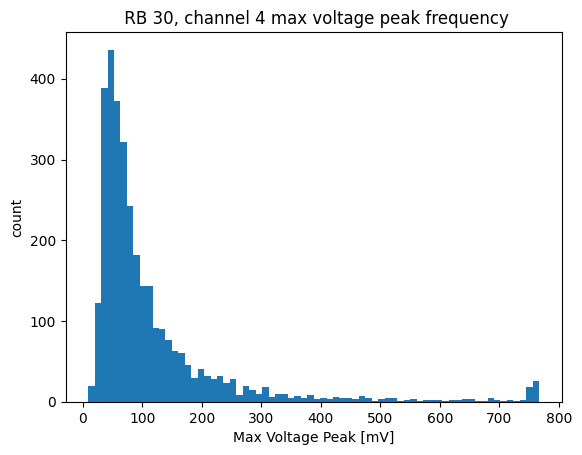

 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 220/320 [00:57<00:24,  4.05it/s]

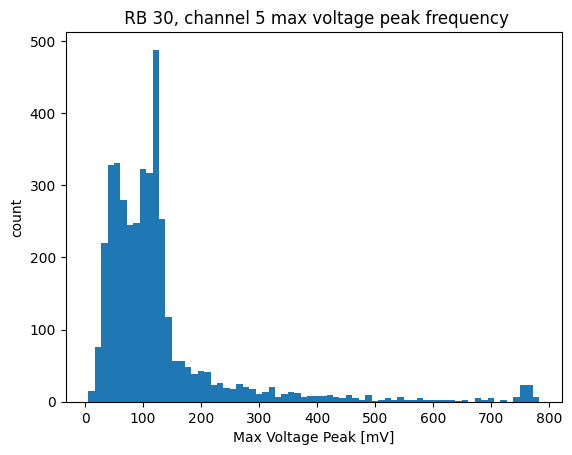

 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 221/320 [00:58<00:24,  4.12it/s]

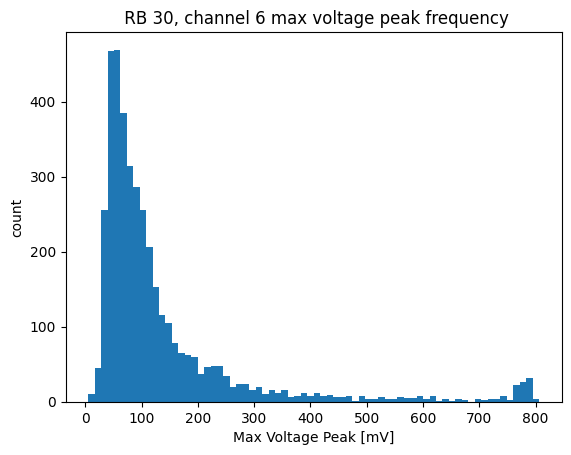

 69%|███████████████████████████████████████████████████████████████████████████████                                   | 222/320 [00:58<00:23,  4.20it/s]

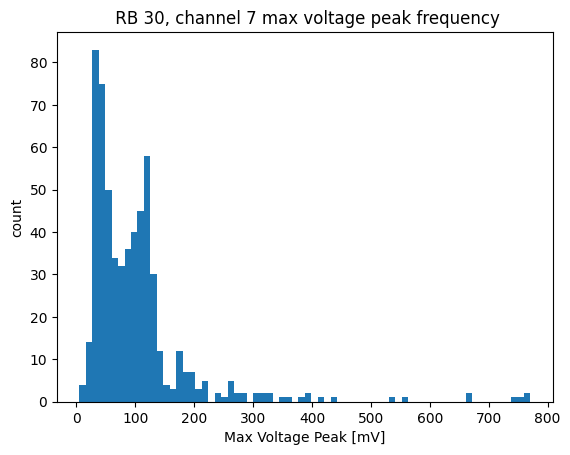

 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 223/320 [00:58<00:23,  4.21it/s]

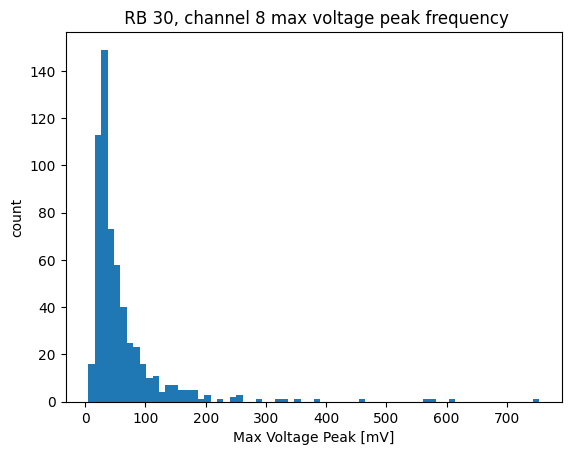

 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 224/320 [00:58<00:22,  4.30it/s]

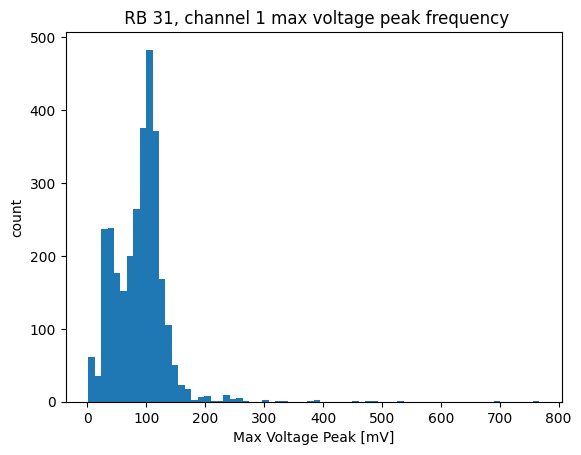

 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 225/320 [00:59<00:22,  4.28it/s]

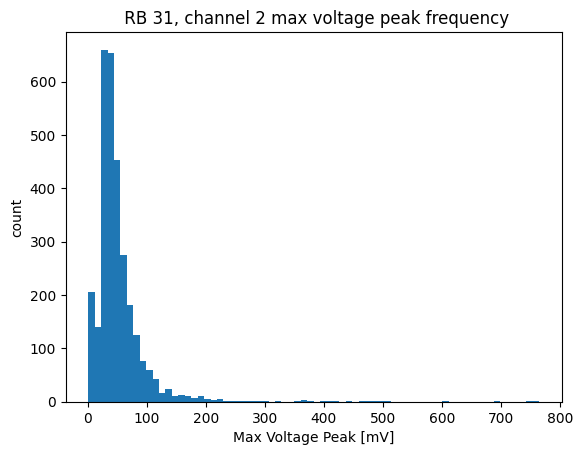

 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 226/320 [00:59<00:21,  4.30it/s]

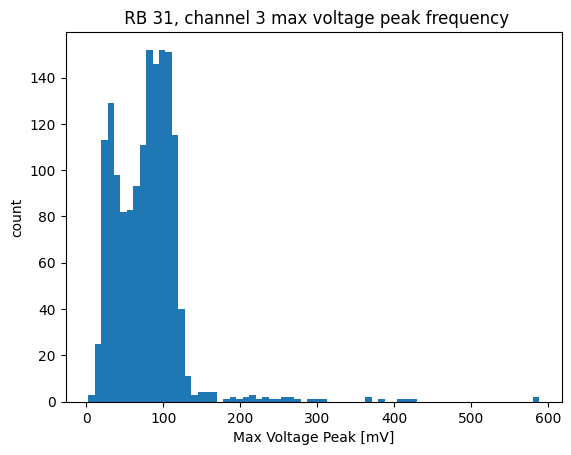

 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 227/320 [00:59<00:21,  4.35it/s]

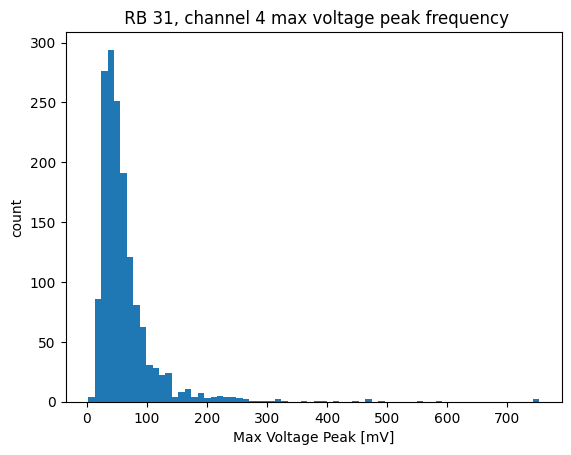

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 228/320 [00:59<00:20,  4.38it/s]

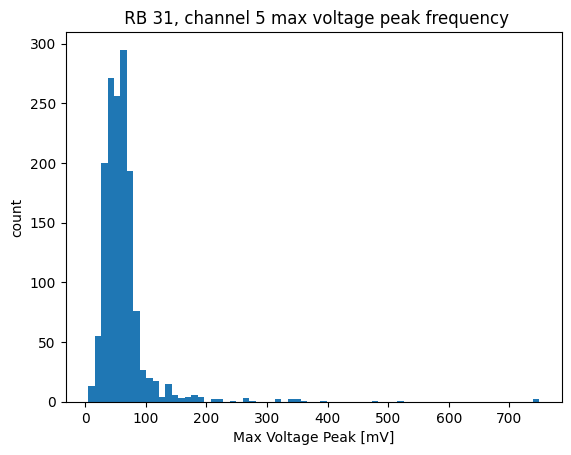

 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 229/320 [01:00<00:30,  3.01it/s]

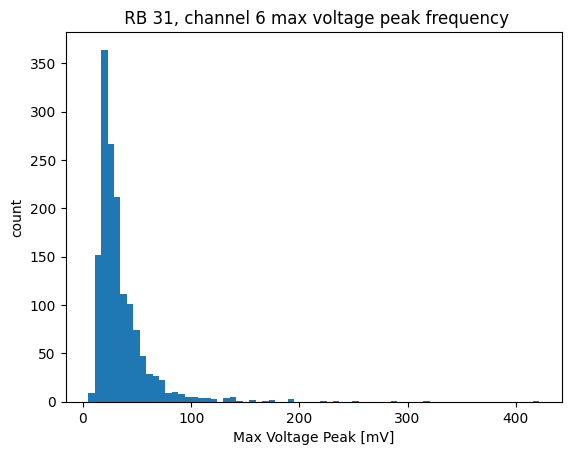

 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 230/320 [01:00<00:26,  3.36it/s]

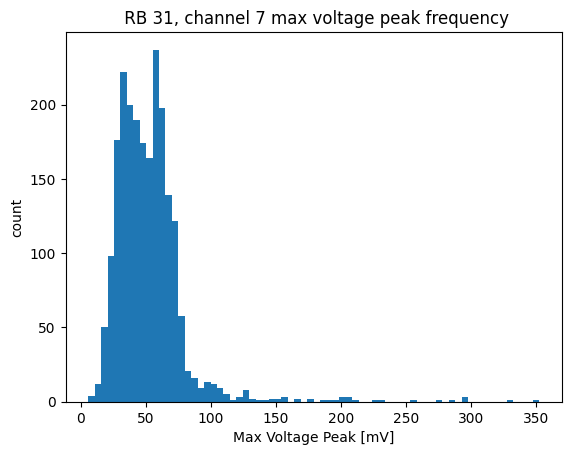

 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 231/320 [01:00<00:24,  3.64it/s]

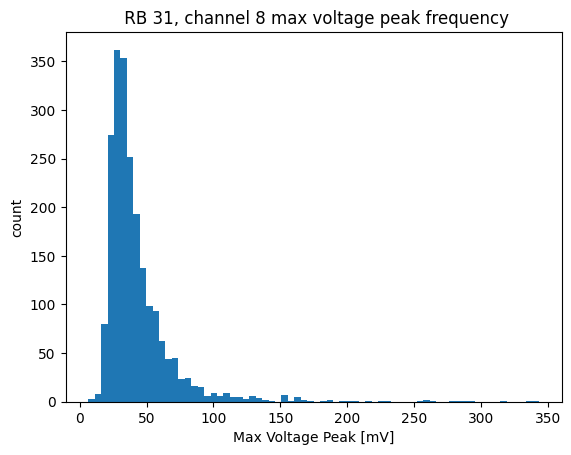

 72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 232/320 [01:01<00:22,  3.83it/s]

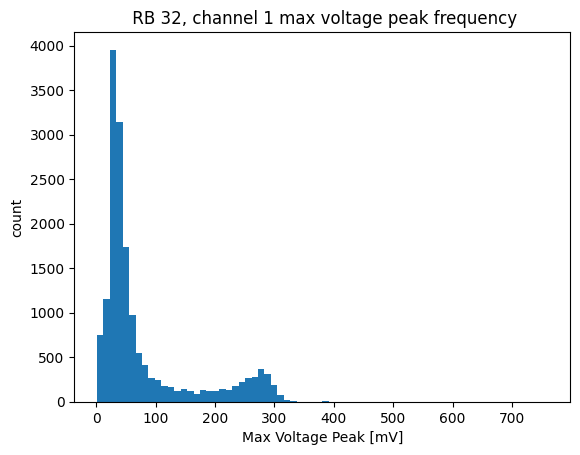

 73%|███████████████████████████████████████████████████████████████████████████████████                               | 233/320 [01:01<00:23,  3.75it/s]

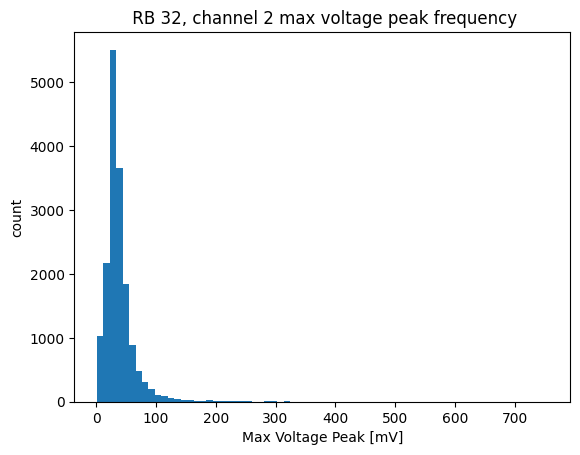

 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 234/320 [01:01<00:22,  3.77it/s]

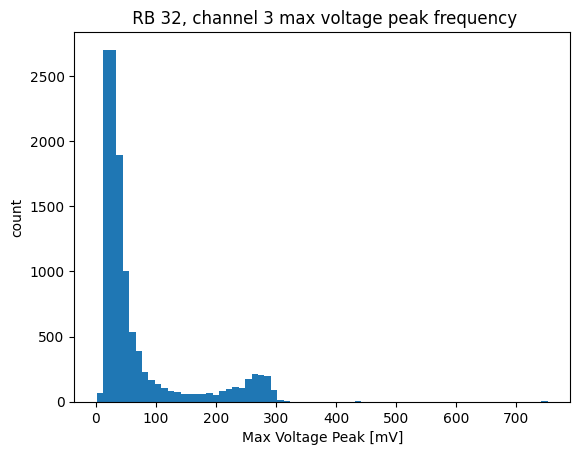

 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 235/320 [01:01<00:22,  3.83it/s]

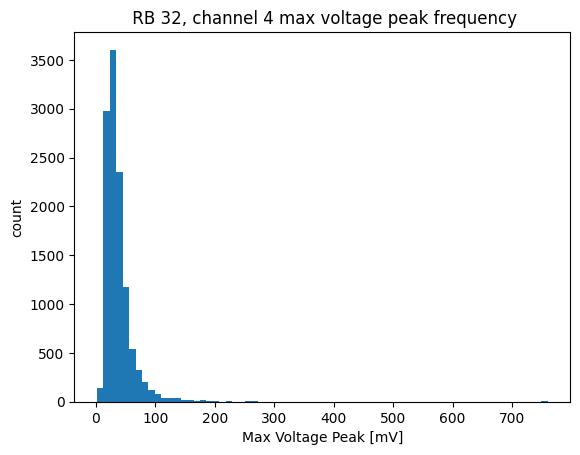

 74%|████████████████████████████████████████████████████████████████████████████████████                              | 236/320 [01:02<00:21,  3.82it/s]

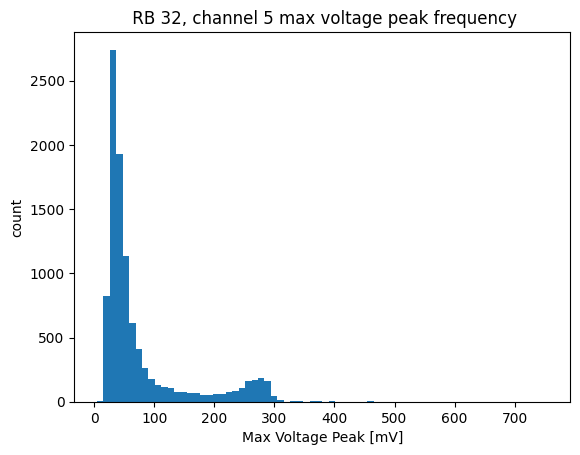

 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 237/320 [01:02<00:21,  3.87it/s]

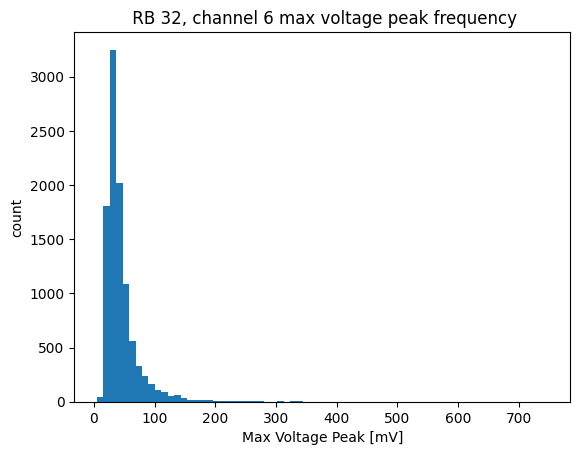

 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 238/320 [01:02<00:21,  3.90it/s]

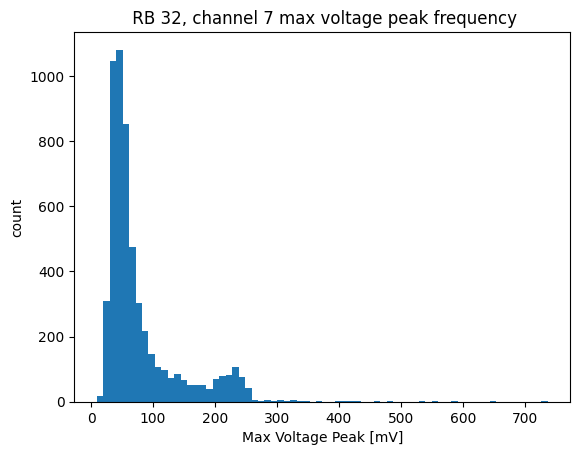

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 239/320 [01:02<00:20,  4.02it/s]

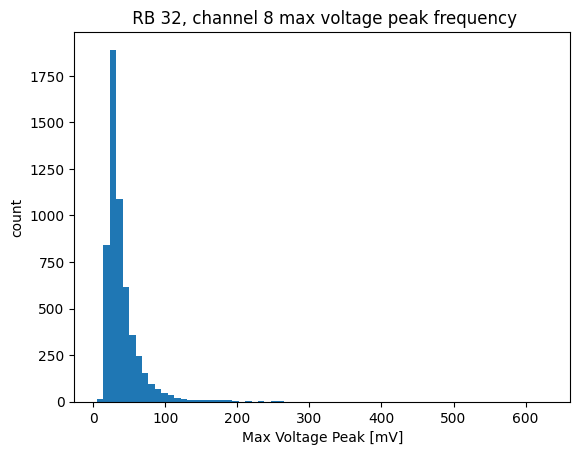

 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 240/320 [01:03<00:19,  4.08it/s]

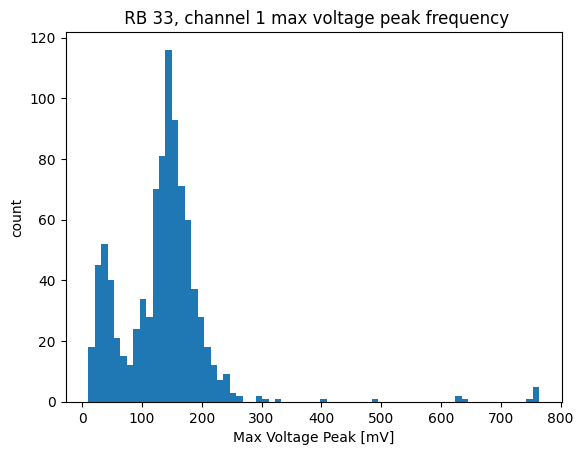

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 241/320 [01:03<00:19,  4.12it/s]

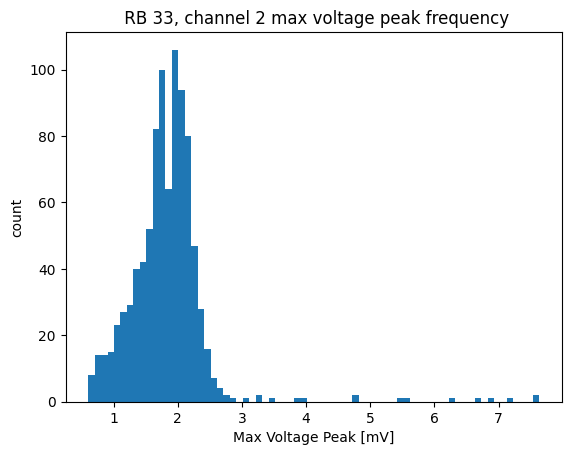

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 242/320 [01:03<00:18,  4.27it/s]

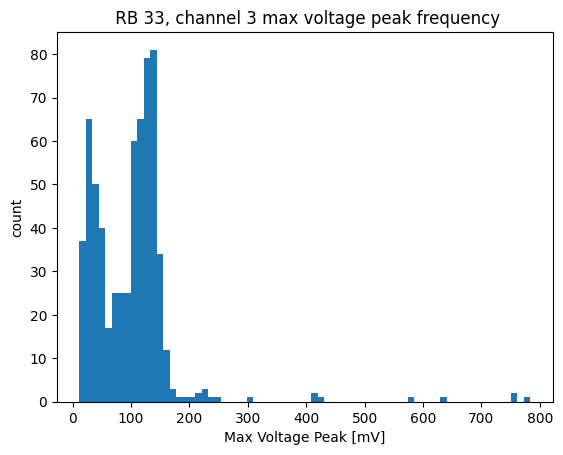

 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 243/320 [01:03<00:18,  4.28it/s]

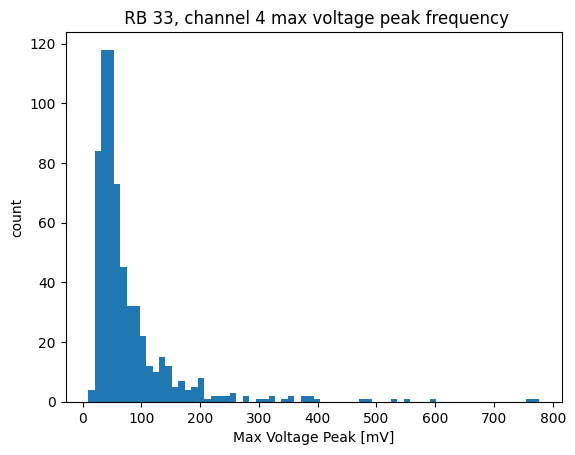

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 244/320 [01:04<00:25,  2.93it/s]

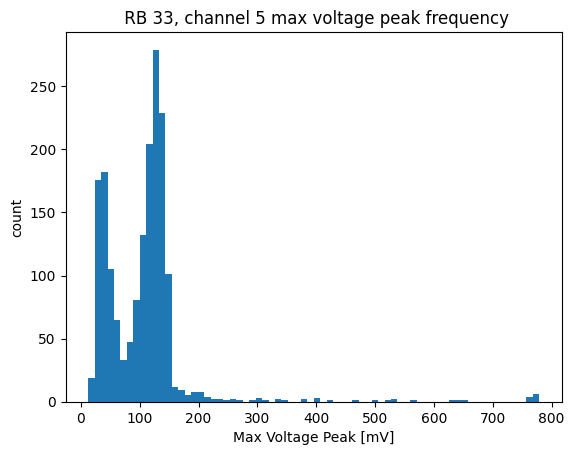

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                          | 245/320 [01:04<00:22,  3.28it/s]

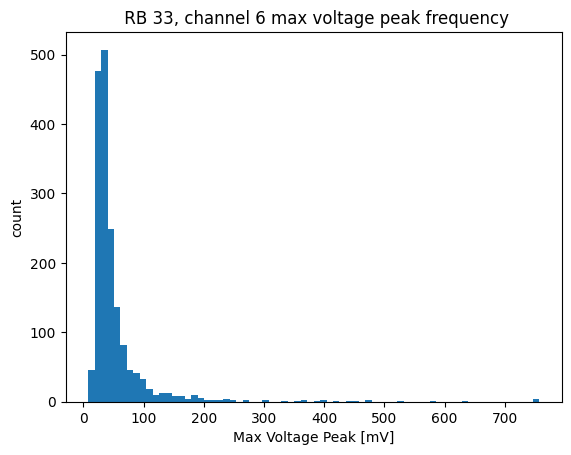

 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 246/320 [01:04<00:20,  3.57it/s]

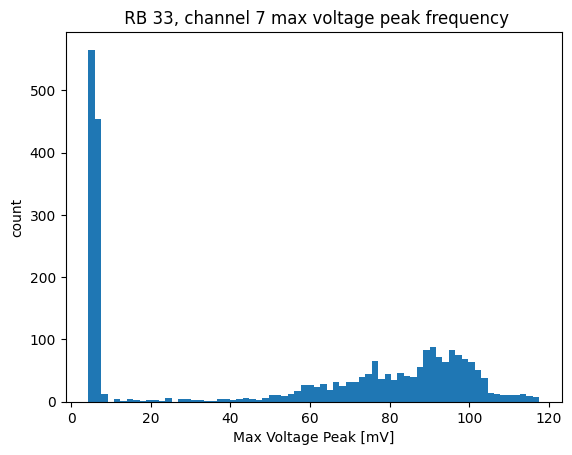

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                          | 247/320 [01:04<00:19,  3.80it/s]

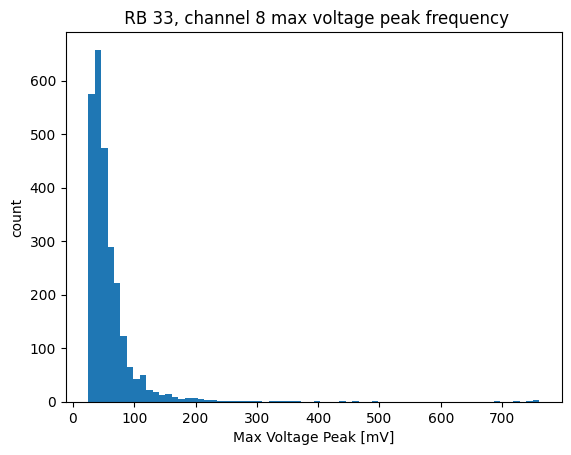

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 248/320 [01:05<00:18,  3.95it/s]

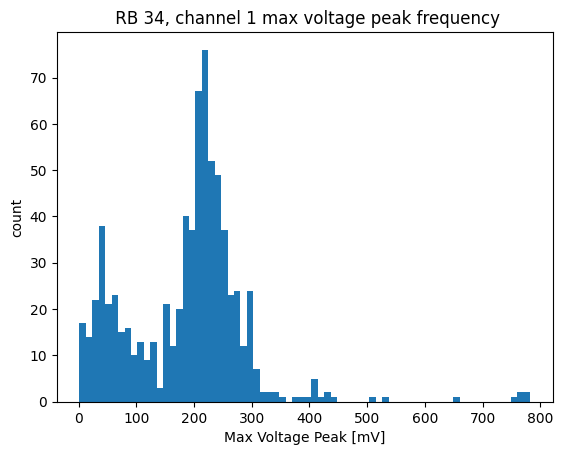

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                         | 249/320 [01:05<00:17,  4.05it/s]

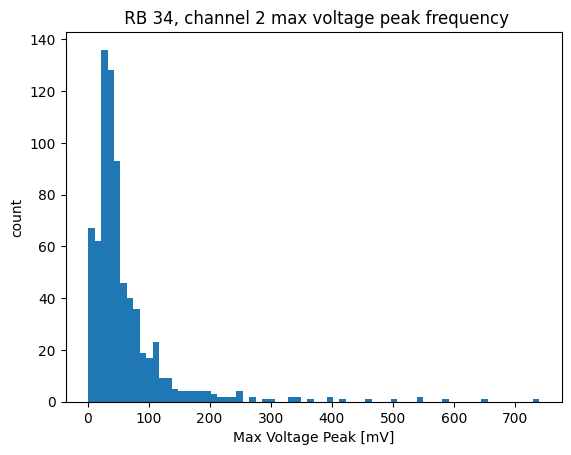

 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 250/320 [01:05<00:16,  4.13it/s]

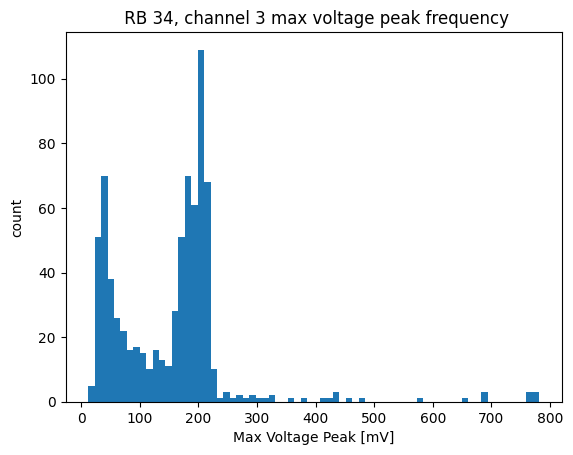

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 251/320 [01:05<00:16,  4.24it/s]

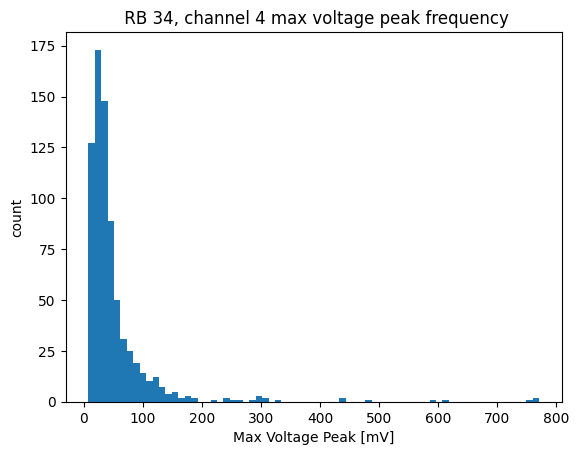

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 252/320 [01:06<00:15,  4.28it/s]

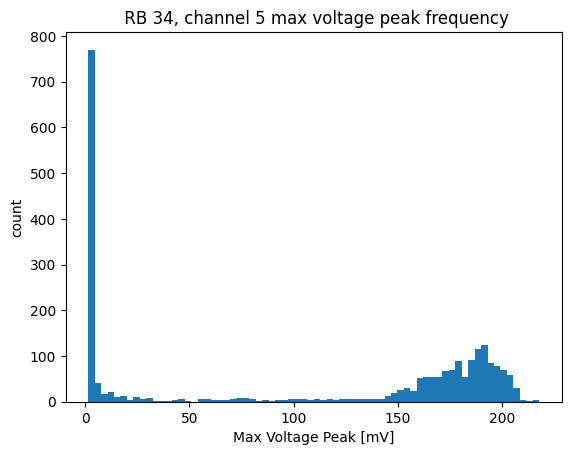

 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 253/320 [01:06<00:15,  4.31it/s]

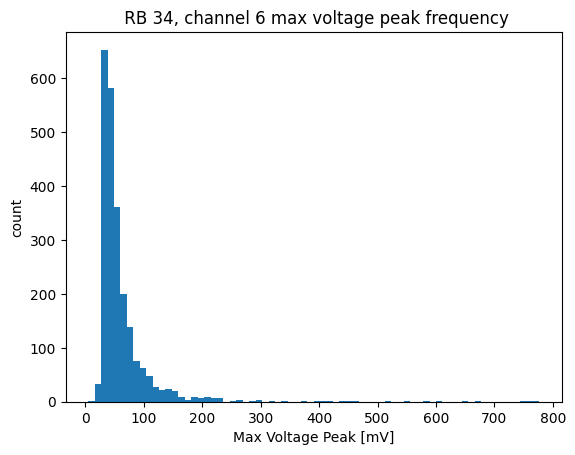

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 254/320 [01:06<00:15,  4.34it/s]

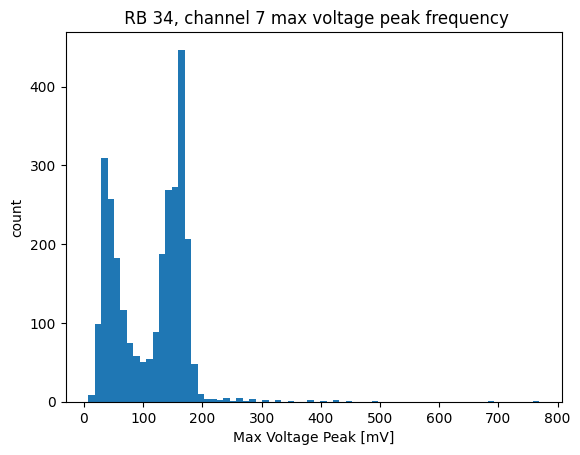

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 255/320 [01:06<00:14,  4.41it/s]

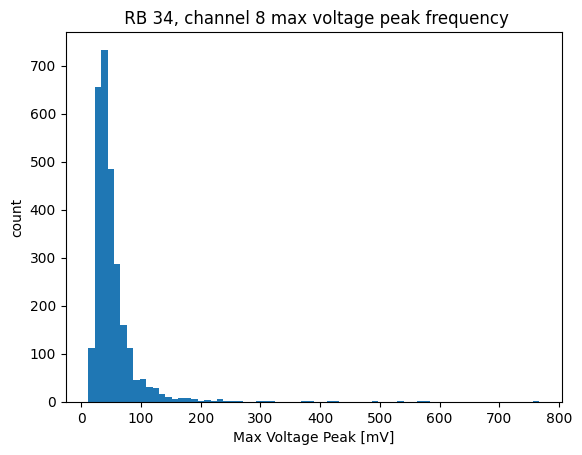

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 256/320 [01:07<00:14,  4.38it/s]

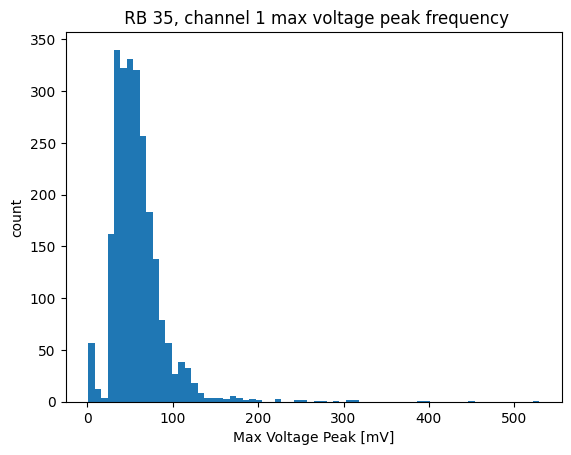

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                      | 257/320 [01:07<00:14,  4.35it/s]

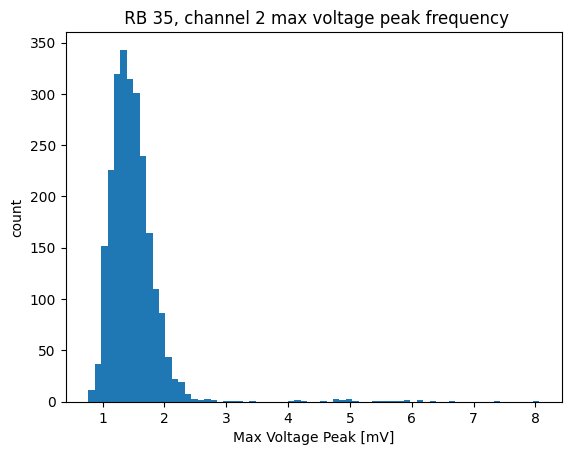

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 258/320 [01:07<00:20,  2.98it/s]

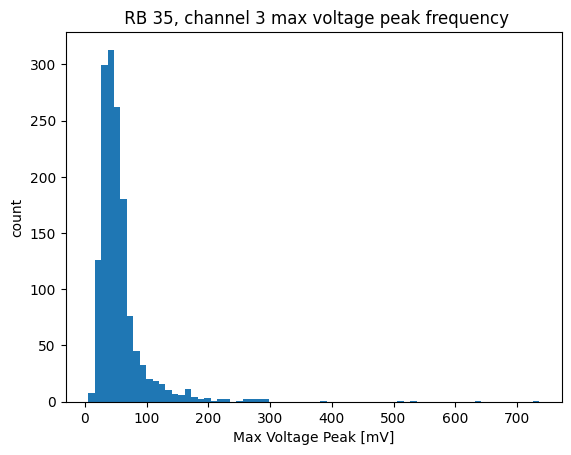

 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 259/320 [01:08<00:18,  3.30it/s]

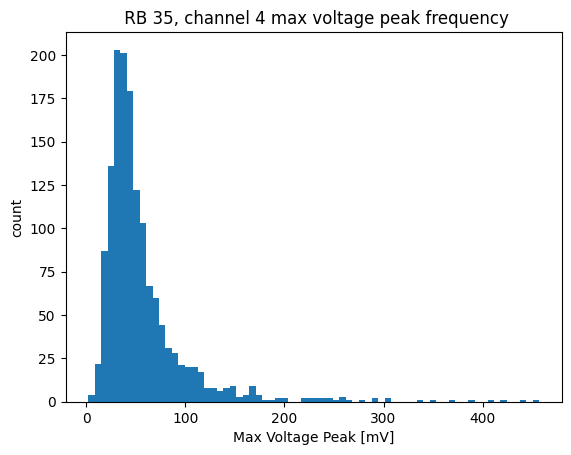

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 260/320 [01:08<00:16,  3.58it/s]

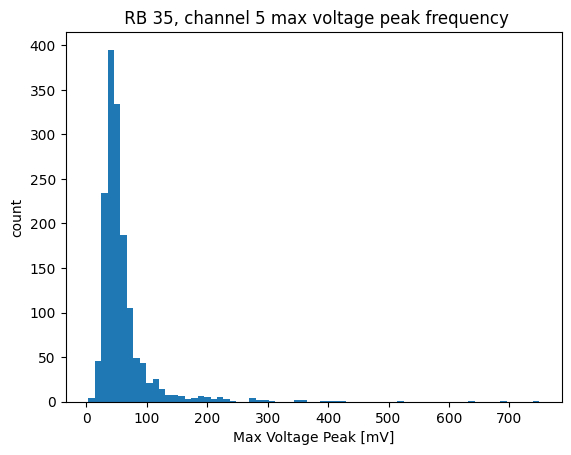

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 261/320 [01:08<00:15,  3.76it/s]

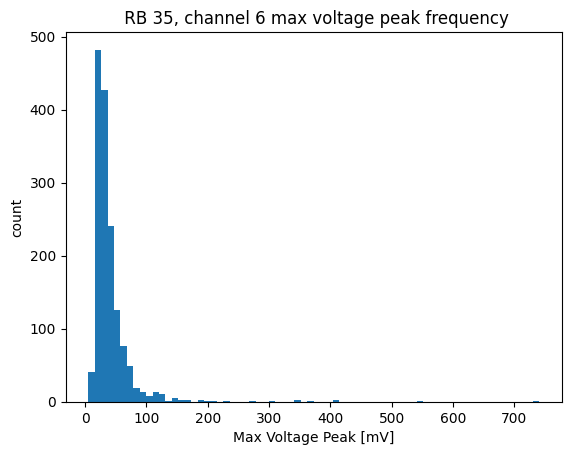

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 262/320 [01:08<00:14,  3.95it/s]

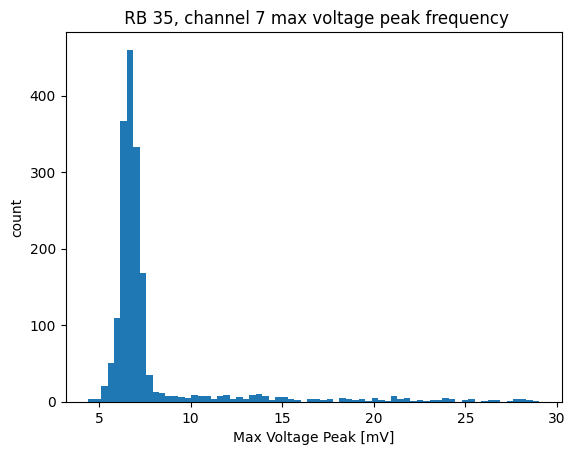

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 263/320 [01:08<00:13,  4.17it/s]

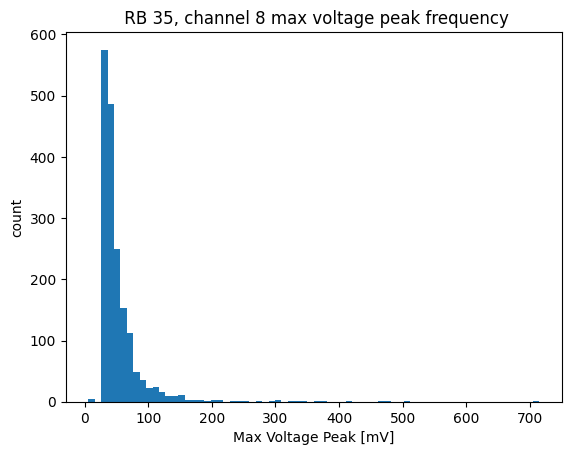

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 264/320 [01:09<00:13,  4.23it/s]

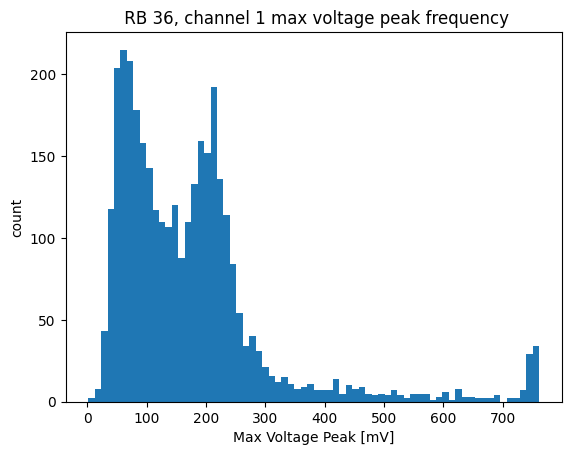

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 265/320 [01:09<00:13,  4.17it/s]

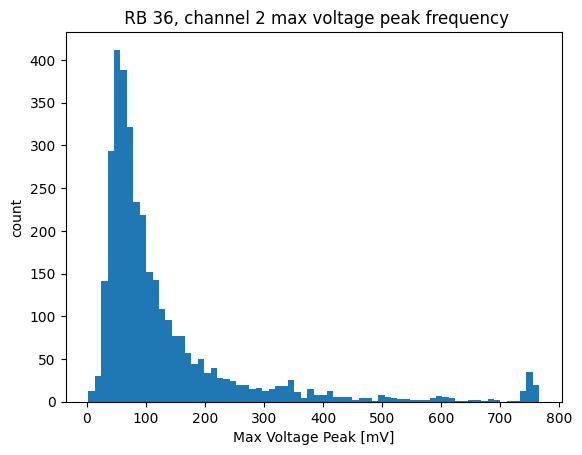

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 266/320 [01:09<00:13,  4.12it/s]

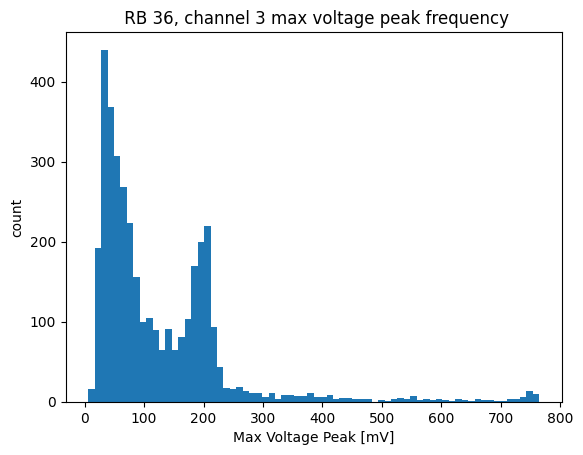

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 267/320 [01:09<00:12,  4.22it/s]

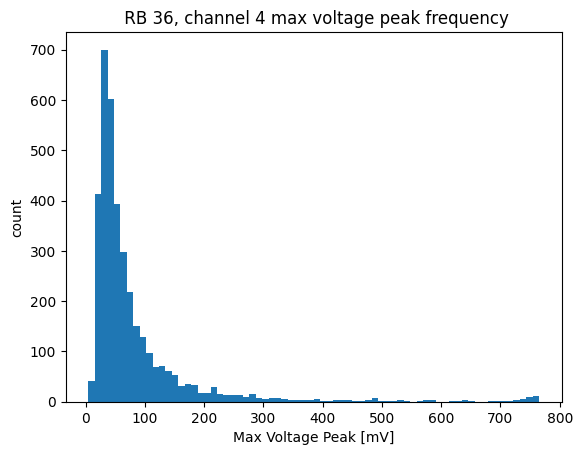

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 268/320 [01:10<00:12,  4.24it/s]

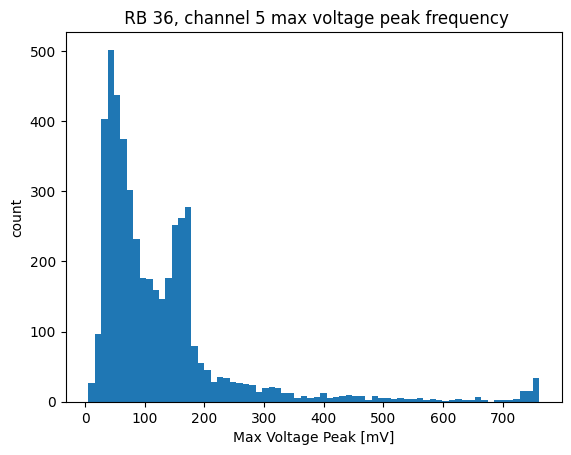

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 269/320 [01:10<00:11,  4.27it/s]

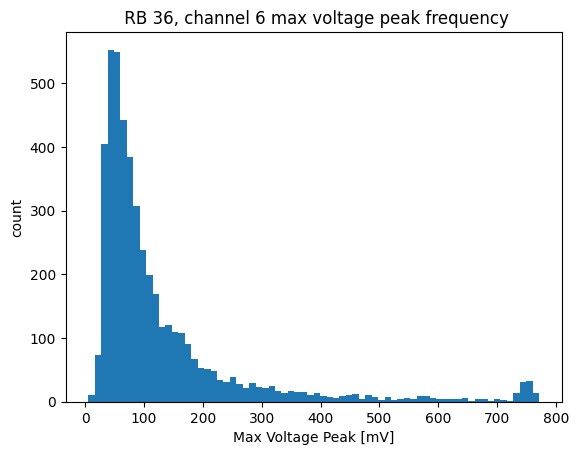

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 270/320 [01:10<00:11,  4.30it/s]

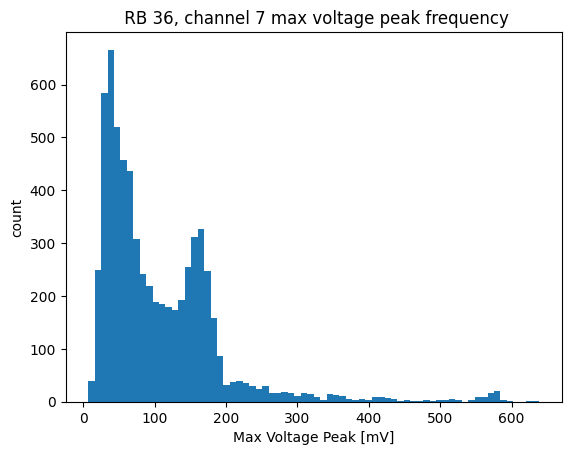

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 271/320 [01:10<00:11,  4.32it/s]

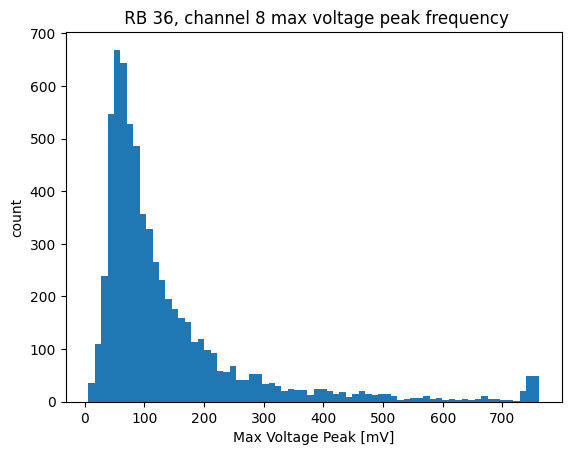

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 272/320 [01:11<00:11,  4.26it/s]

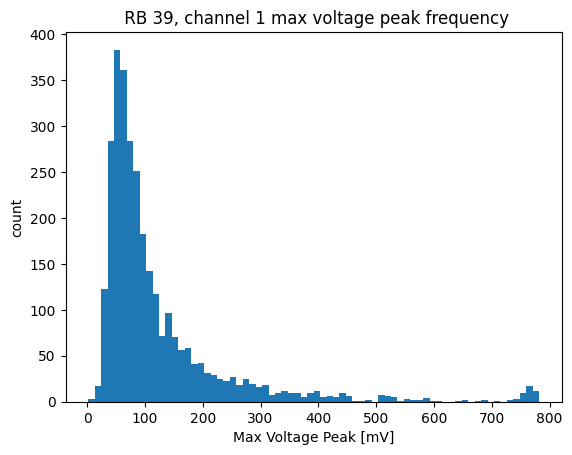

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                | 273/320 [01:11<00:16,  2.89it/s]

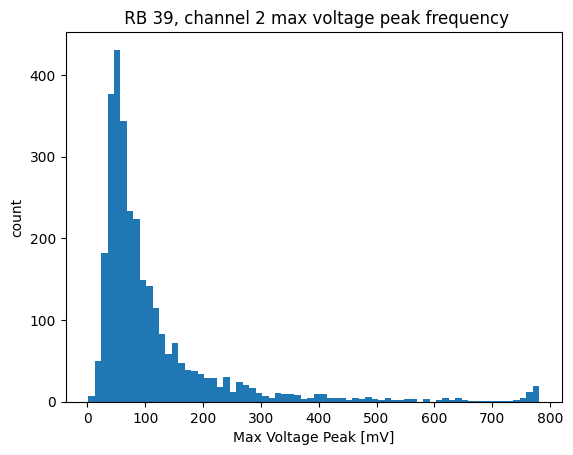

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 274/320 [01:11<00:14,  3.22it/s]

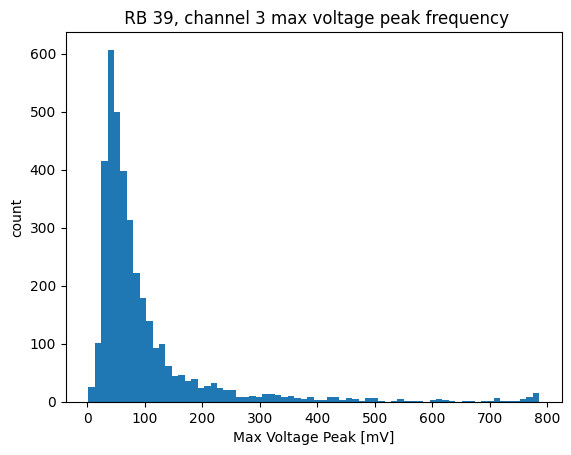

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 275/320 [01:12<00:12,  3.49it/s]

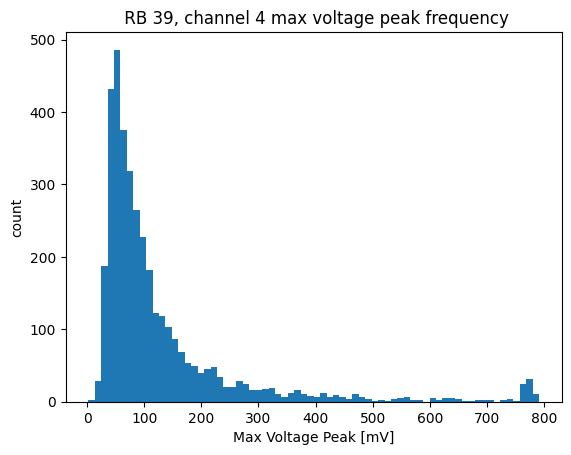

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 276/320 [01:12<00:11,  3.71it/s]

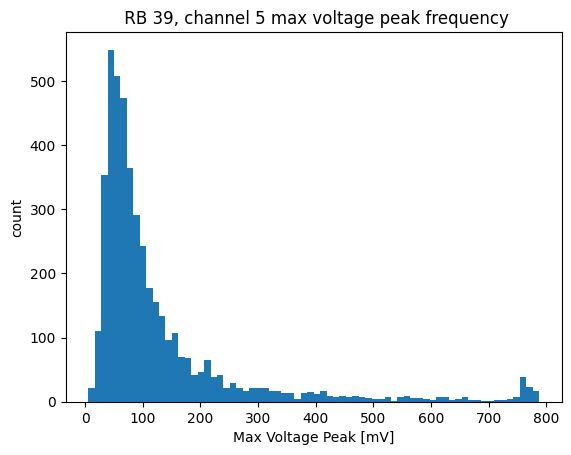

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 277/320 [01:12<00:11,  3.88it/s]

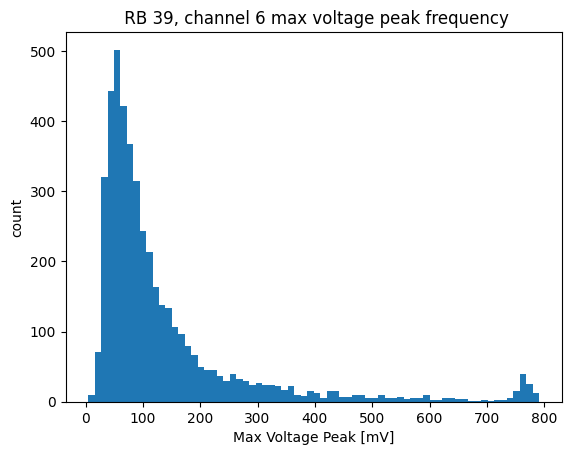

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 278/320 [01:12<00:10,  3.83it/s]

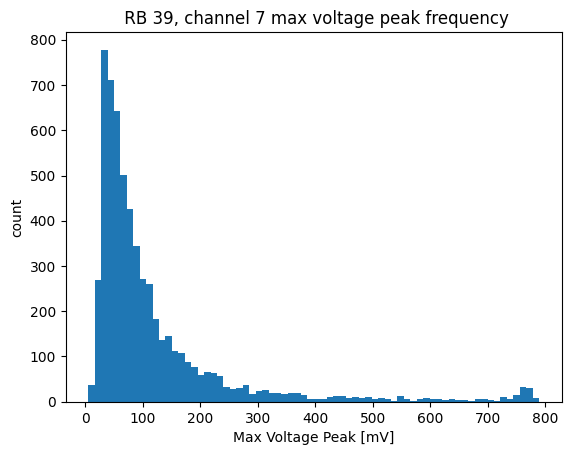

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 279/320 [01:13<00:10,  3.87it/s]

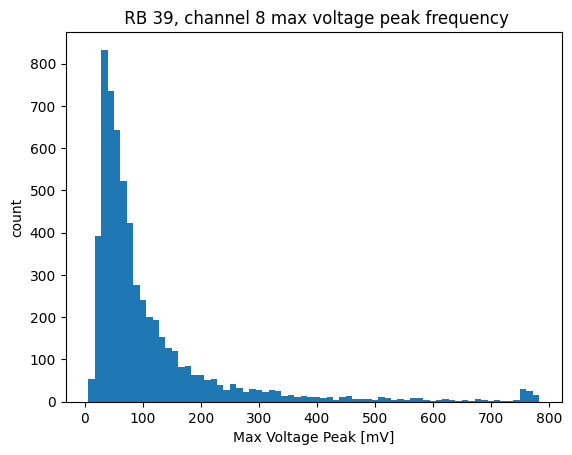

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 280/320 [01:13<00:10,  3.91it/s]

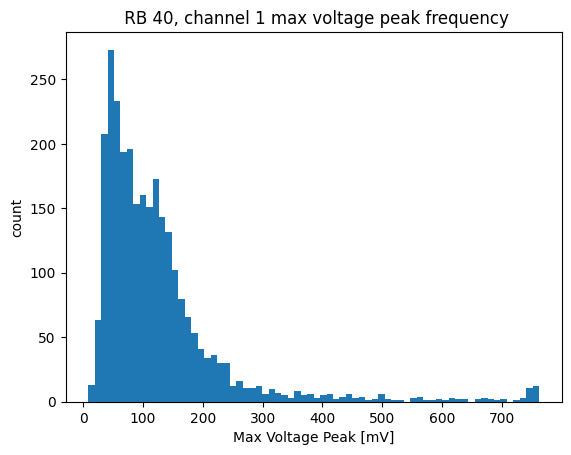

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 281/320 [01:13<00:09,  4.06it/s]

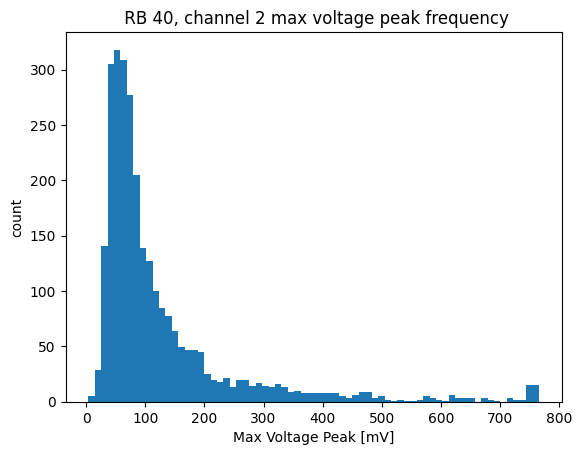

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 282/320 [01:13<00:09,  4.13it/s]

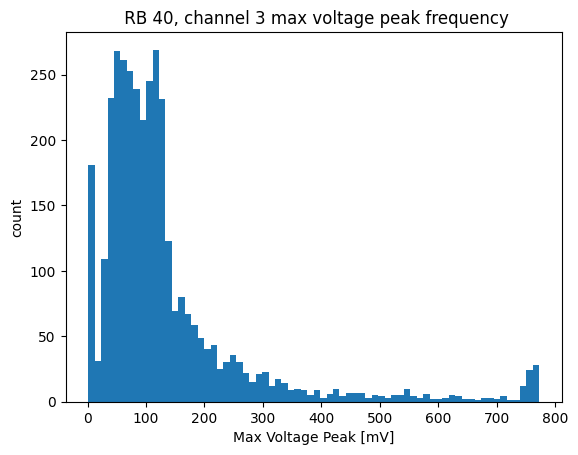

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 283/320 [01:14<00:08,  4.19it/s]

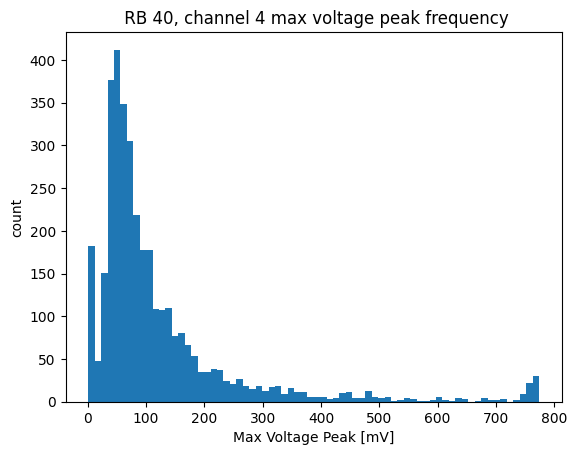

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 284/320 [01:14<00:08,  4.17it/s]

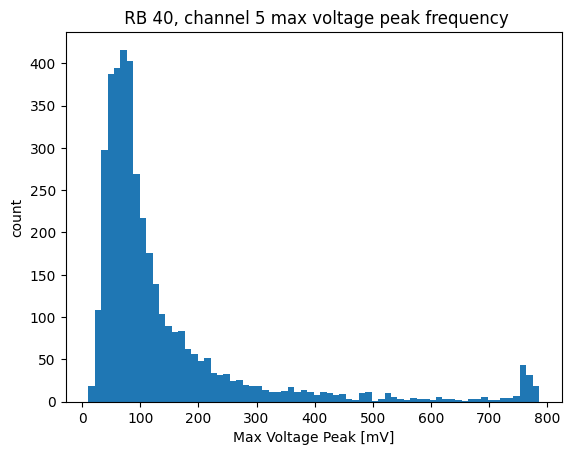

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 285/320 [01:14<00:09,  3.74it/s]

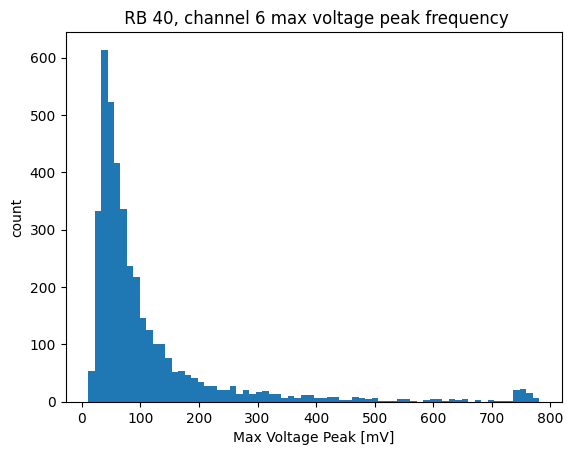

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 286/320 [01:14<00:08,  3.80it/s]

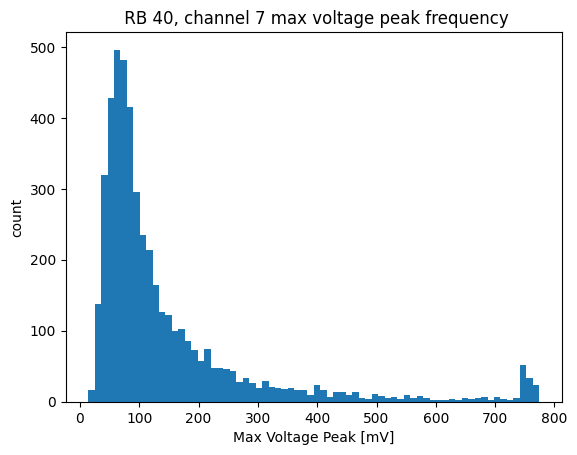

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 287/320 [01:15<00:12,  2.54it/s]

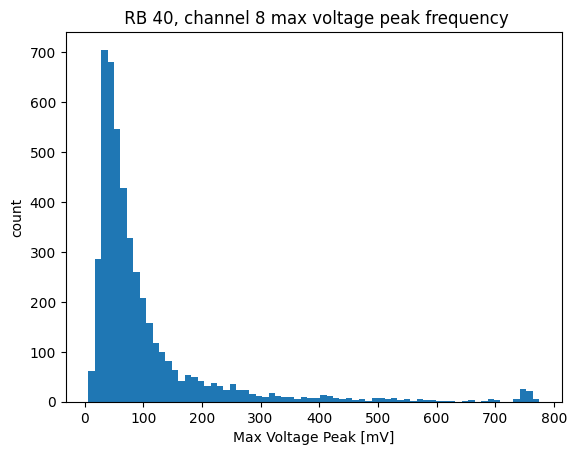

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 288/320 [01:15<00:11,  2.87it/s]

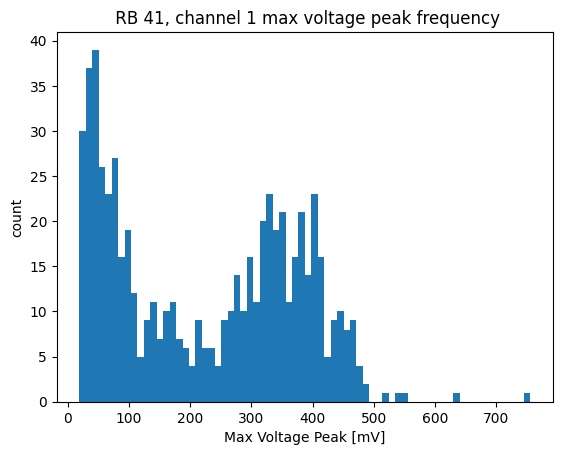

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 289/320 [01:16<00:09,  3.20it/s]

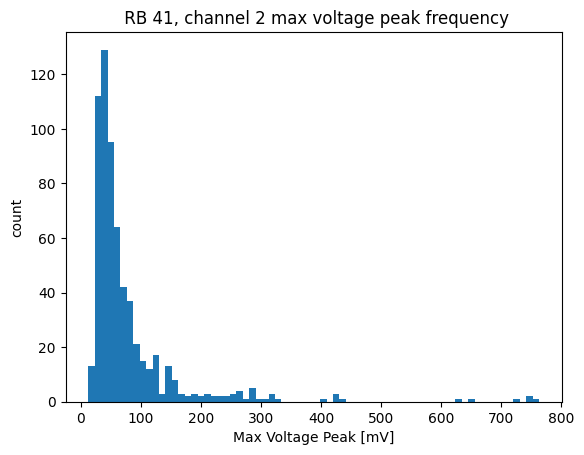

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 290/320 [01:16<00:08,  3.46it/s]

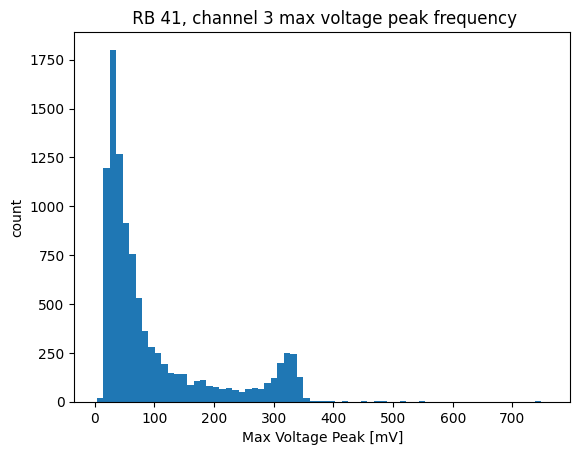

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 291/320 [01:16<00:08,  3.58it/s]

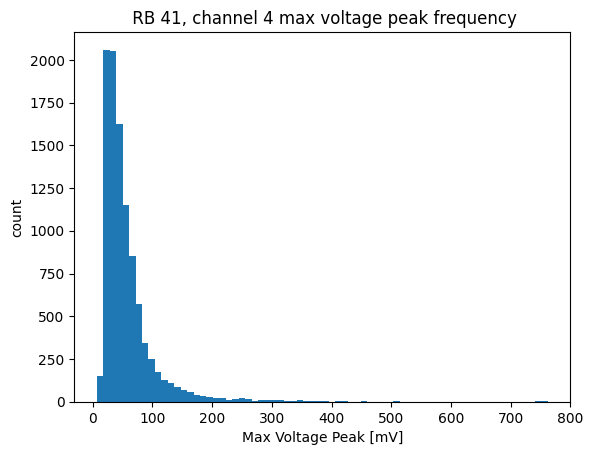

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 292/320 [01:16<00:07,  3.64it/s]

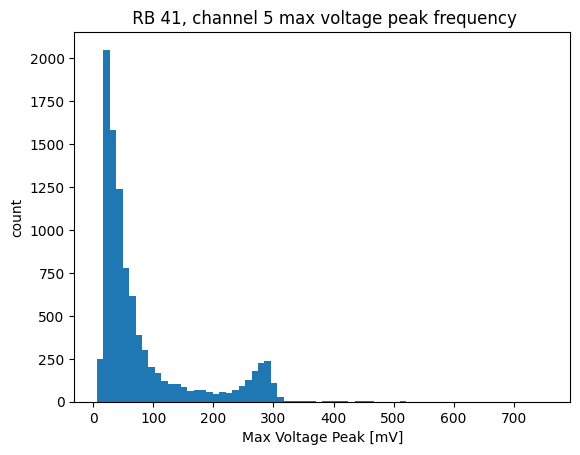

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 293/320 [01:17<00:07,  3.68it/s]

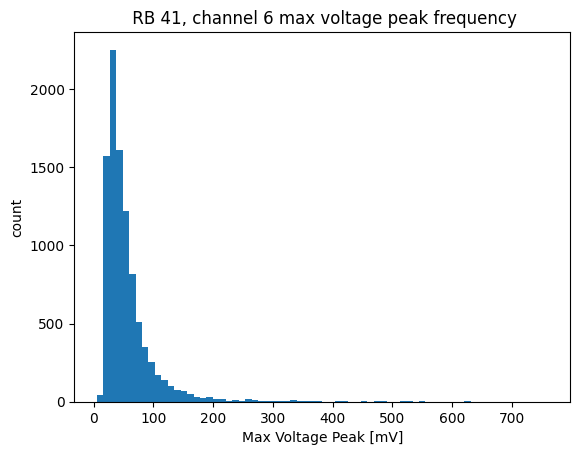

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 294/320 [01:17<00:06,  3.84it/s]

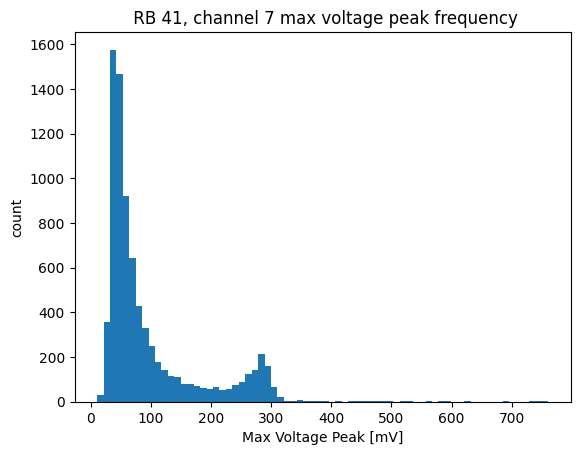

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 295/320 [01:17<00:07,  3.56it/s]

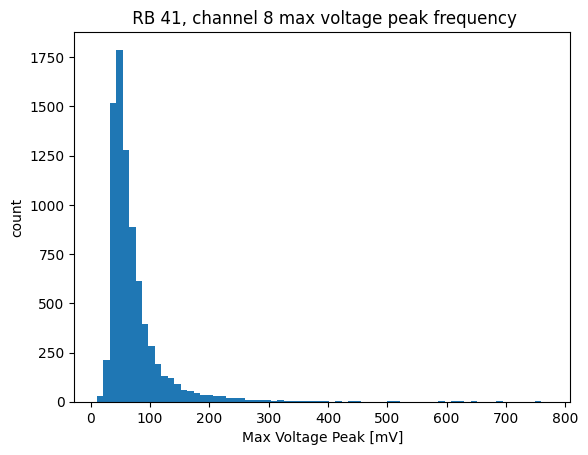

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 296/320 [01:17<00:06,  3.68it/s]

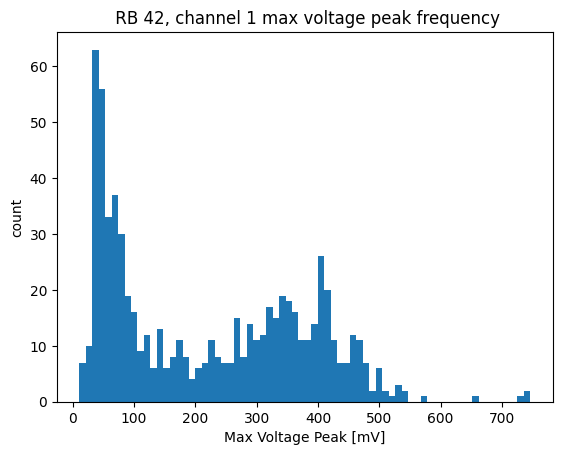

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 297/320 [01:18<00:05,  3.90it/s]

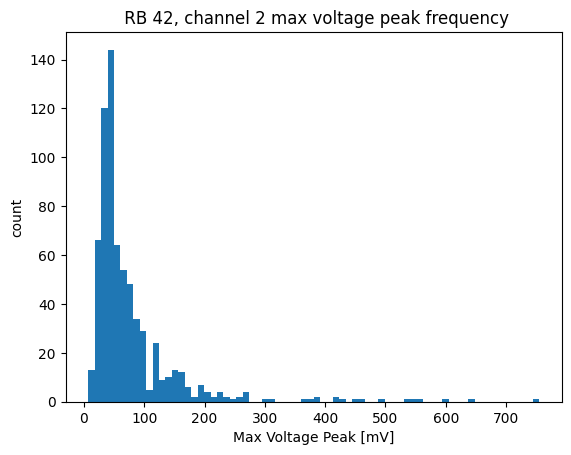

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 298/320 [01:18<00:05,  4.04it/s]

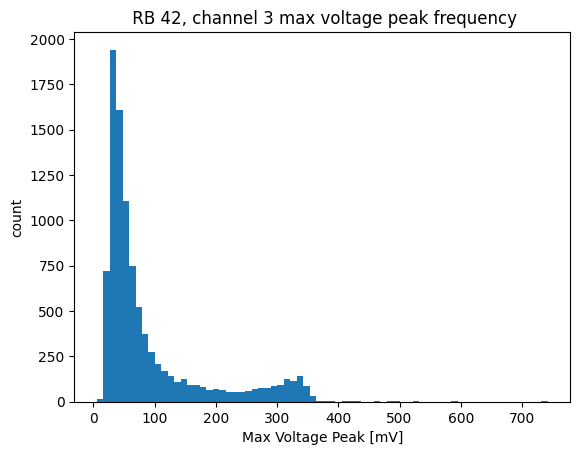

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 299/320 [01:18<00:05,  4.00it/s]

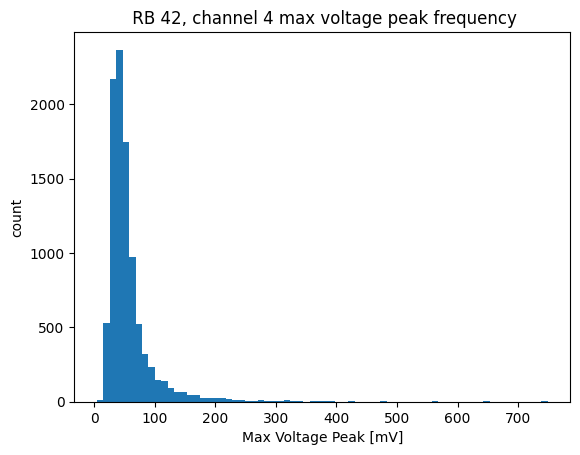

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 300/320 [01:18<00:04,  4.07it/s]

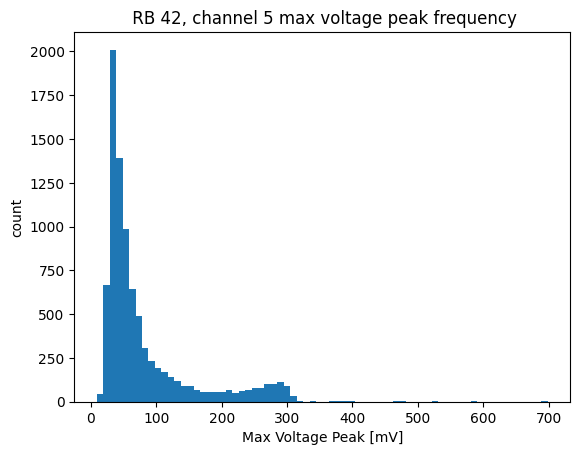

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 301/320 [01:19<00:06,  2.79it/s]

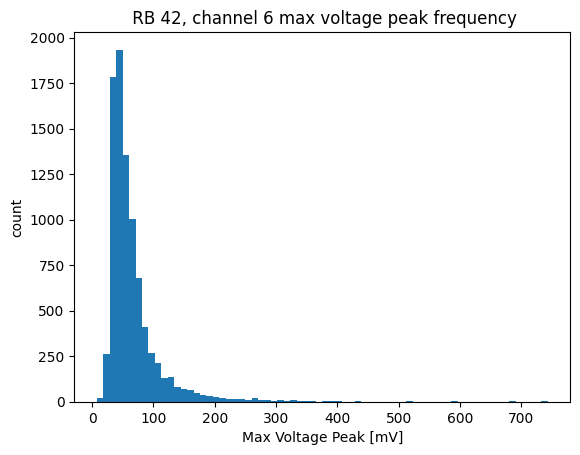

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 302/320 [01:19<00:05,  3.05it/s]

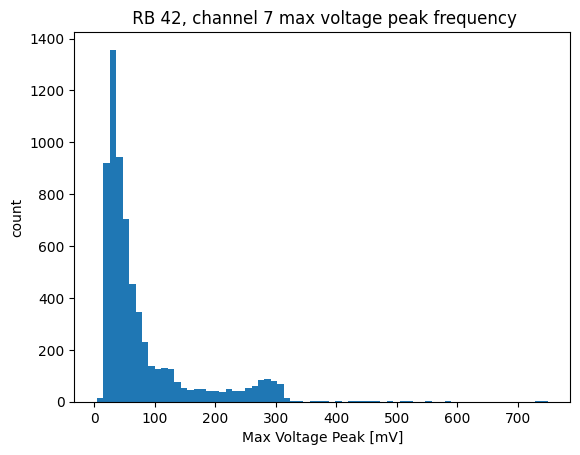

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 303/320 [01:19<00:05,  3.31it/s]

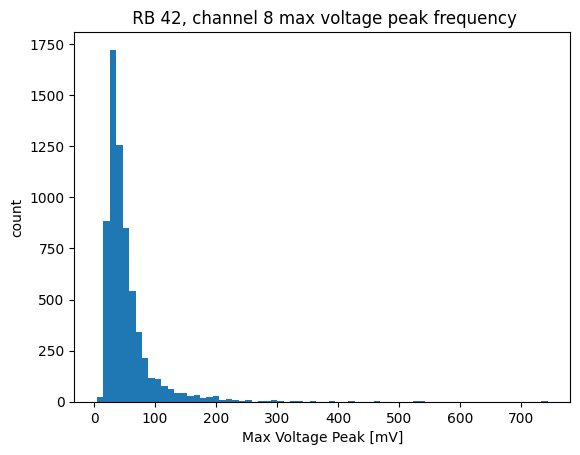

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 304/320 [01:20<00:04,  3.50it/s]

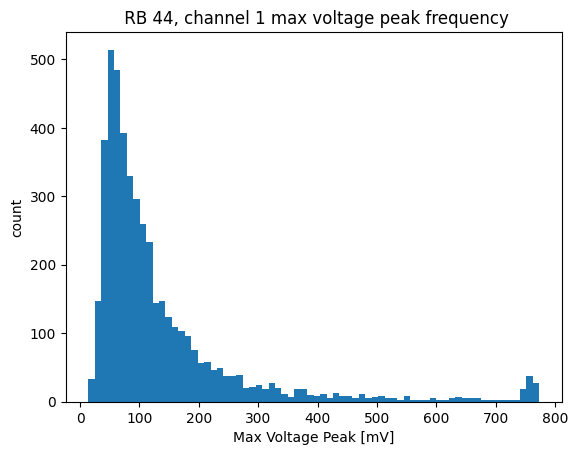

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 305/320 [01:20<00:04,  3.69it/s]

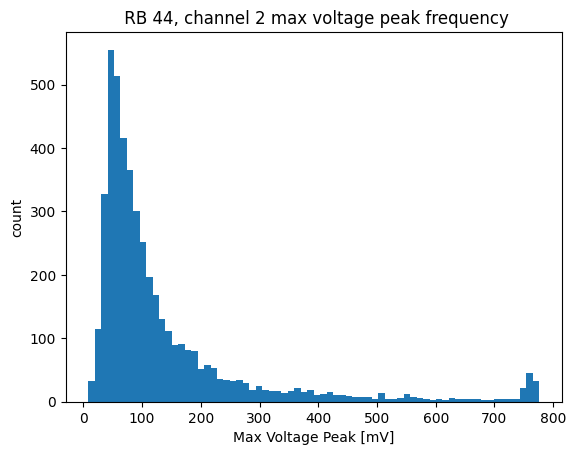

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 306/320 [01:20<00:03,  3.84it/s]

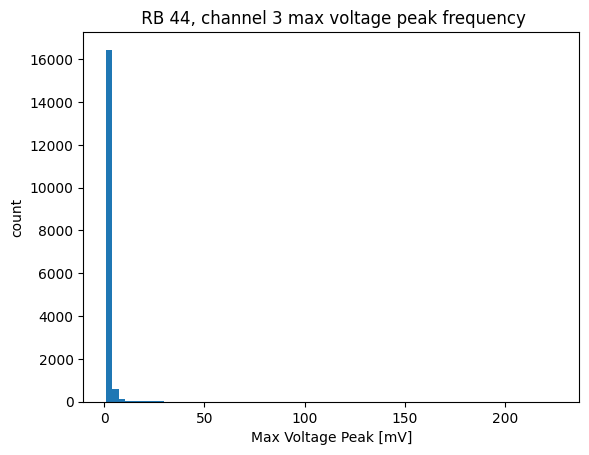

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 307/320 [01:20<00:03,  3.77it/s]

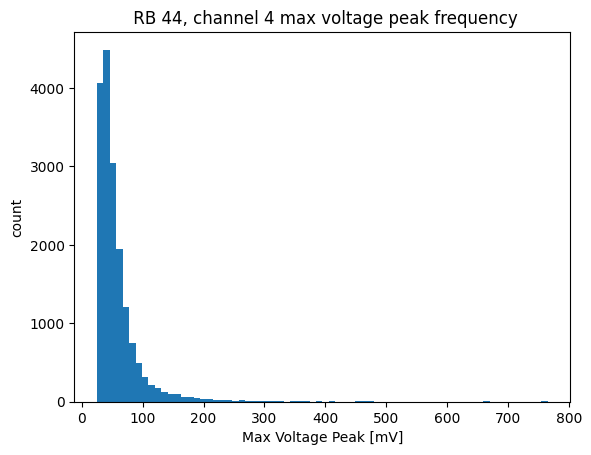

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 308/320 [01:21<00:03,  3.79it/s]

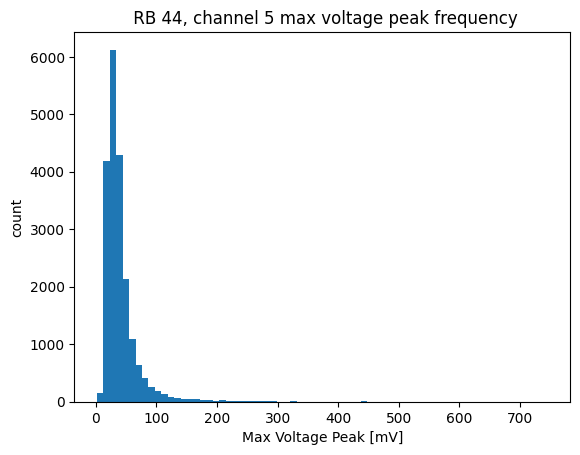

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 309/320 [01:21<00:02,  3.72it/s]

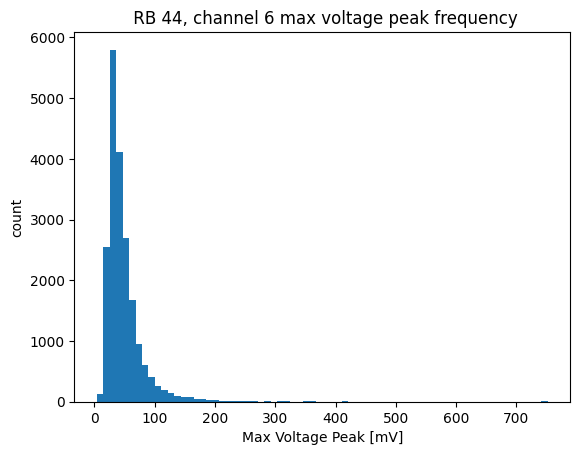

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 310/320 [01:21<00:02,  3.69it/s]

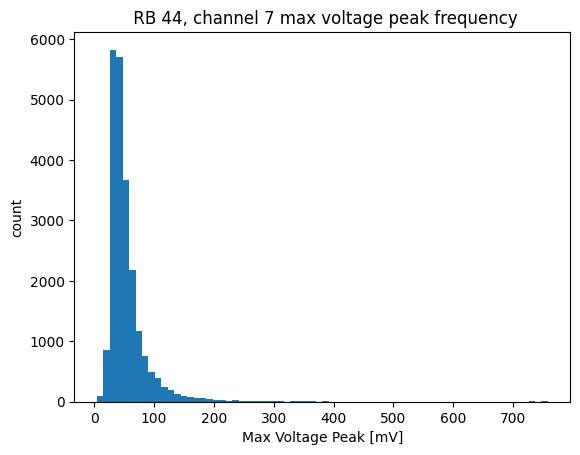

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 311/320 [01:22<00:02,  3.65it/s]

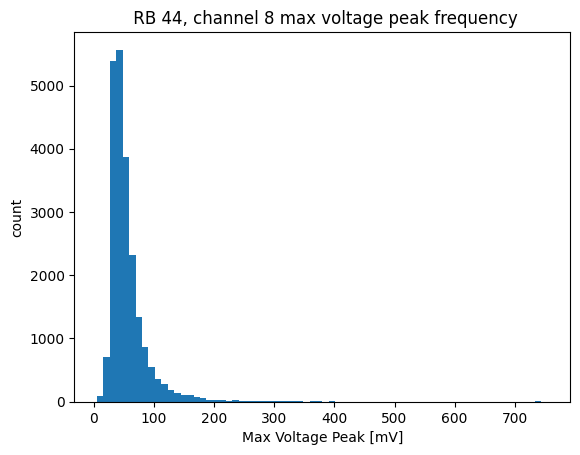

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 312/320 [01:22<00:02,  3.65it/s]

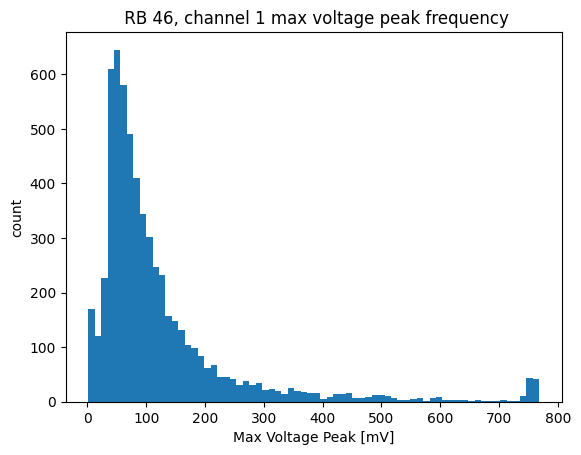

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 313/320 [01:22<00:01,  3.79it/s]

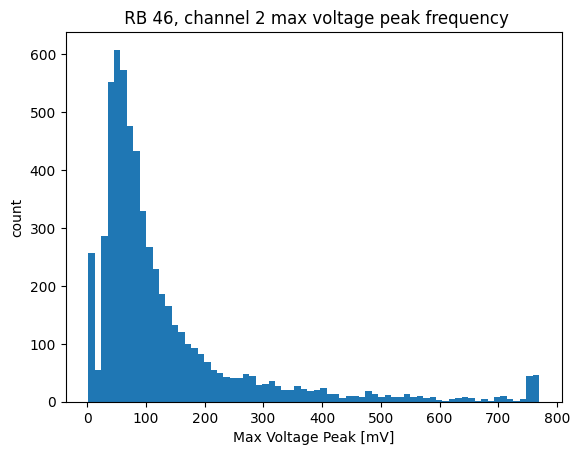

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 314/320 [01:22<00:01,  3.85it/s]

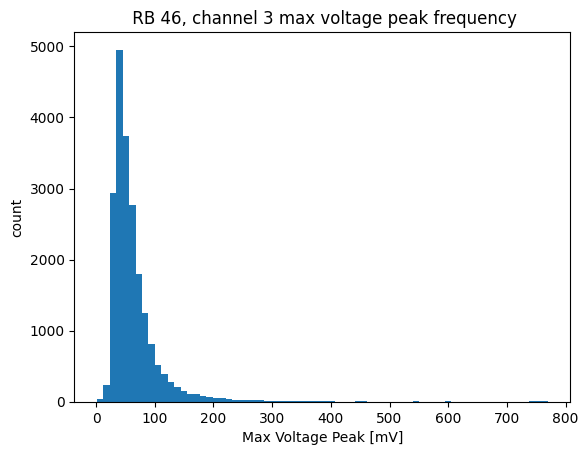

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 315/320 [01:23<00:01,  3.78it/s]

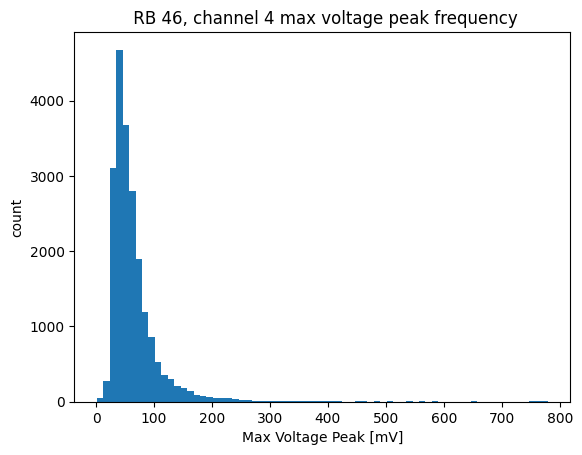

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 316/320 [01:23<00:01,  3.75it/s]

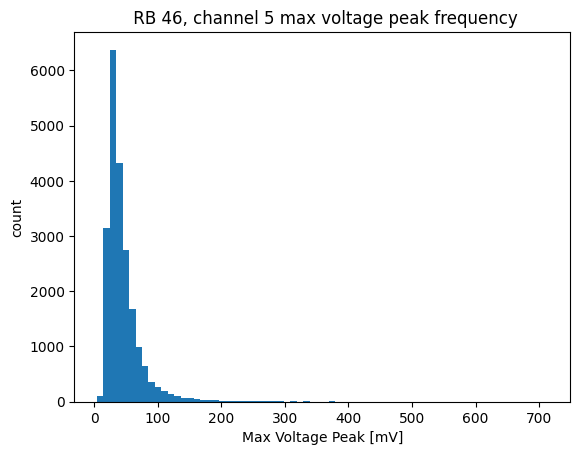

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 317/320 [01:24<00:01,  2.60it/s]

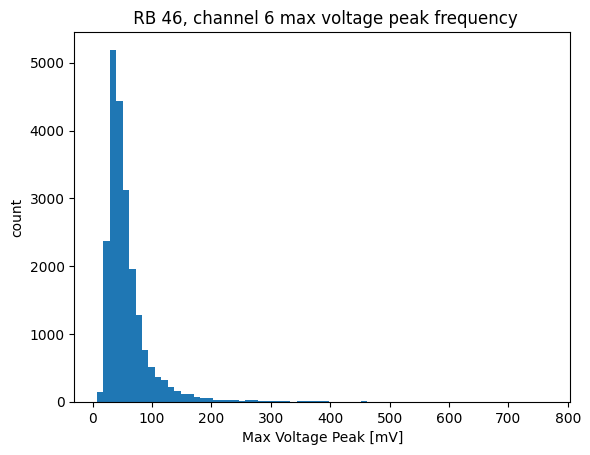

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 318/320 [01:24<00:00,  2.83it/s]

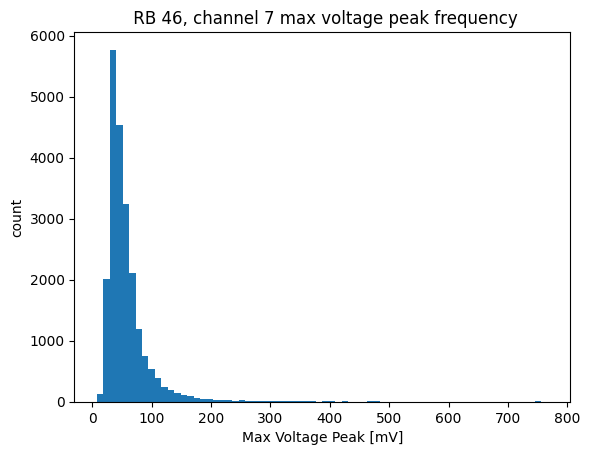

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 319/320 [01:24<00:00,  2.98it/s]

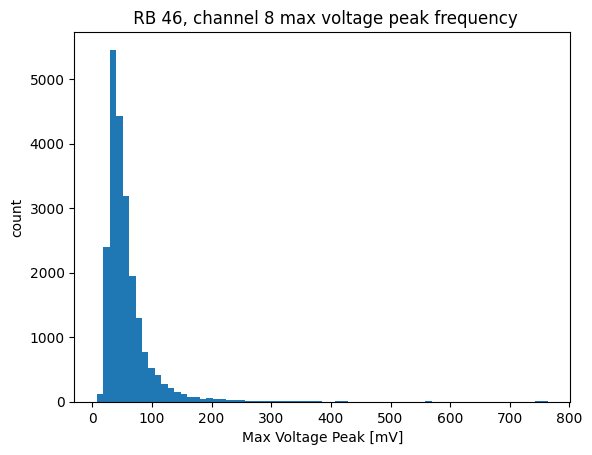

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [01:24<00:00,  3.77it/s]


In [55]:
for rb, channel in tqdm(sorted(max_pulse_dict.keys())): #individual plots
    mp = max_pulse_dict[(rb, channel)]
    plt.hist(mp, bins=70)
    plt.title(f' RB {rb}, channel {channel+1} max voltage peak frequency')
    plt.xlabel('Max Voltage Peak [mV]')
    plt.ylabel('count')
    #plt.yscale('log')
    #plt.xlim(-10, 20)
    plt.show()

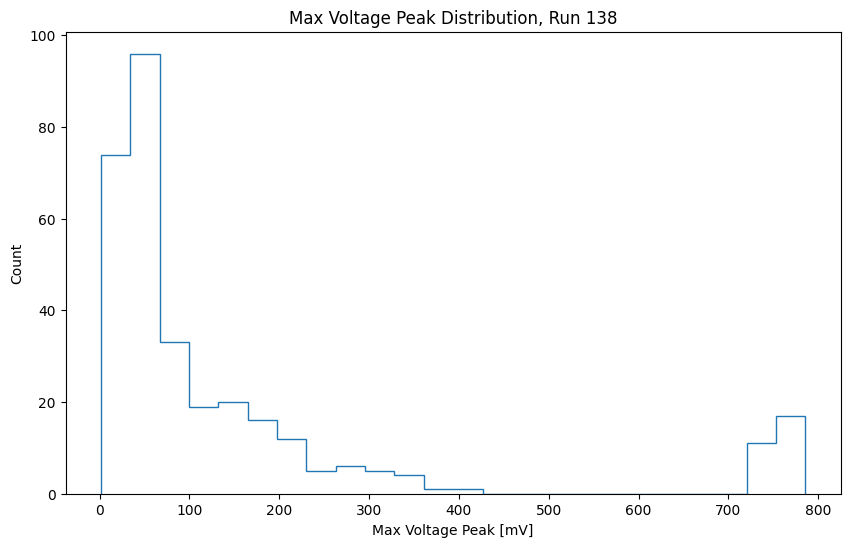

In [56]:
#composite plot of most common value from individual plots

from collections import Counter

def most_common_integer(lst):
    # Use Counter to count occurrences of each integer in the list
    counts = Counter(lst)
    # Use the most_common() method to get the most common integer
    most_common = counts.most_common(1)
    # Return the most common integer
    return most_common[0][0]
    
my_dict = {}

for (r, channel1), max_pulse_list in max_pulse_dict.items(): #populate dictionary based on the elements of the baseline_rms_dict. baseline_rms_dict uses the library defaultdict to create a list in baselime_rms_dict for each r,channel1 pair
    common_max_pulse = most_common_integer(max_pulse_list)   # here the mean is calculated of the baseline_rms_list for each dict containing the list of values for each r,channel1 pair.  
    if r in my_dict:
        my_dict[r][channel1] = common_max_pulse

    else:
        my_dict[r]={channel1: common_max_pulse}

# Access all the max_pulse_dict values
max_pulse_values = [max_V for sub_dict in my_dict.values() for max_V in sub_dict.values()]

#filtered_values = np.where(np.array(baseline_rms_values) < 250)[0]

# Create a histogram with values
plt.figure(figsize = (10, 6))
plt.hist(np.array(max_pulse_values), histtype = 'step', bins = 24)

plt.xlabel('Max Voltage Peak [mV]')
plt.ylabel('Count')
plt.title('Max Voltage Peak Distribution, Run 138')
#plt.xticks(np.arange(0.5, 1.5, 0.1))
plt.show()